In [ ]:
# basic stuff 
from scipy import stats, signal, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
# from google.colab import files
import os
import sklearn
import time
import json
import math
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import subprocess
from sklearn.preprocessing import StandardScaler
import seaborn as sn

# torch stuff
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn
import torch.nn.functional as F

# !pip install mat73
# import mat73

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Miller_Lab/FIU/PopFRData/')
sys.path.append('/content/drive/MyDrive/Miller_Lab/FIU/xds_python/')

from xds import lab_data
import joint_angles

# Data

In [ ]:
mat_20211108_xds = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFRData/combined_opensim_neural/','20211108_Pop_FR_001.mat')
mat_20210830_xds = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFRData/combined_opensim_neural/','20210830_Pop__FR_001.mat')
mat_20210921_xds = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFRData/combined_opensim_neural/','20210921_Pop_FR_002.mat')
mat_20211009_xds = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFRData/combined_opensim_neural/','20211009_Pop_FR_001.mat')
# joint angles missing in xds?
# mat_20220405_xds = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFRData/combined_opensim_neural/','20220405_Pop_FR_002.mat')
xds_list = [mat_20211108_xds, mat_20210830_xds, mat_20210921_xds, mat_20211009_xds]

# convert 2nd and 3rd electrodes to degrees
mat_20211108_xds.joint_angles[:,1]*=180/np.pi
mat_20211108_xds.joint_angles[:,2]*=180/np.pi
# convert 2nd and 3rd electrodes to degrees
mat_20210830_xds.joint_angles[:,1]*=180/np.pi
mat_20210830_xds.joint_angles[:,2]*=180/np.pi
# convert 2nd and 3rd electrodes to degrees
mat_20210921_xds.joint_angles[:,1]*=180/np.pi
mat_20210921_xds.joint_angles[:,2]*=180/np.pi
# convert 2nd and 3rd electrodes to degrees
mat_20211009_xds.joint_angles[:,1]*=180/np.pi
mat_20211009_xds.joint_angles[:,2]*=180/np.pi
# convert 2nd and 3rd electrodes to degrees
# mat_20220405_xds.joint_angles[:,1]*=180/np.pi
# mat_20220405_xds.joint_angles[:,2]*=180/np.pi

In [ ]:
for xds_file in xds_list:
    print(xds_file.joint_angles.shape, xds_file.spike_counts.shape)

(17970, 24) (599008, 93)
(35941, 24) (1199012, 114)
(35941, 24) (1199012, 123)
(35941, 24) (1199012, 119)


In [ ]:
for data in xds_list:
    print('Session Duration: {}, Num Neural Instances: {}'.format(data.get_meta()['duration'], data.spike_counts.shape))

Session Duration: 600.004, Num Neural Instances: (599008, 93)
Session Duration: 1200.009, Num Neural Instances: (1199012, 114)
Session Duration: 1200.009, Num Neural Instances: (1199012, 123)
Session Duration: 1200.009, Num Neural Instances: (1199012, 119)


In [ ]:
for xds_file in xds_list:
    bin_size = 1/30
    print('Shape before binning+smoothing is: {}'.format(xds_file.spike_counts.shape))
    xds_file.update_bin_data(bin_size)                                      #bin
    xds_file.smooth_binned_spikes(bin_size, 'gaussian', bin_size*2)         #smooth
    print('Shape after binning+smoothing is: {}'.format(xds_file.spike_counts.shape))

Shape before binning+smoothing is: (599008, 93)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (17971, 93)
Shape before binning+smoothing is: (1199012, 114)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (35971, 114)
Shape before binning+smoothing is: (1199012, 123)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (35971, 123)
Shape before binning+smoothing is: (1199012, 119)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (35971, 119)


In [ ]:
for xds_file in xds_list:
    print(xds_file.joint_angles.shape, xds_file.spike_counts.shape)

(17970, 24) (17971, 93)
(35941, 24) (35971, 114)
(35941, 24) (35971, 123)
(35941, 24) (35971, 119)


In [ ]:
# inputs
joint_angles_dict = {'20211108':mat_20211108_xds.joint_angles, 
                     '20210830':mat_20210830_xds.joint_angles[1800:], #first minute of video is no good
                     '20210921':mat_20210921_xds.joint_angles, 
                     '20211009':mat_20211009_xds.joint_angles}

velocities_dict = {'20211108':joint_angles.get_joint_velocities(mat_20211108_xds.joint_angles), 
                     '20210830':joint_angles.get_joint_velocities(mat_20210830_xds.joint_angles)[1800:], #first minute of video is no good
                     '20210921':joint_angles.get_joint_velocities(mat_20210921_xds.joint_angles), 
                     '20211009':joint_angles.get_joint_velocities(mat_20211009_xds.joint_angles)}

angles_and_velocities_dict = {'20211108':np.hstack((joint_angles_dict['20211108'], velocities_dict['20211108'])),
                              '20210830':np.hstack((joint_angles_dict['20210830'], velocities_dict['20210830'])),
                              '20210921':np.hstack((joint_angles_dict['20210921'], velocities_dict['20210921'])),
                              '20211009':np.hstack((joint_angles_dict['20211009'], velocities_dict['20211009']))}

# targets
firing_rates_dict = {'20211108':mat_20211108_xds.spike_counts[:-1,:]*30,
                    '20210830':mat_20210830_xds.spike_counts[1800:-30,:]*30,
                    '20210921':mat_20210921_xds.spike_counts[:-30,:]*30,
                    '20211009':mat_20211009_xds.spike_counts[:-30,:]*30
                    }                              

In [ ]:
for date in joint_angles_dict.keys():
    print(joint_angles_dict[date].shape, firing_rates_dict[date].shape)

(17970, 24) (17970, 93)
(34141, 24) (34141, 114)
(35941, 24) (35941, 123)
(35941, 24) (35941, 119)


In [ ]:
dates_list = ['20211108', '20210830', '20210921', '20211009']
good_inputs_dict = {'20211108':mat_20211108_xds.joint_angles[5280:5880],
                    '20210830':mat_20210830_xds.joint_angles[9600:10200],
                    '20210921':mat_20210921_xds.joint_angles[900:1500],
                    '20211009':mat_20211009_xds.joint_angles[600:1200],
                    }
good_velocities_dict = {'20211108':joint_angles.get_joint_velocities(mat_20211108_xds.joint_angles[5280:5880]),
                    '20210830':joint_angles.get_joint_velocities(mat_20210830_xds.joint_angles[9600:10200]),
                    '20210921':joint_angles.get_joint_velocities(mat_20210921_xds.joint_angles[900:1500]),
                    '20211009':joint_angles.get_joint_velocities(mat_20211009_xds.joint_angles[600:1200]),
                    }
good_frates_dict = {'20211108':firing_rates_dict['20211108'][5280:5880],\
                    '20210830':firing_rates_dict['20210830'][9600:10200],\
                    '20210921':firing_rates_dict['20210921'][900:1500],\
                    '20211009':firing_rates_dict['20211009'][600:1200],
                    }

good_frates_range_dict = {'20211108':(5280,5880),
                          '20210830':(9600,10200),
                          '20210921':(900,1500),
                          '20211009':(600,1200),}

In [ ]:
firing_rates_dict_split = {}
for date in firing_rates_dict.keys():
    num_neurons = firing_rates_dict[date].shape[1]
    splt = int(num_neurons/3)
    shuffled_neurons = np.arange(num_neurons)
    np.random.shuffle(shuffled_neurons) #shuffle neurons in place
    split1 = shuffled_neurons[:splt]
    split2 = shuffled_neurons[splt:2*splt]
    split3 = shuffled_neurons[2*splt:]
    firing_rates_dict_split[date] = {}
    firing_rates_dict_split[date][0] = firing_rates_dict[date][:,split1]
    firing_rates_dict_split[date][1] = firing_rates_dict[date][:,split2]
    firing_rates_dict_split[date][2] = firing_rates_dict[date][:,split3]

In [ ]:
for date in firing_rates_dict_split.keys():
    for splt in firing_rates_dict_split[date].keys():
        print(date, splt, firing_rates_dict_split[date][splt].shape)

20211108 0 (17970, 31)
20211108 1 (17970, 31)
20211108 2 (17970, 31)
20210830 0 (34141, 38)
20210830 1 (34141, 38)
20210830 2 (34141, 38)
20210921 0 (35941, 41)
20210921 1 (35941, 41)
20210921 2 (35941, 41)
20211009 0 (35941, 39)
20211009 1 (35941, 39)
20211009 2 (35941, 41)


# Plot Data

### Inputs

20220309


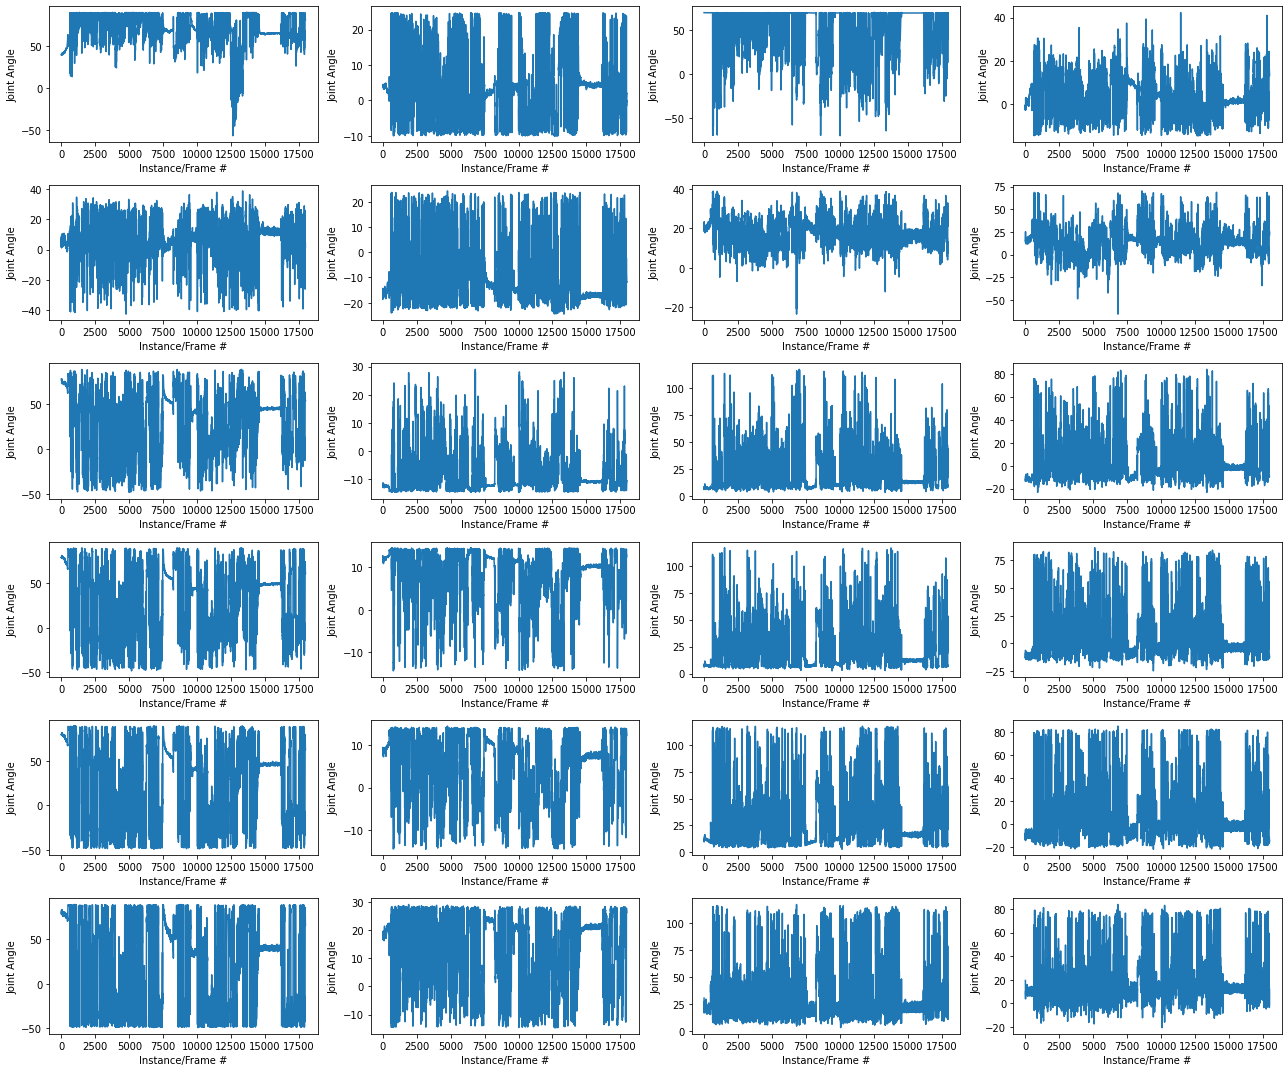

20210712


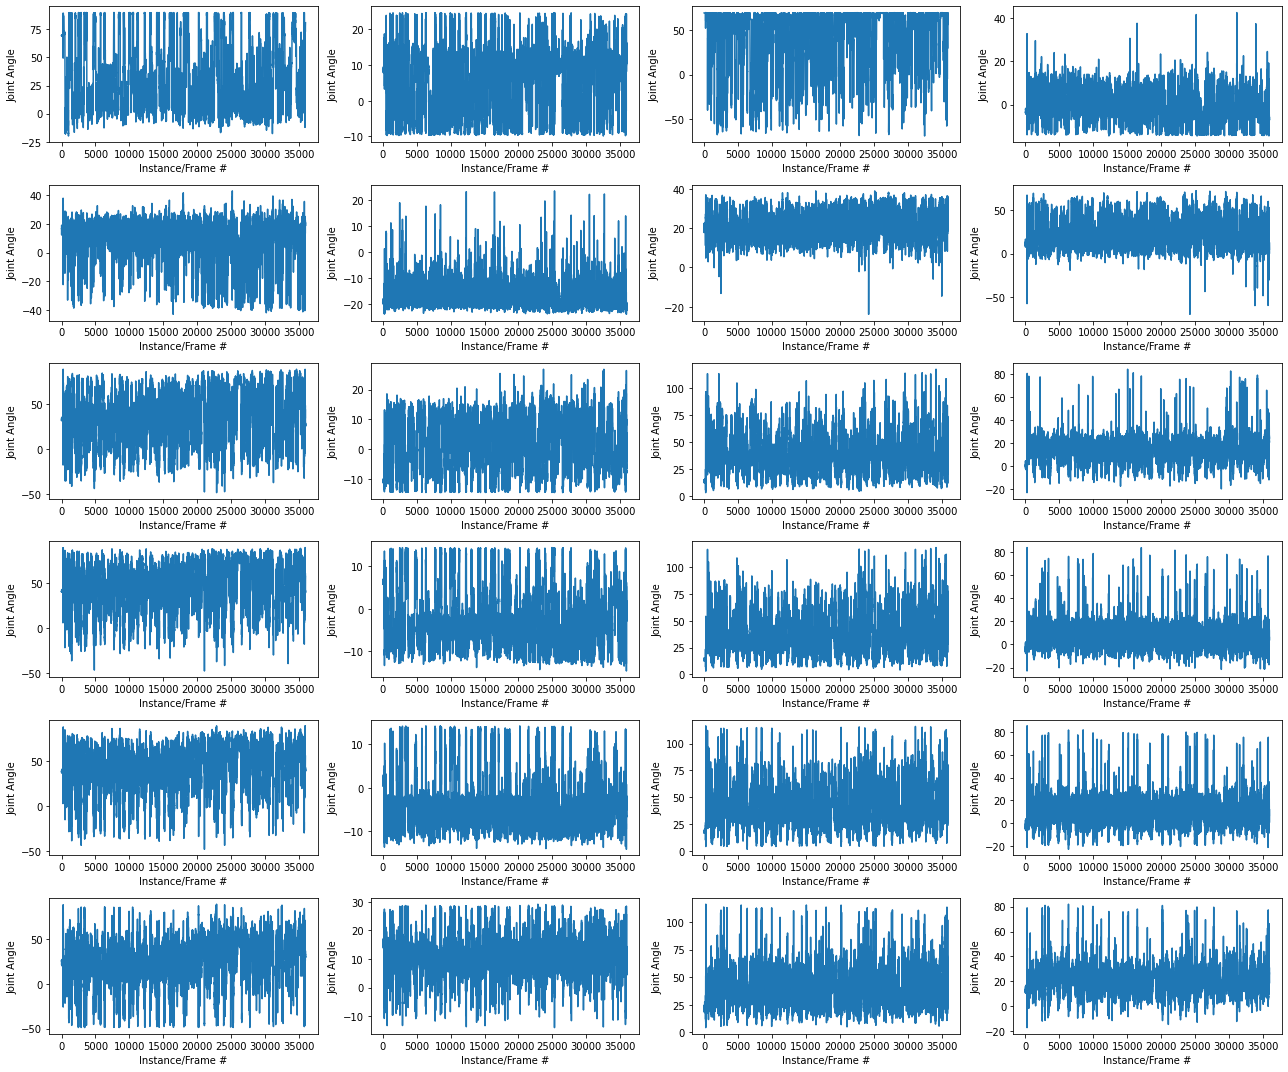

20211105


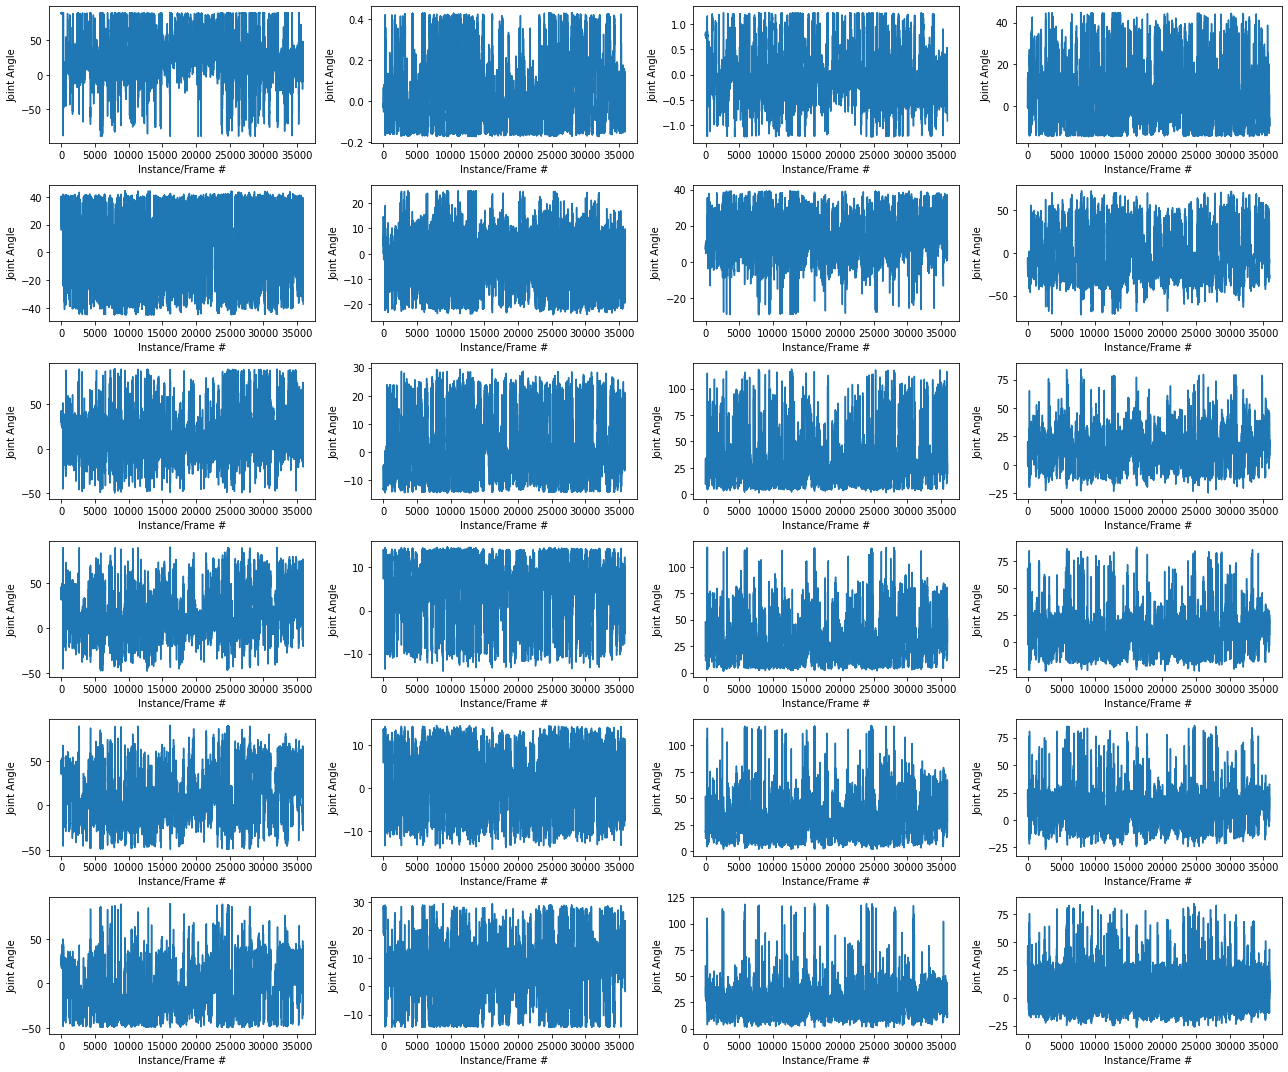

20211108


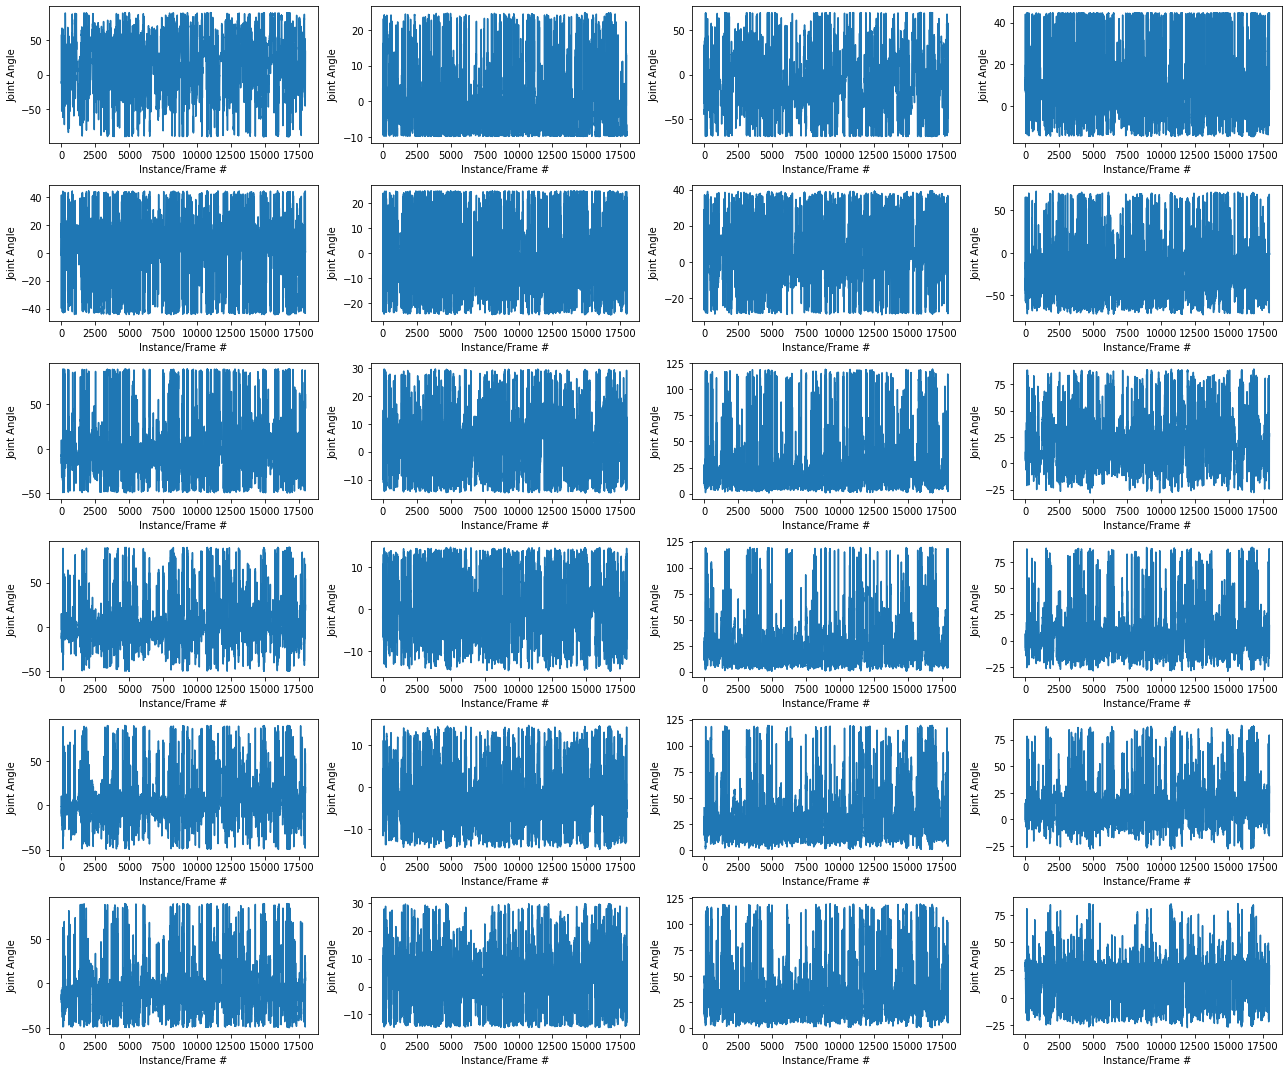

20210814


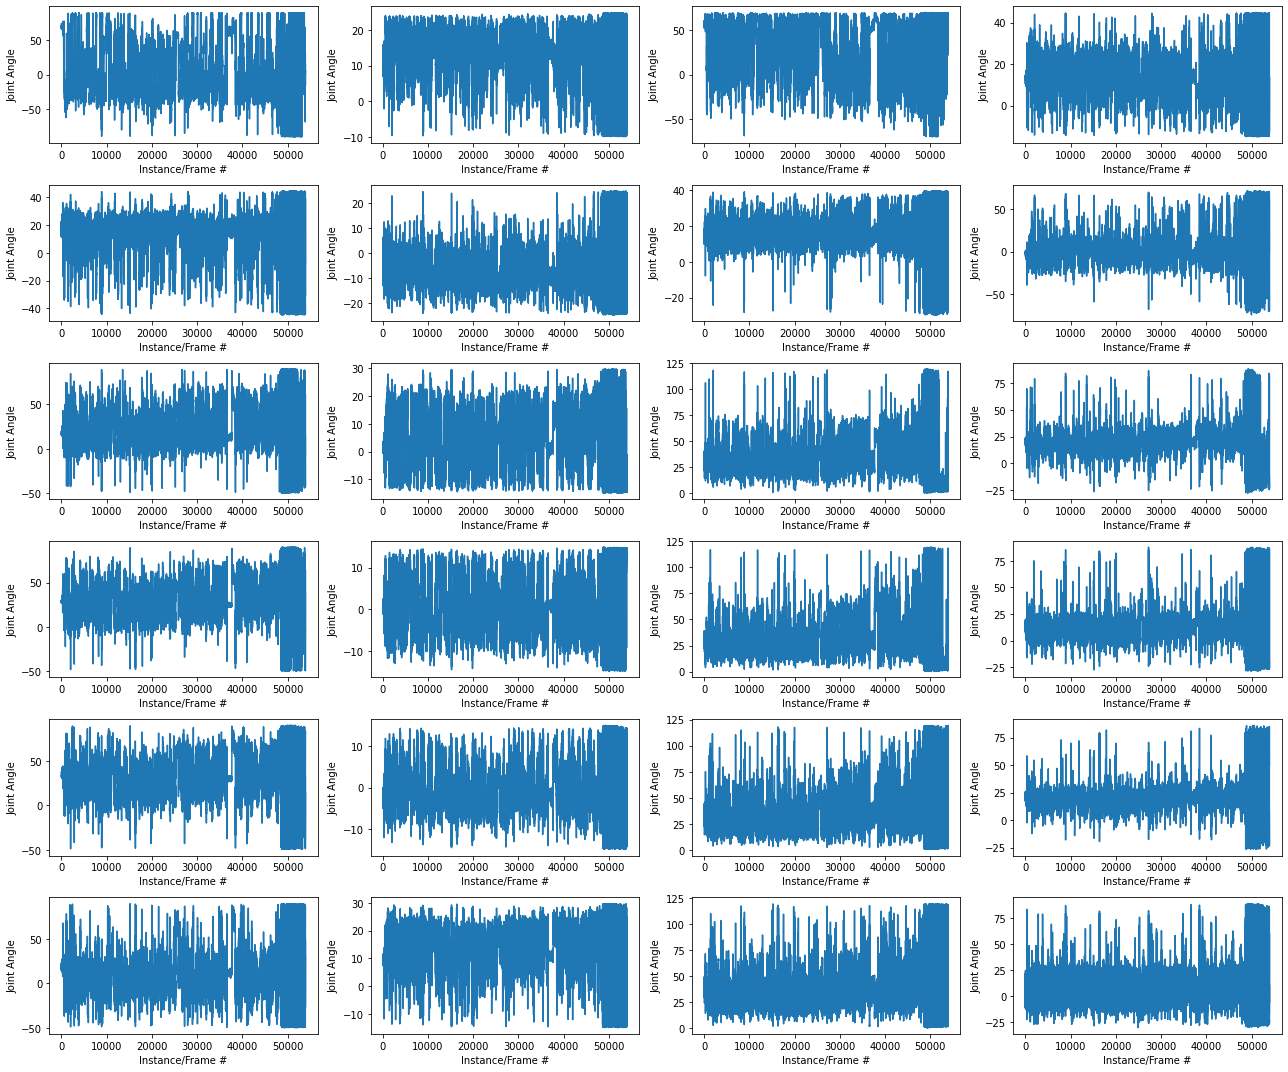

20210710


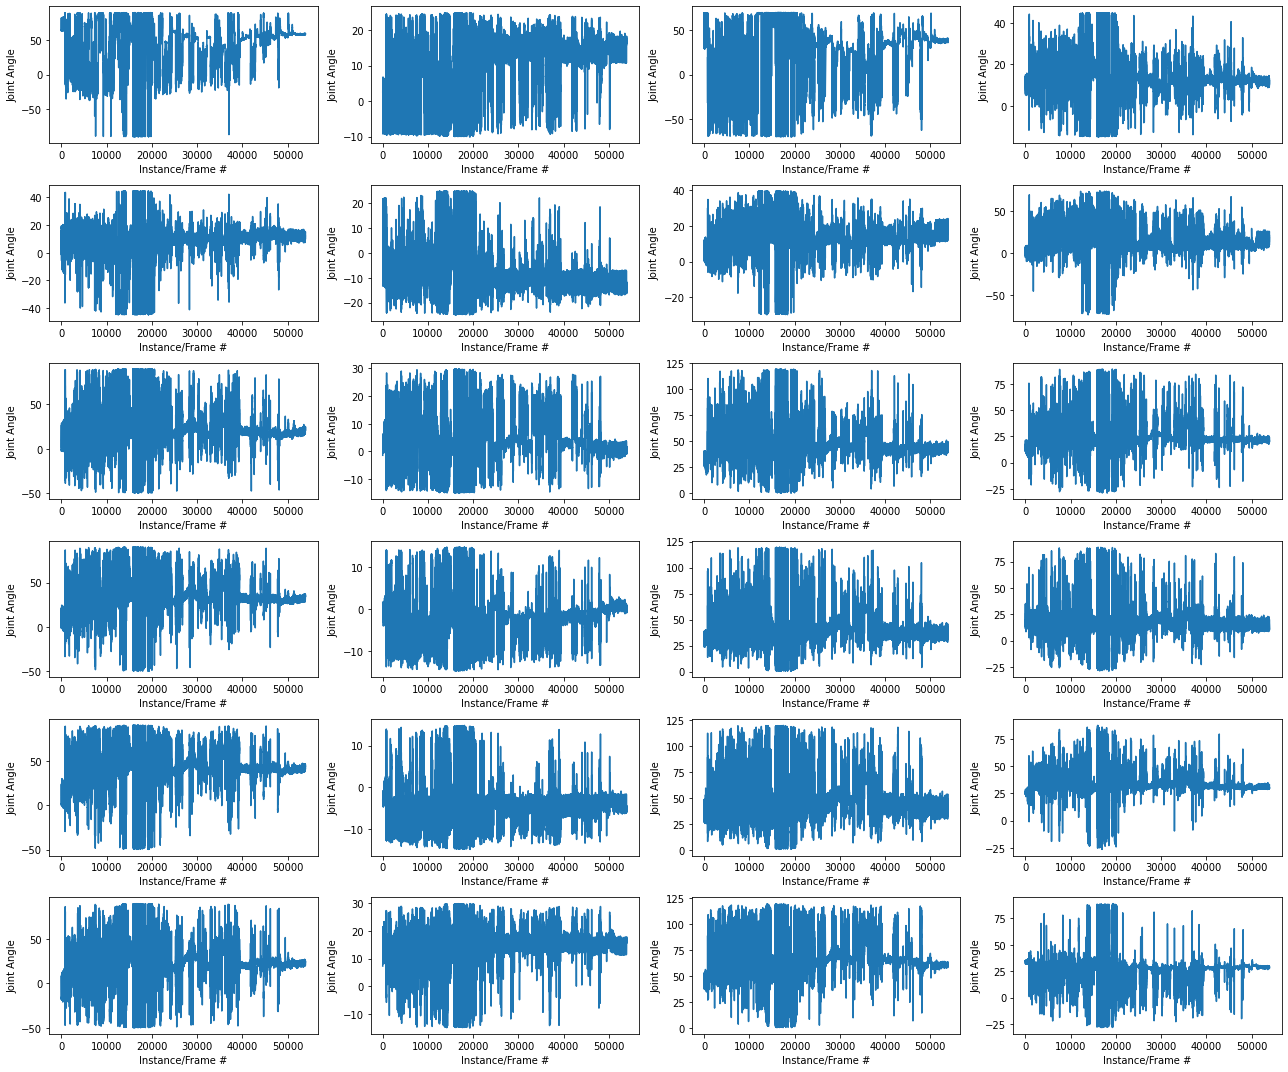

In [ ]:
for date, inp in zip(dates_list, joint_angles_list):
    print(date)
    nrows, ncols = 6,4
    f, ax = plt.subplots(nrows = nrows, ncols = ncols)
    f.set_size_inches(18, 15)
    for k in range(24):
        i = k-(int(k/ncols)*ncols)
        j = int(k/ncols)
        ax[j][i].plot(inp[:,k])
        ax[j][i].set_xlabel('Instance/Frame #')
        ax[j][i].set_ylabel('Joint Angle')
    plt.tight_layout()
    plt.show()

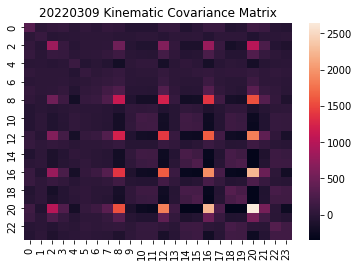

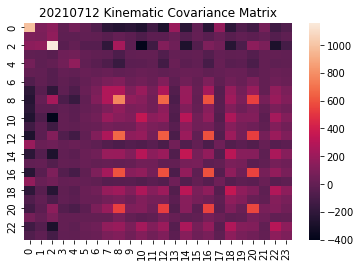

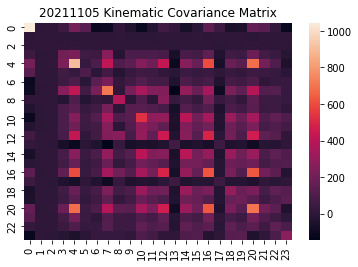

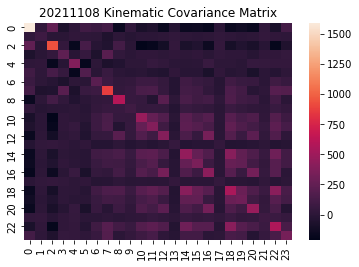

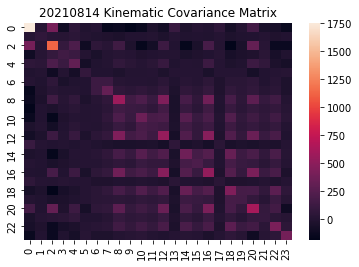

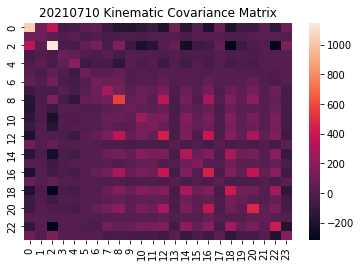

In [ ]:
import seaborn as sn
for date, inp in zip(dates_list, joint_angles_list):
    cov_matrix = np.cov(inp.T)
    sn.heatmap(cov_matrix)
    plt.title('{} Kinematic Covariance Matrix'.format(date))
    plt.show()

### Outputs

20220309


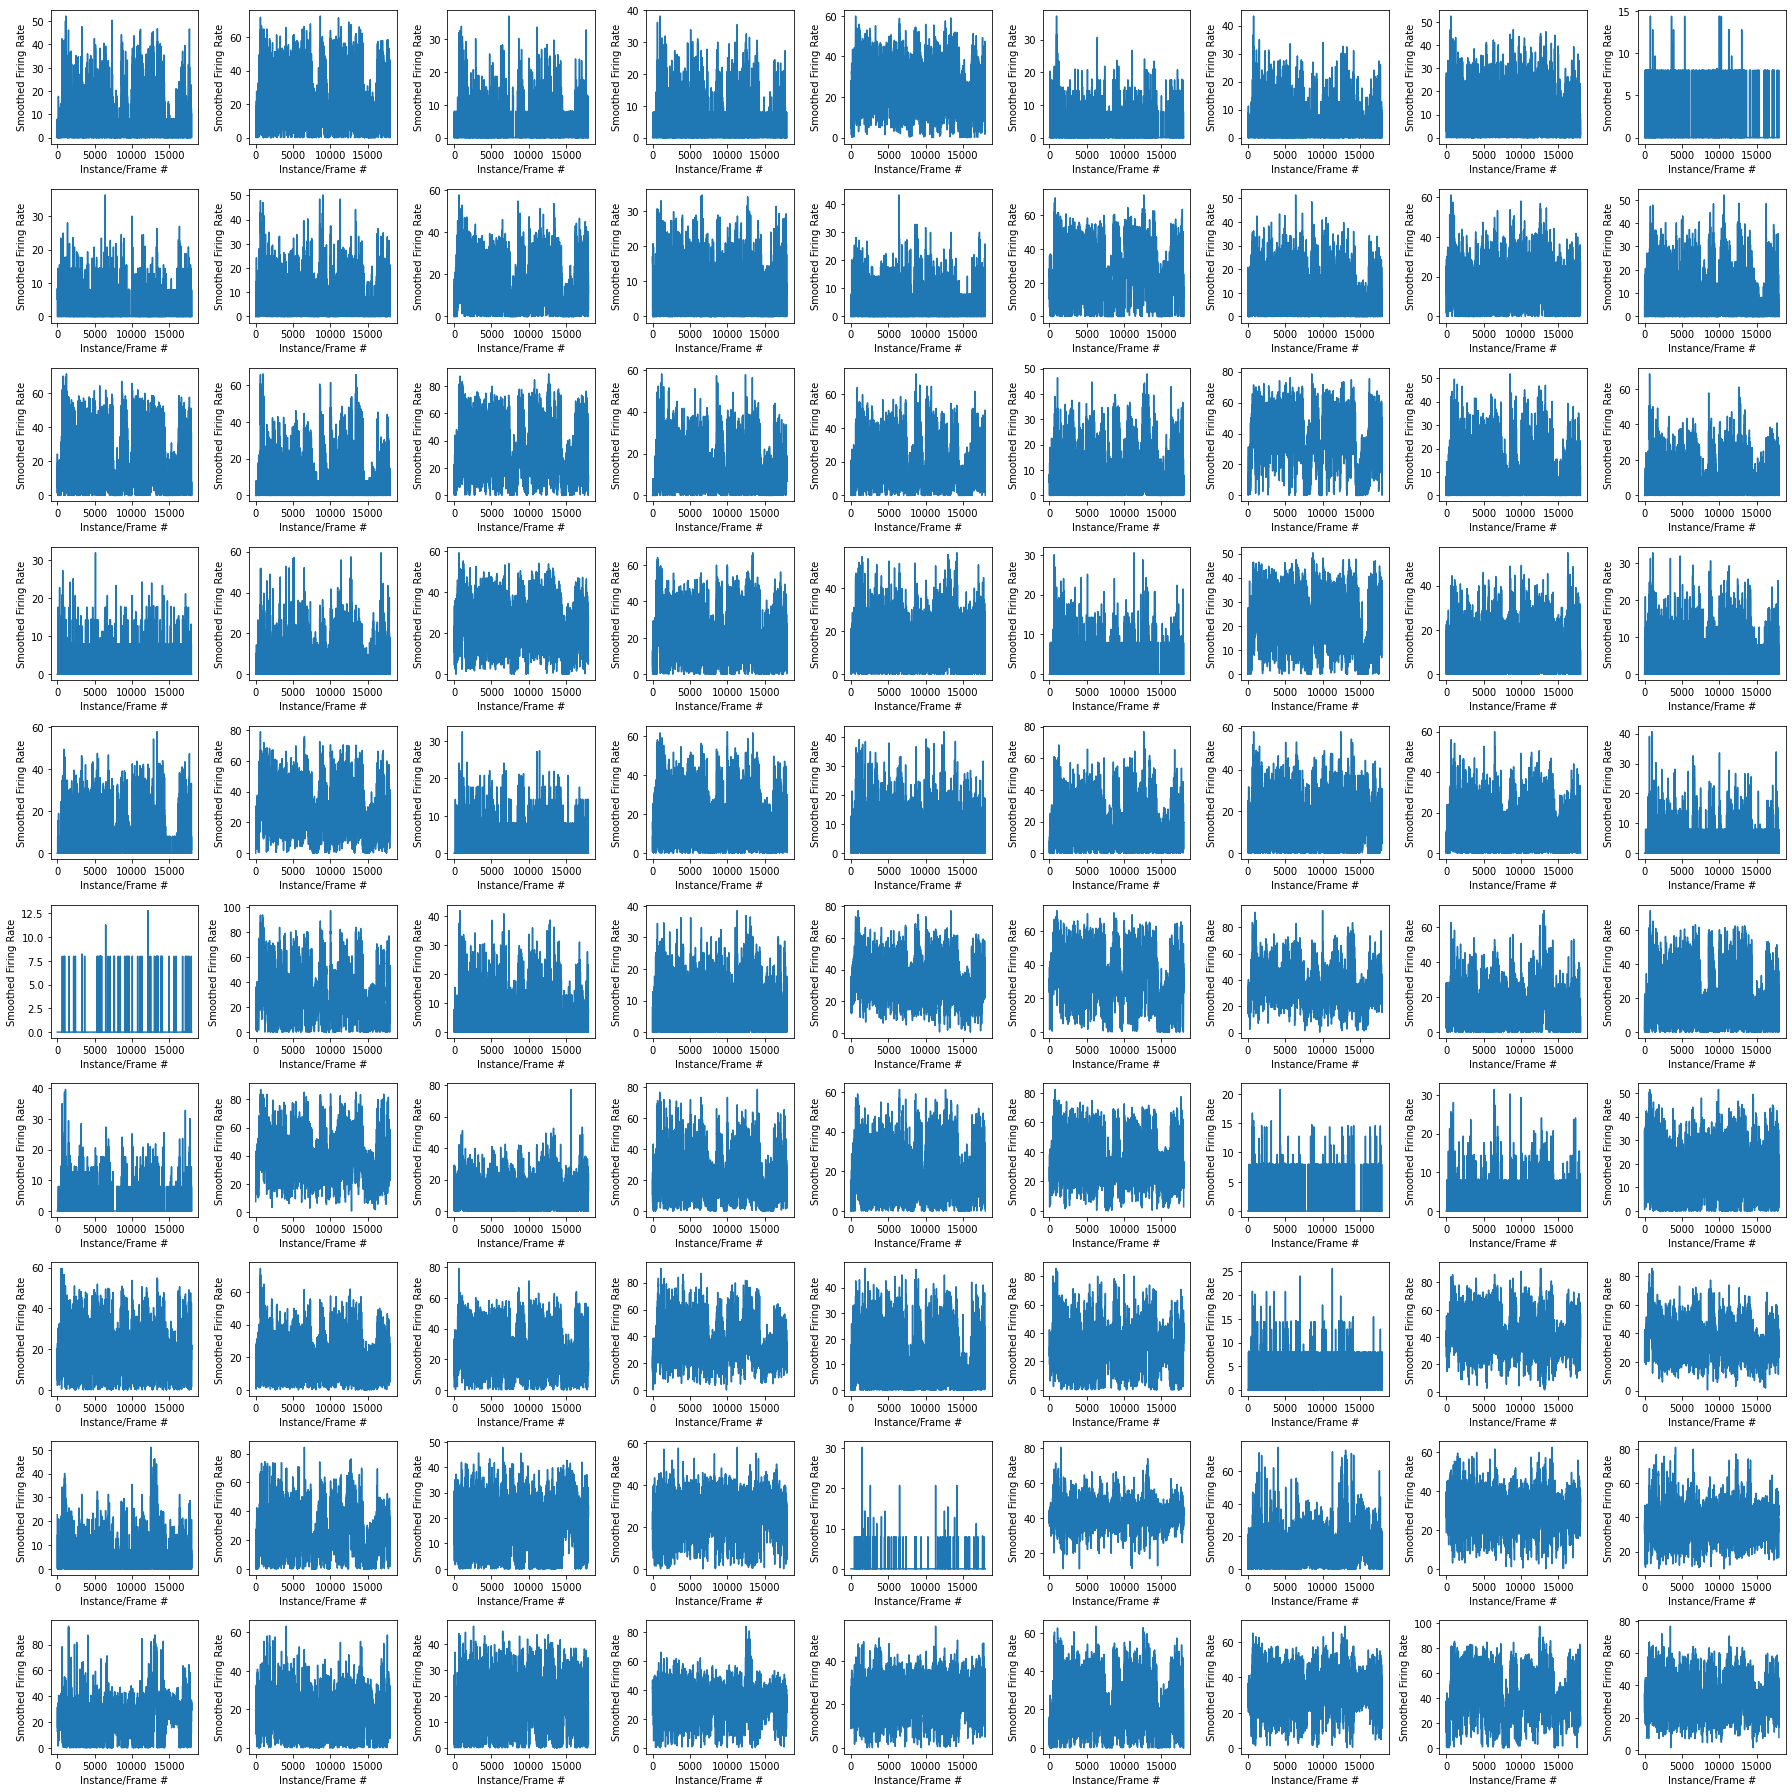

20210712


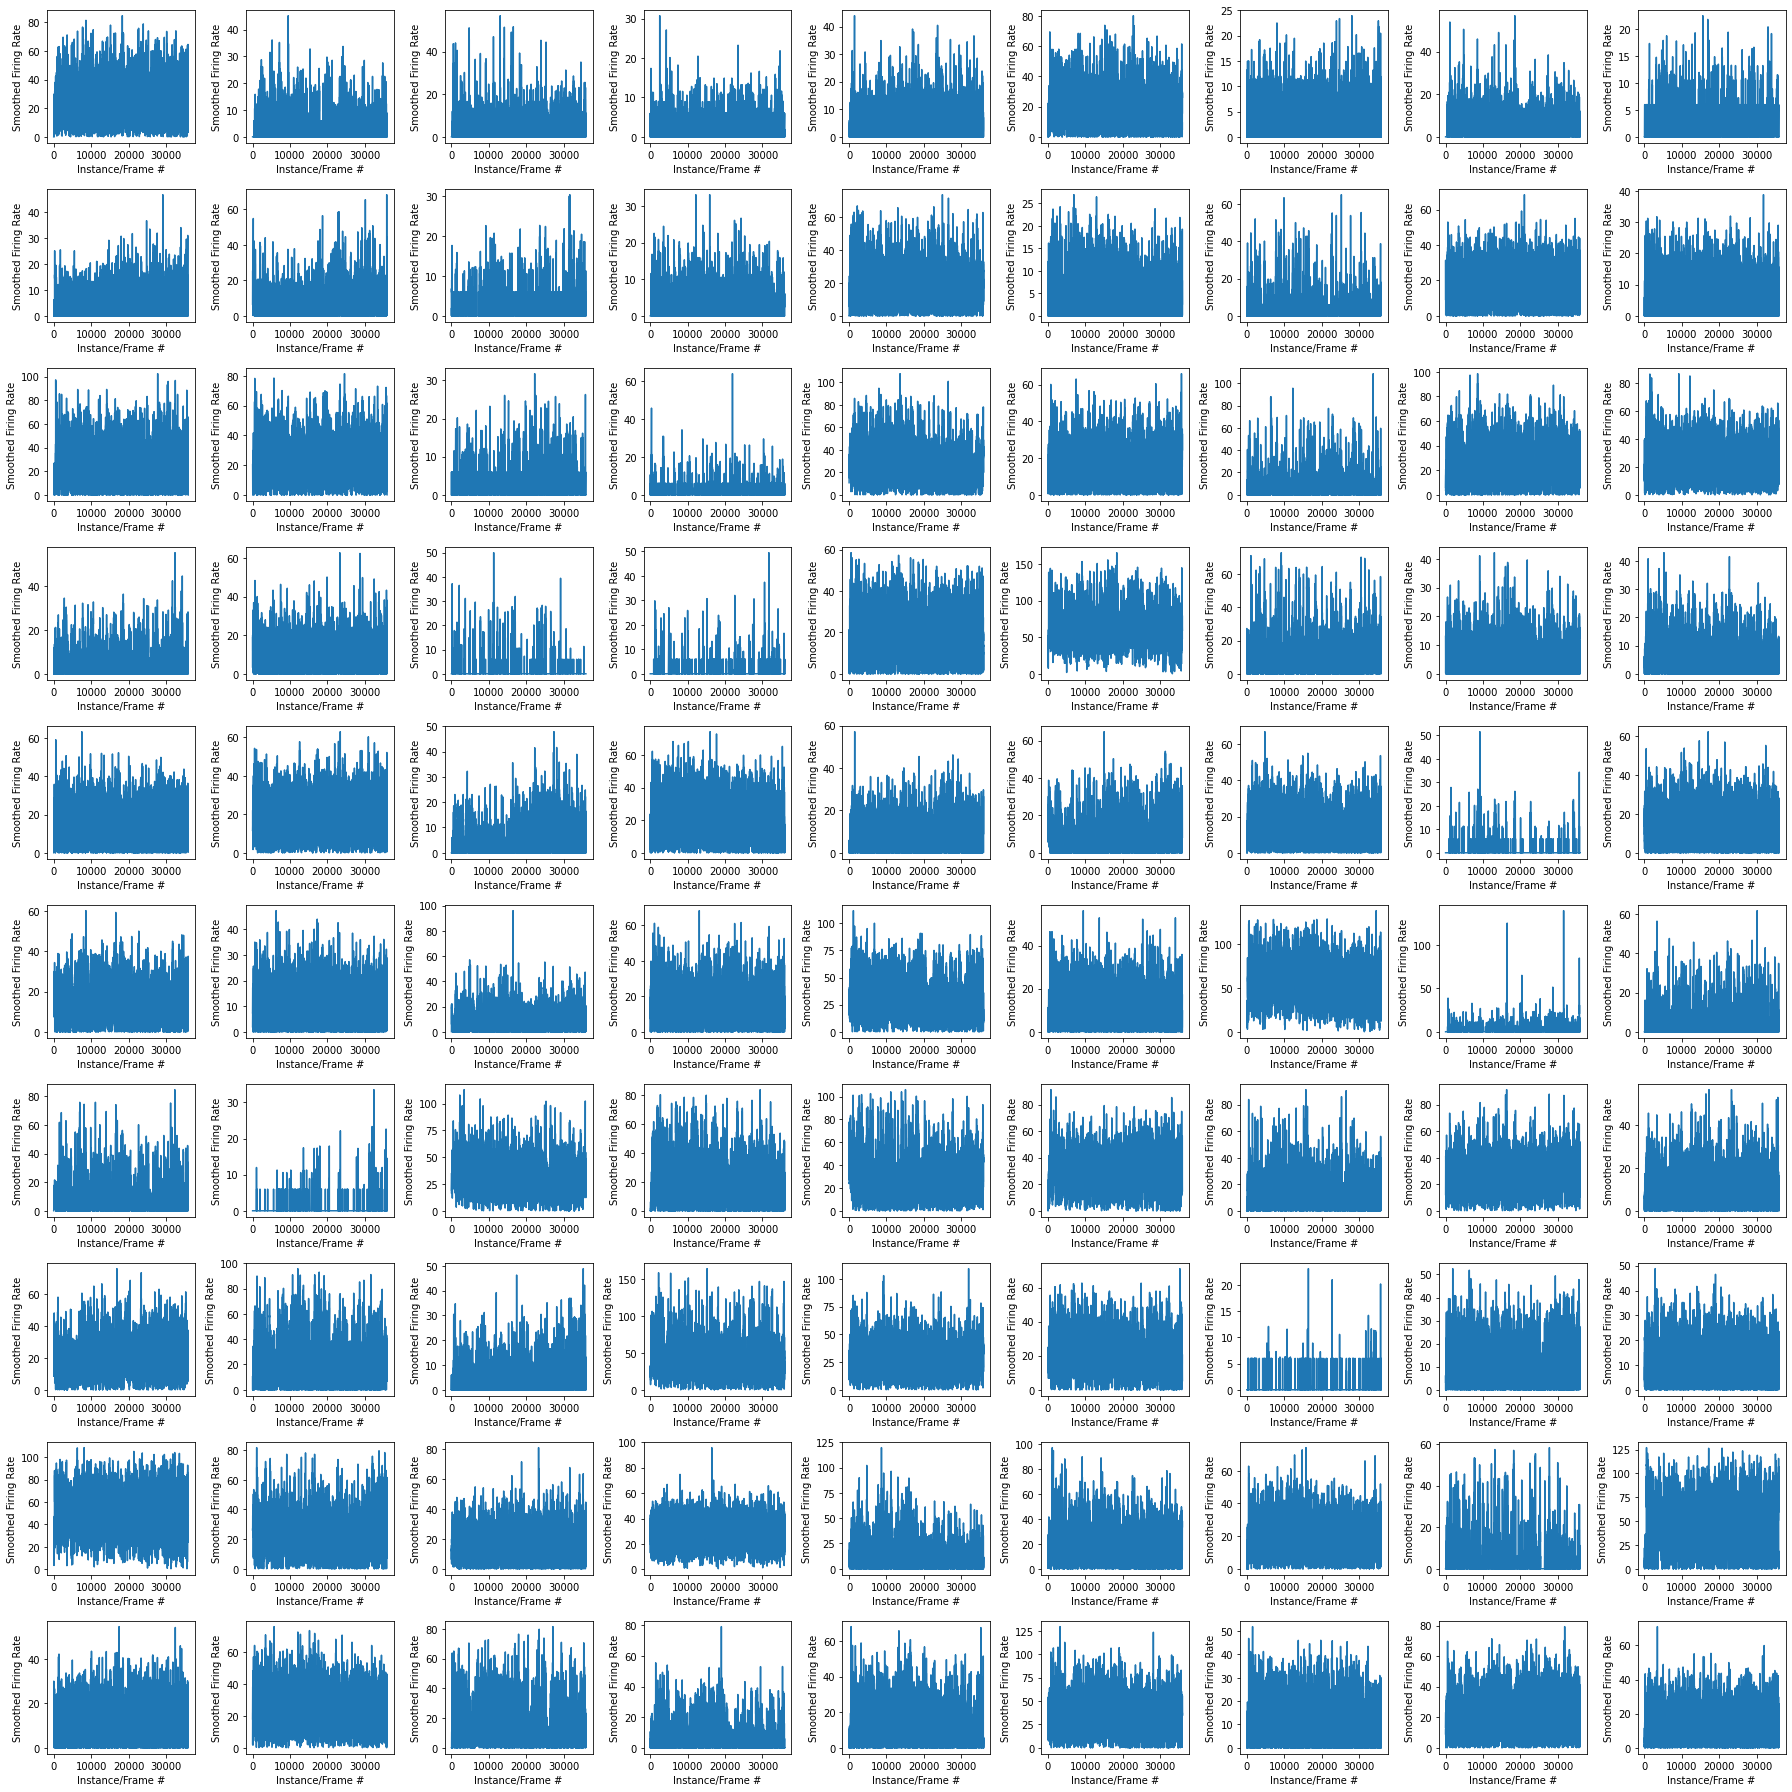

20211105


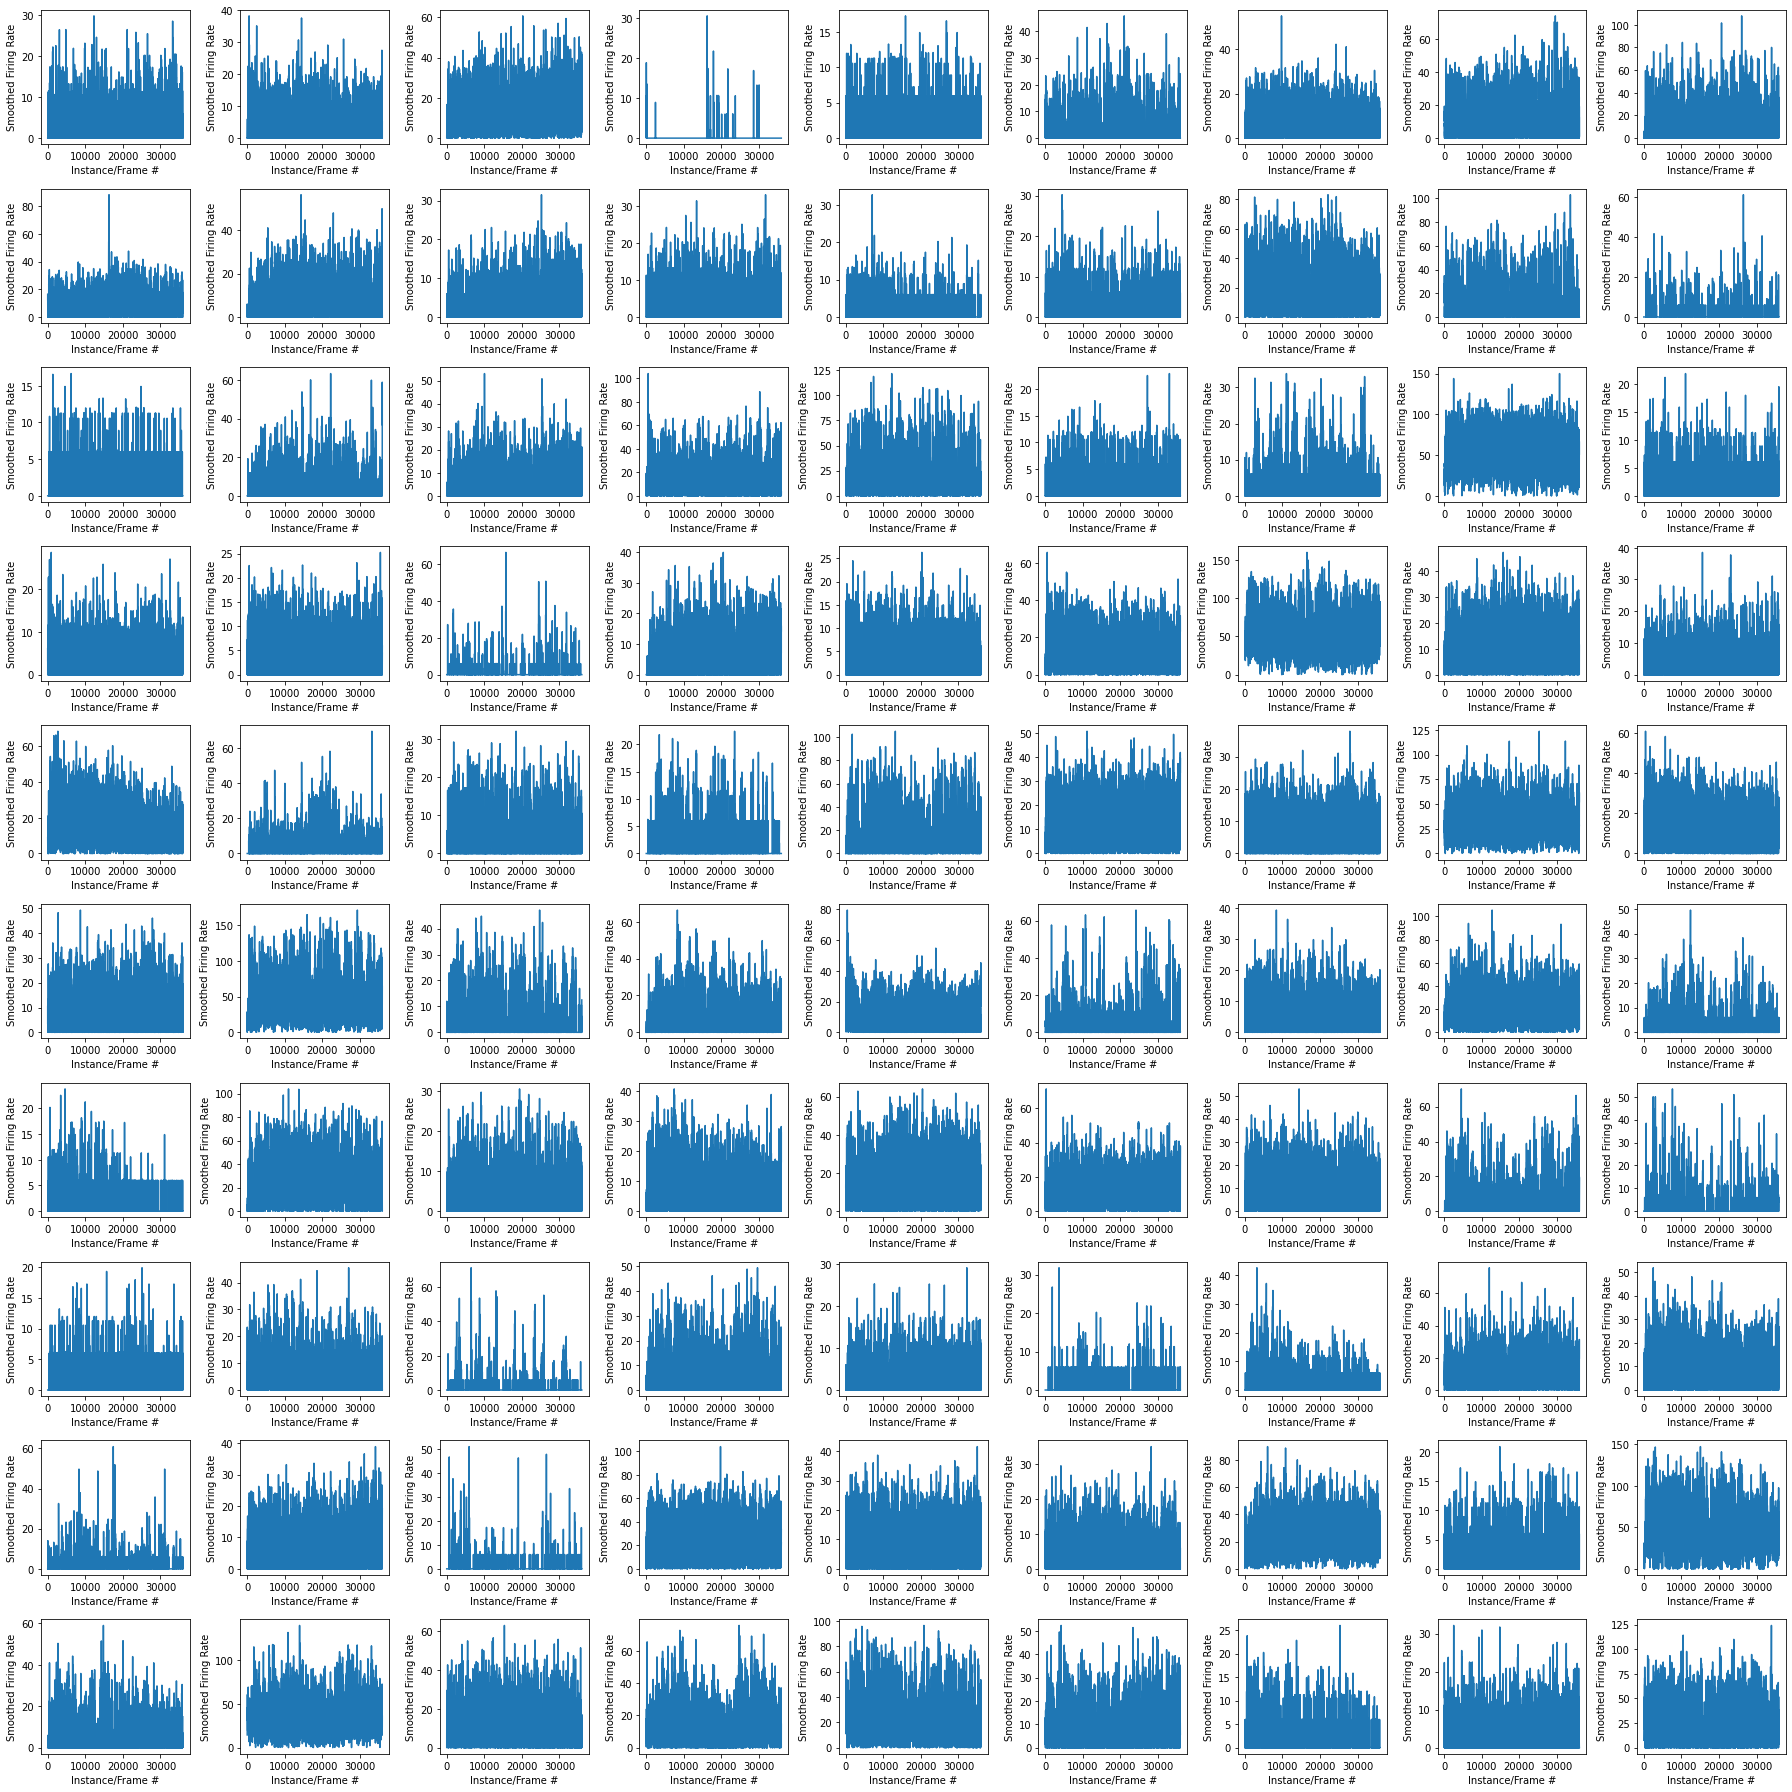

20211108


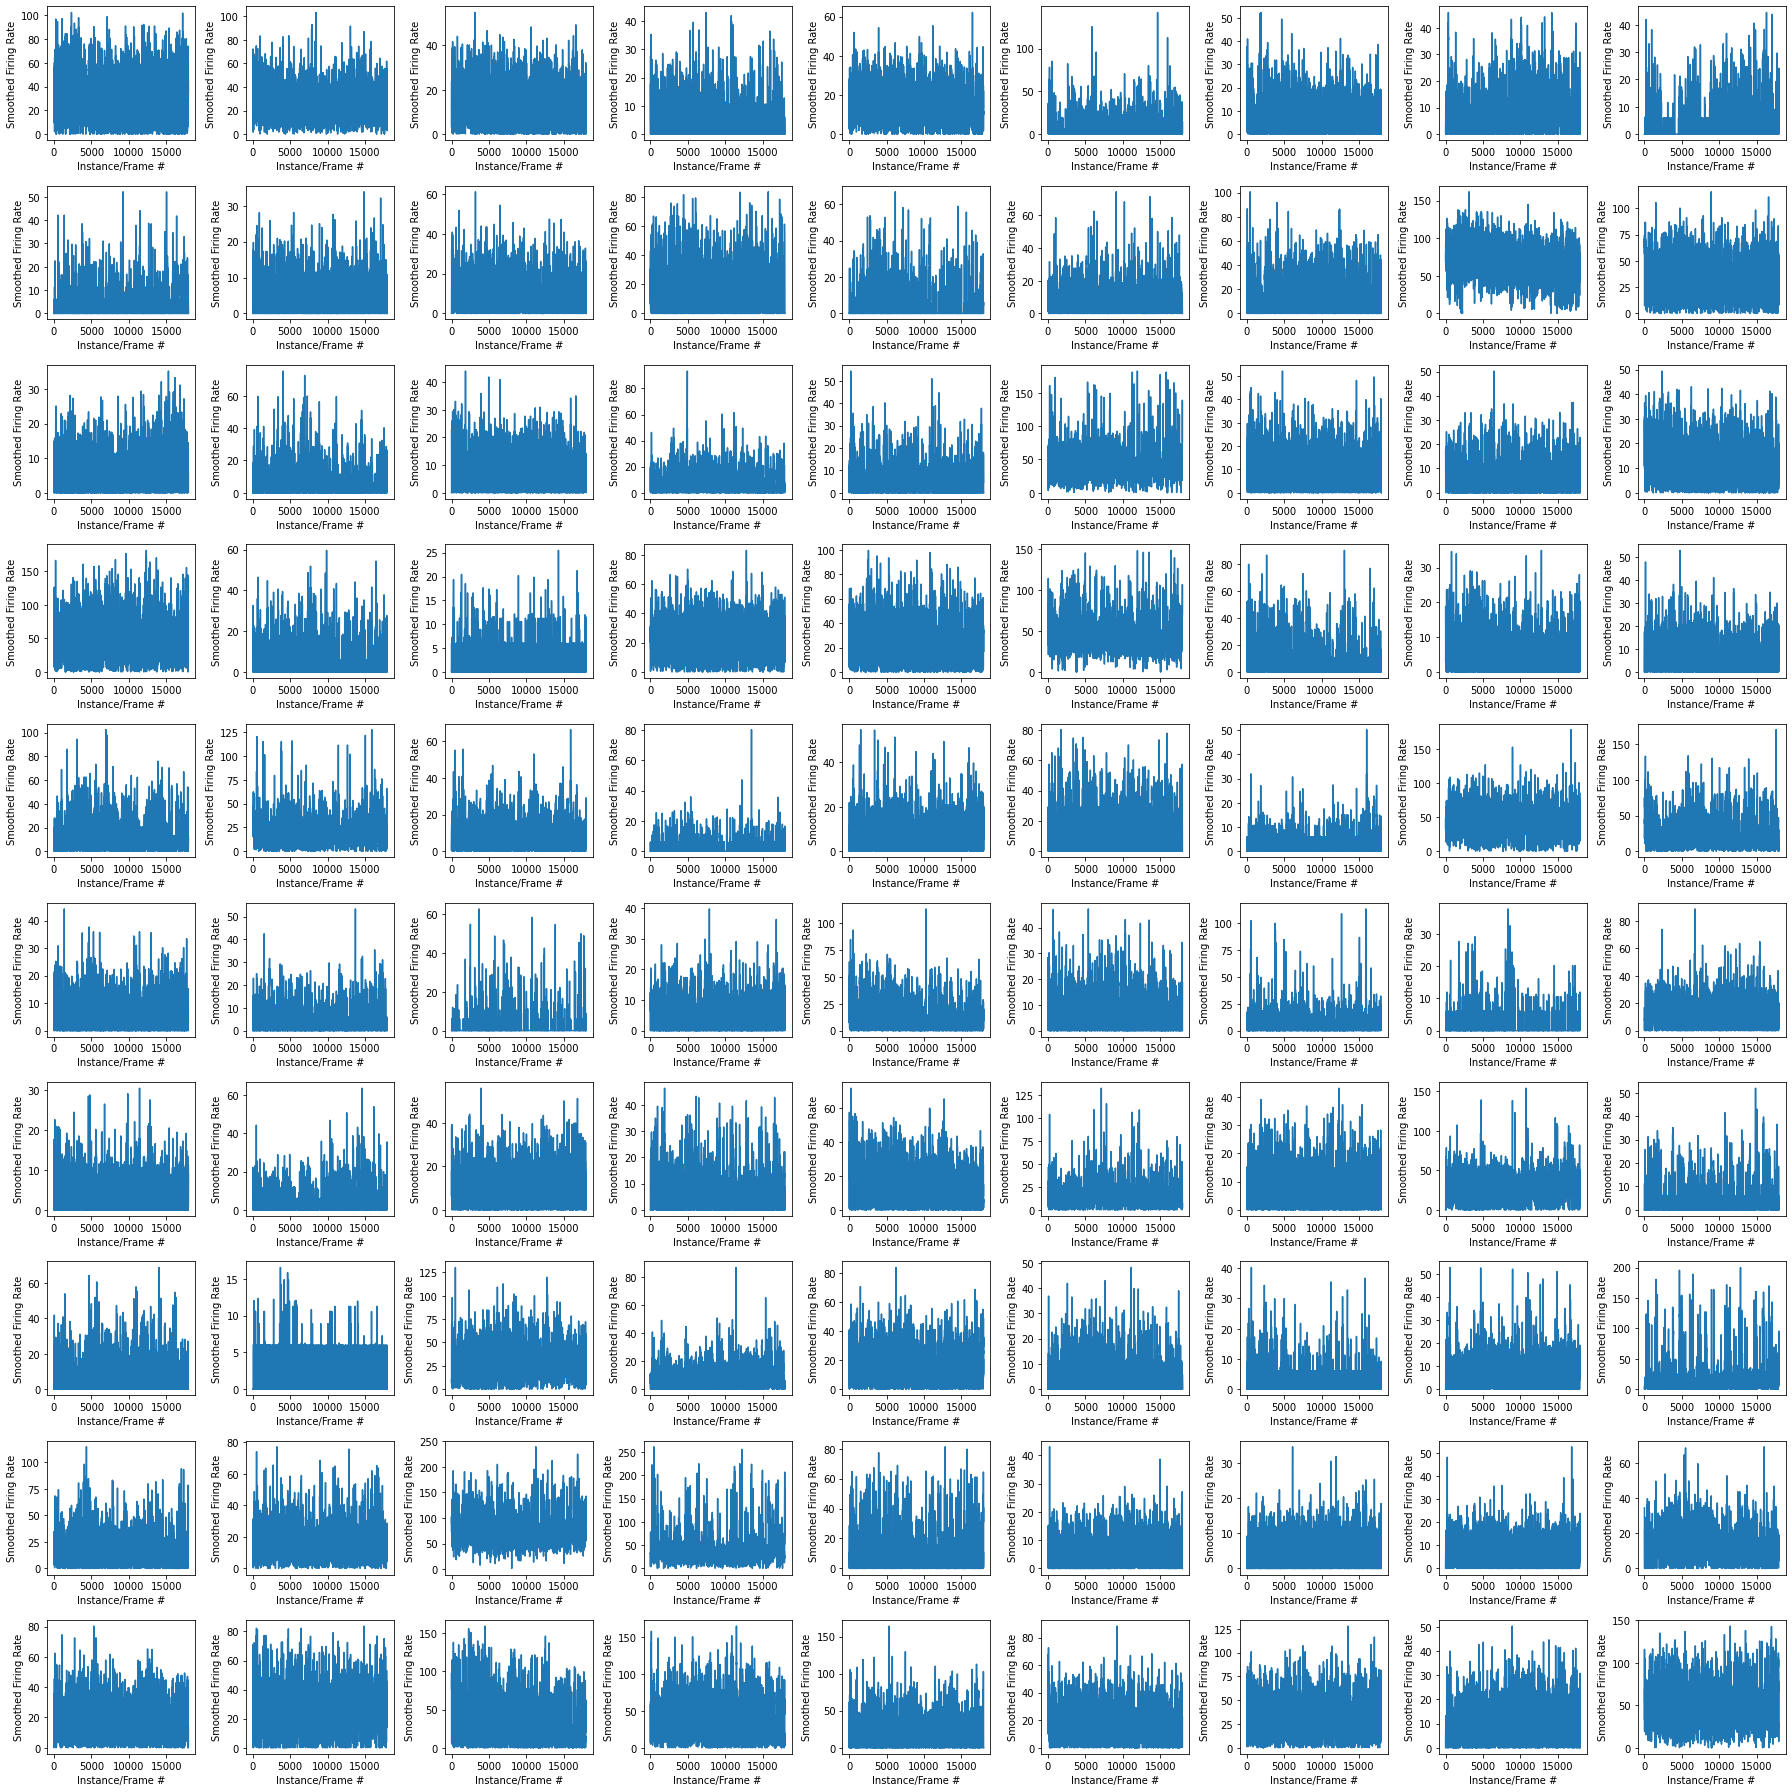

20210814


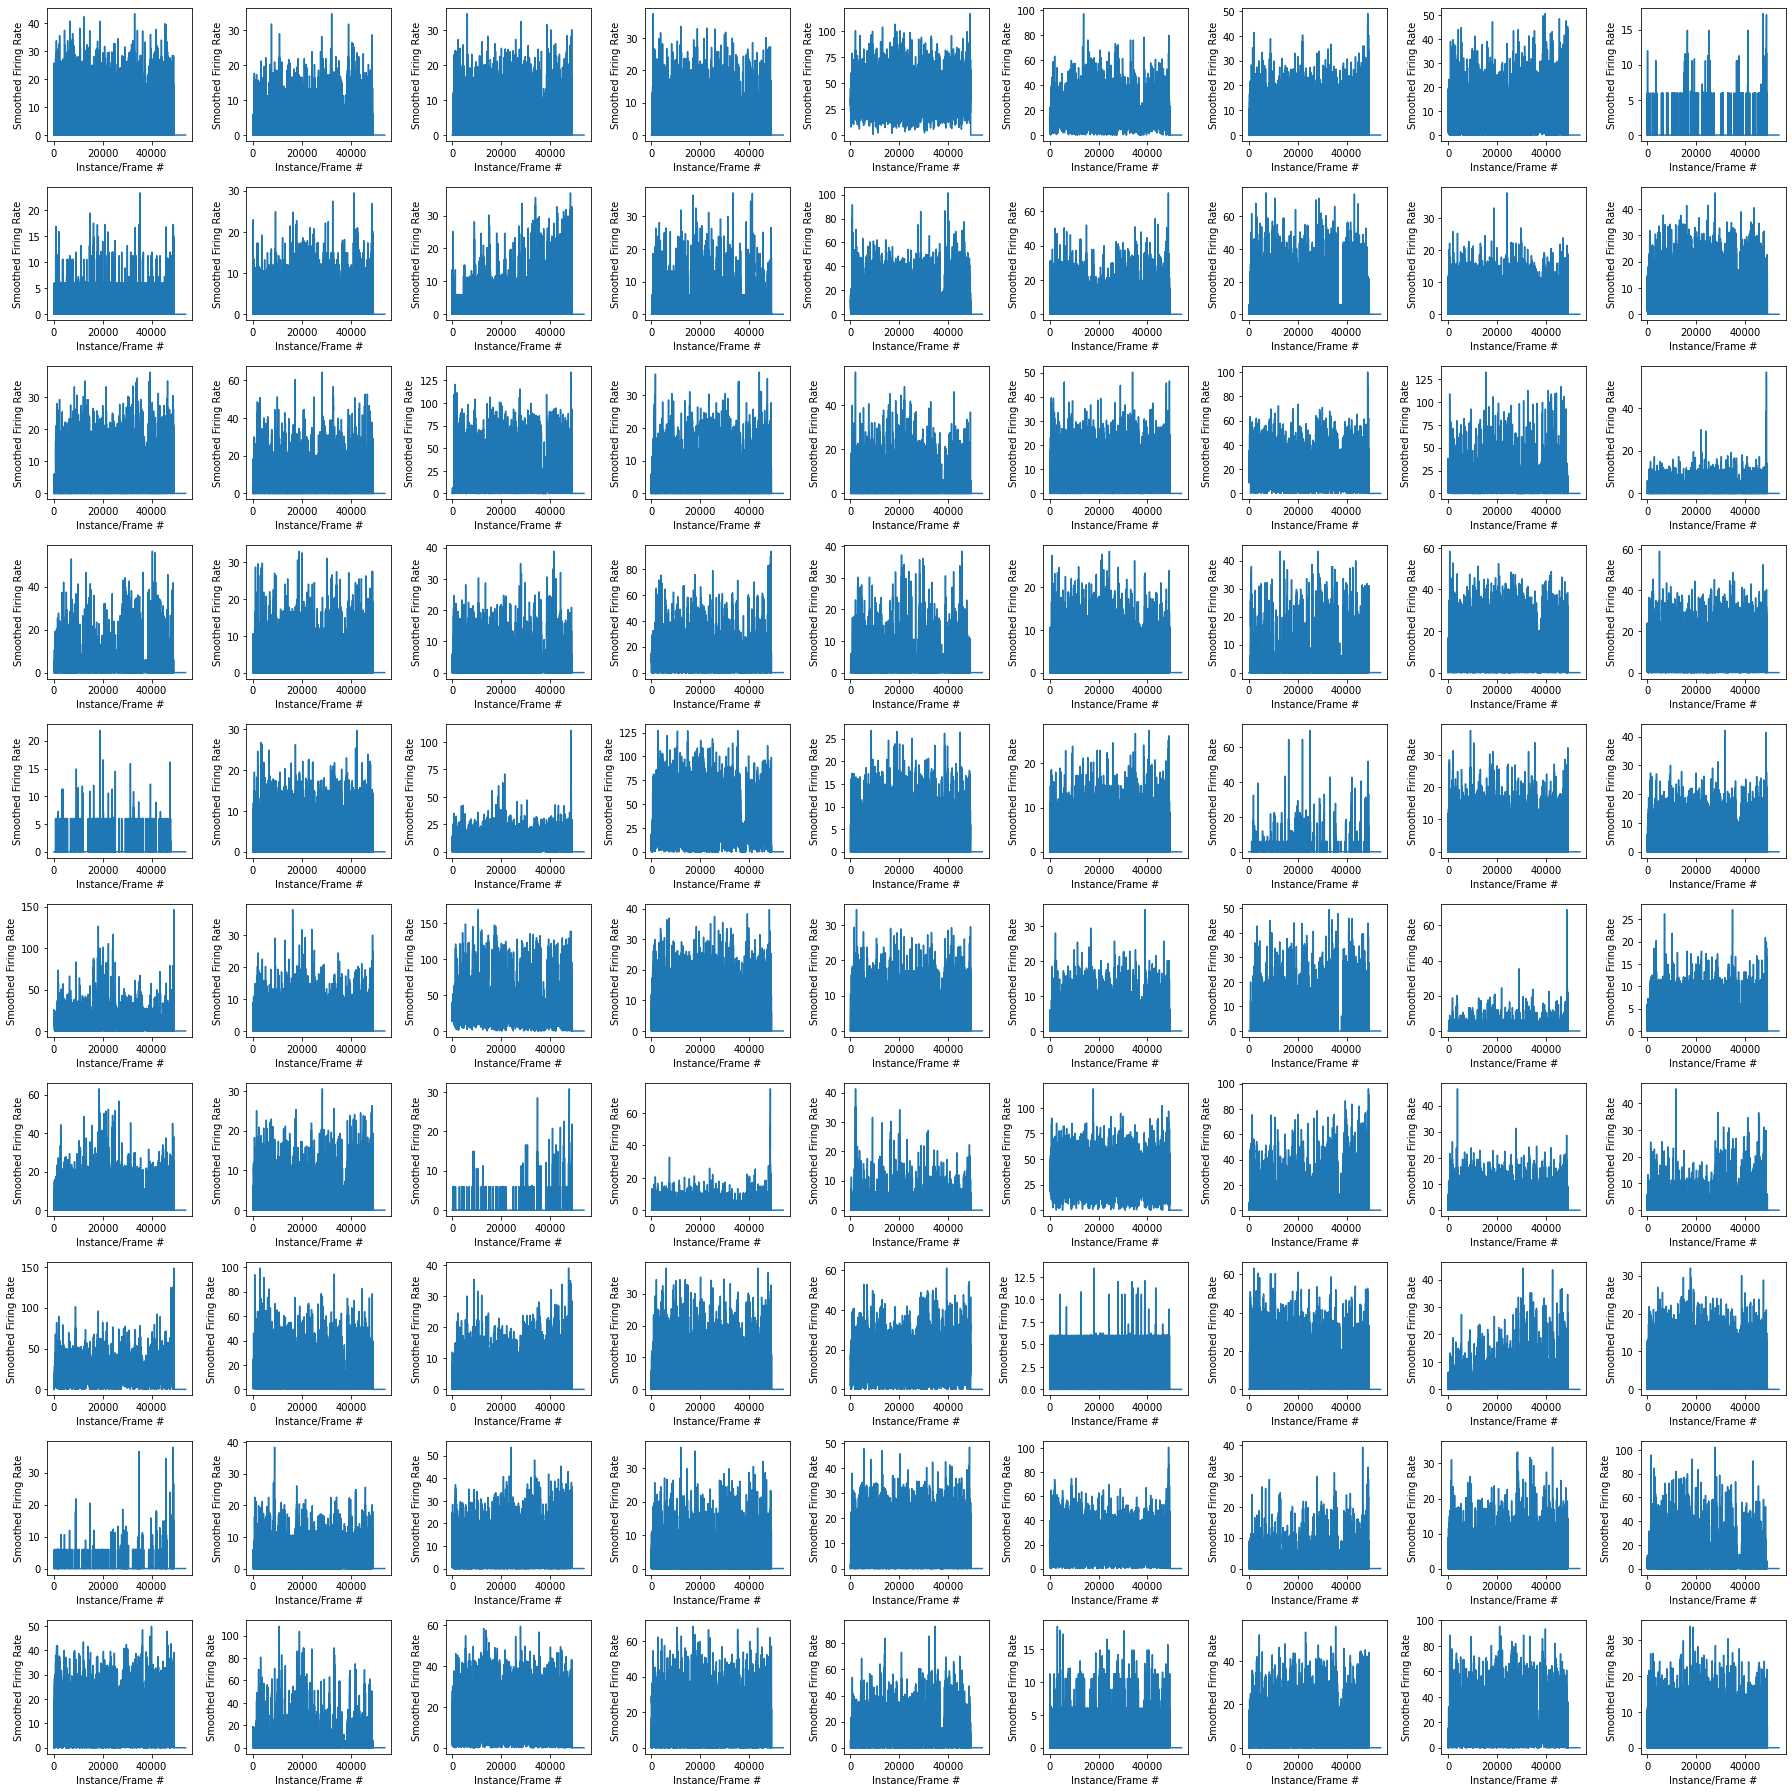

20210710


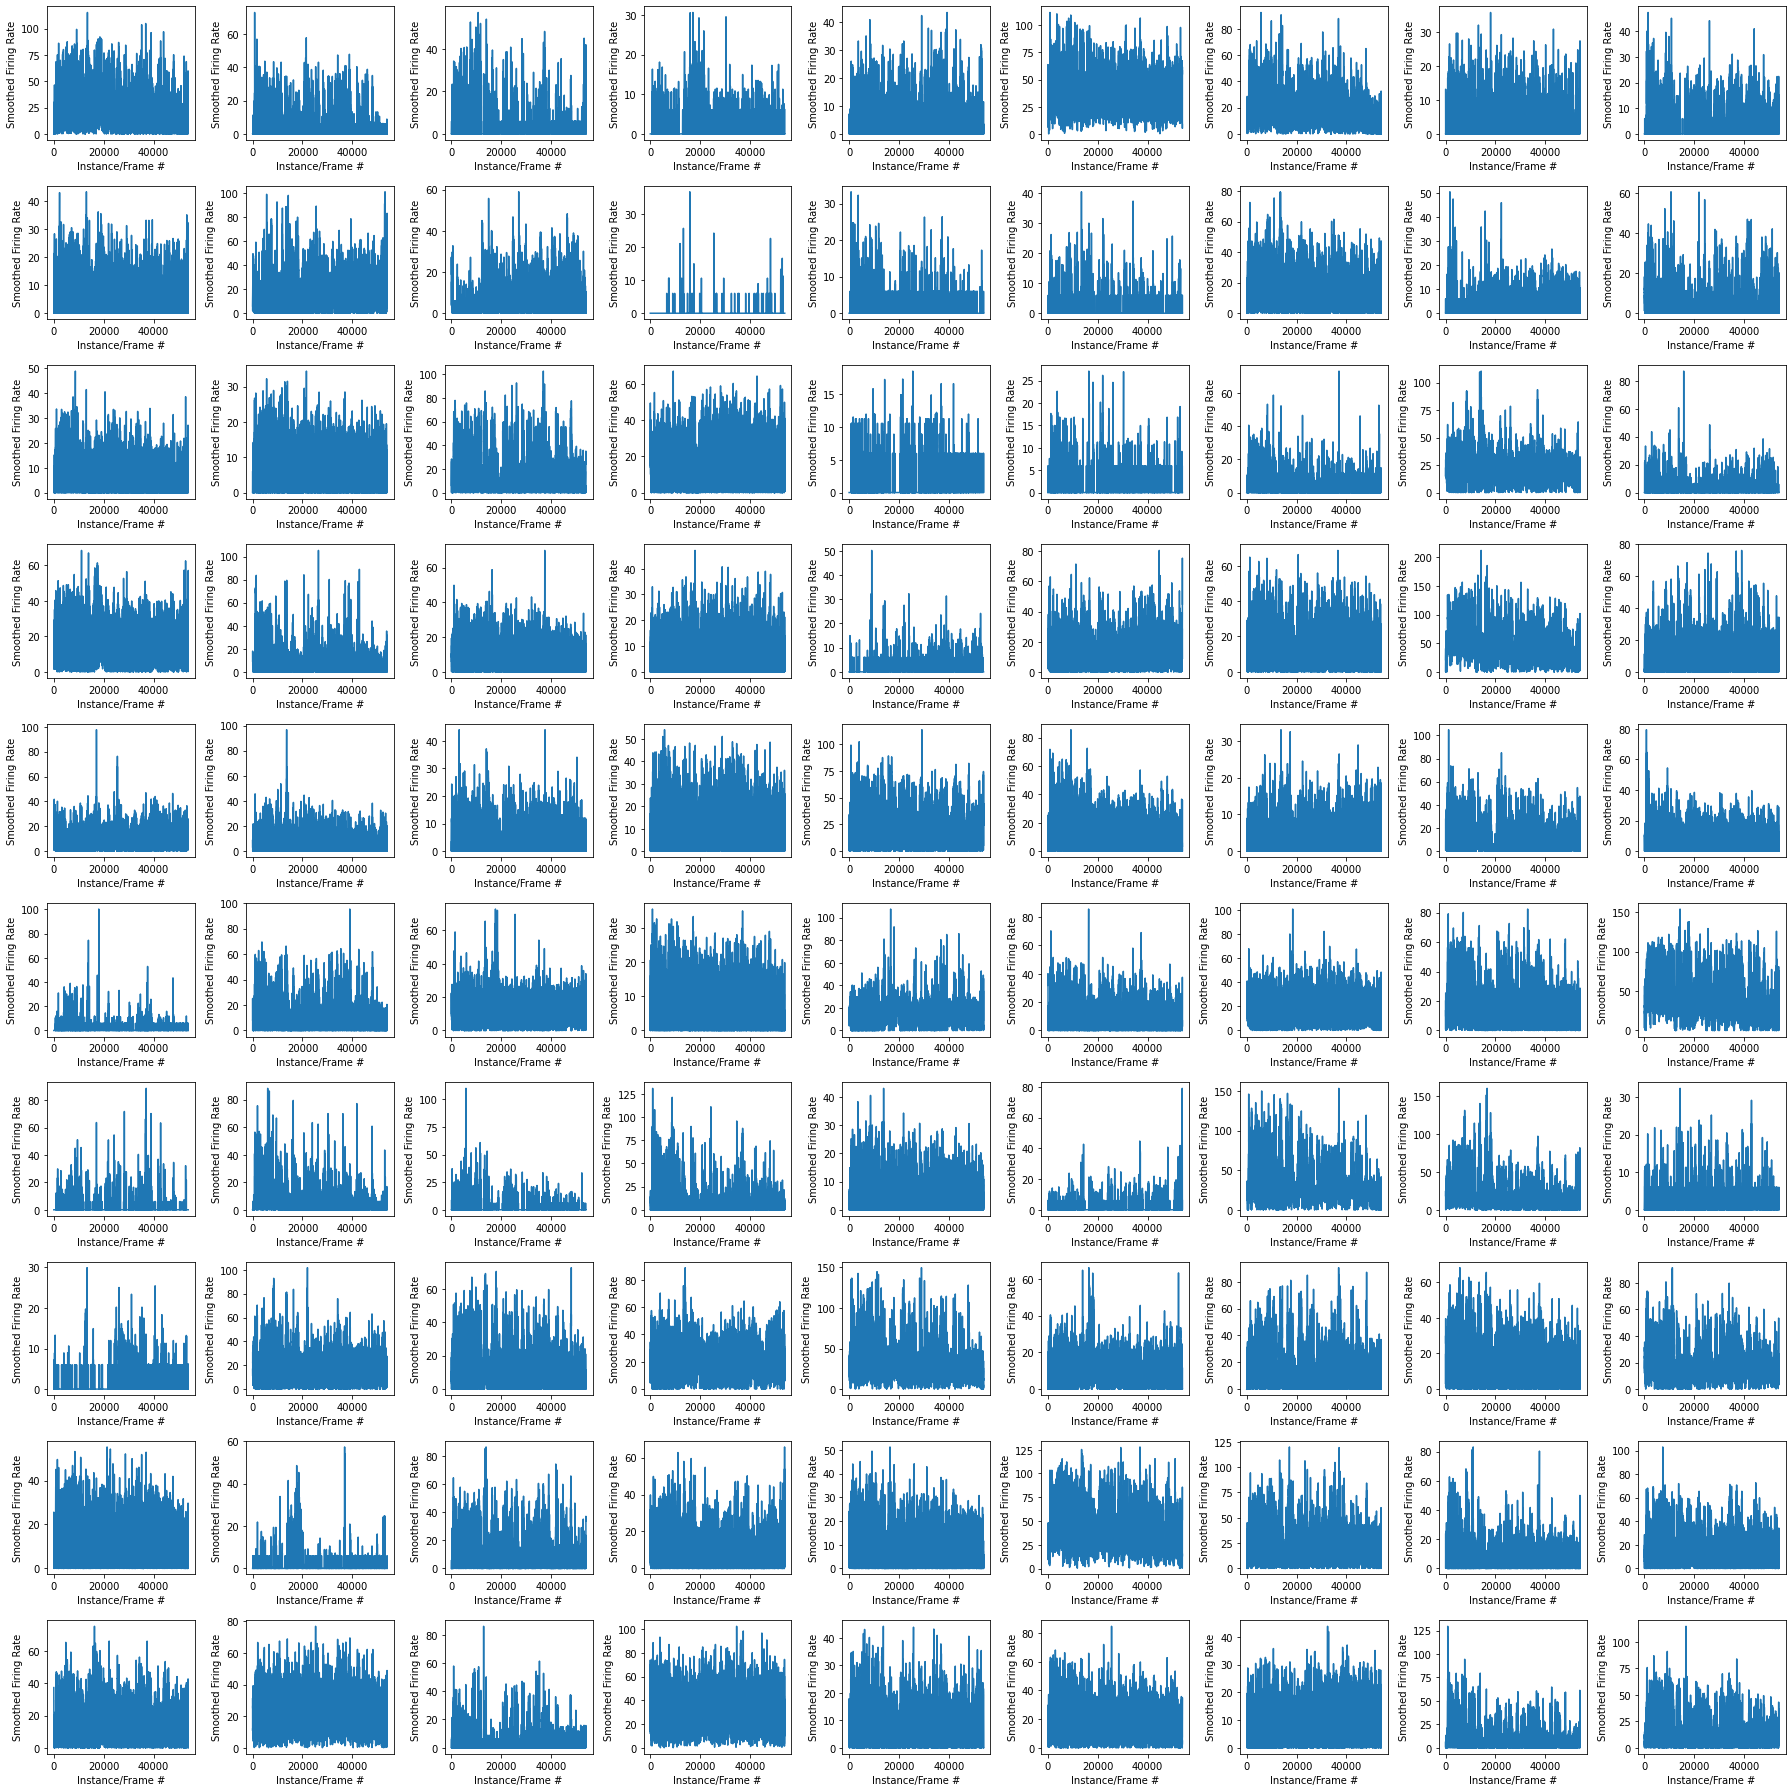

In [ ]:
for date, targ in zip(dates_list, firing_rates_list):
    print(date)
    nrows,ncols=10, 9
    f, ax = plt.subplots(nrows, ncols)
    f.subplots_adjust(top=0.97)
    f.set_size_inches(25, 25)
    for k in range(nrows*ncols):
        i = k-(int(k/ncols)*ncols)
        j = int(k/ncols)
        ax[j][i].plot(targ[:,k])
        ax[j][i].set_xlabel('Instance/Frame #')
        ax[j][i].set_ylabel('Smoothed Firing Rate')
    plt.tight_layout()
    plt.show()

# PCA

20220309, 17969 instances
20210712, 35970 instances
20211105, 35941 instances
20211108, 17970 instances
20210814, 53941 instances
20210710, 53941 instances


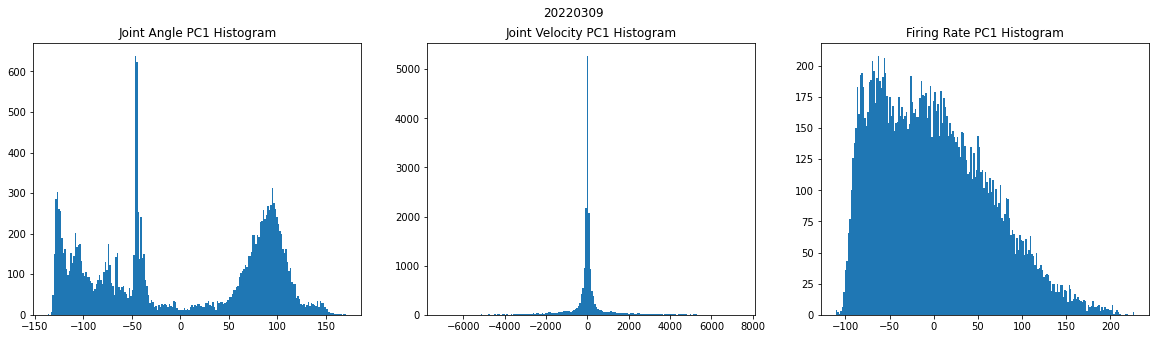

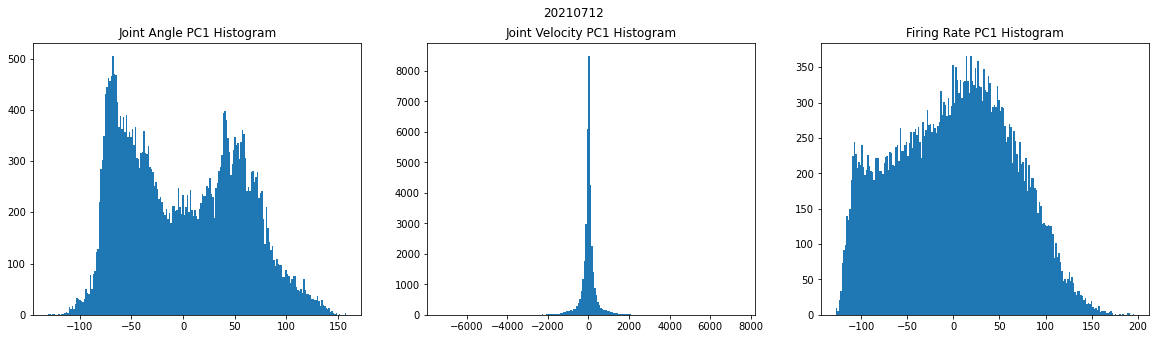

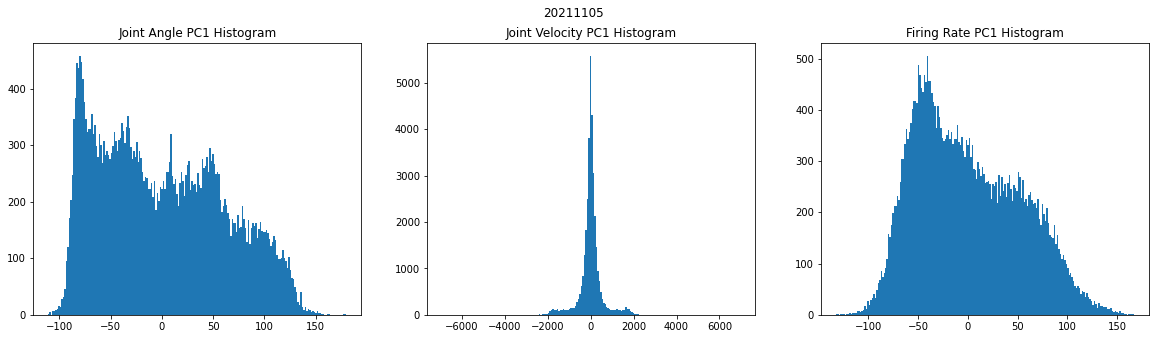

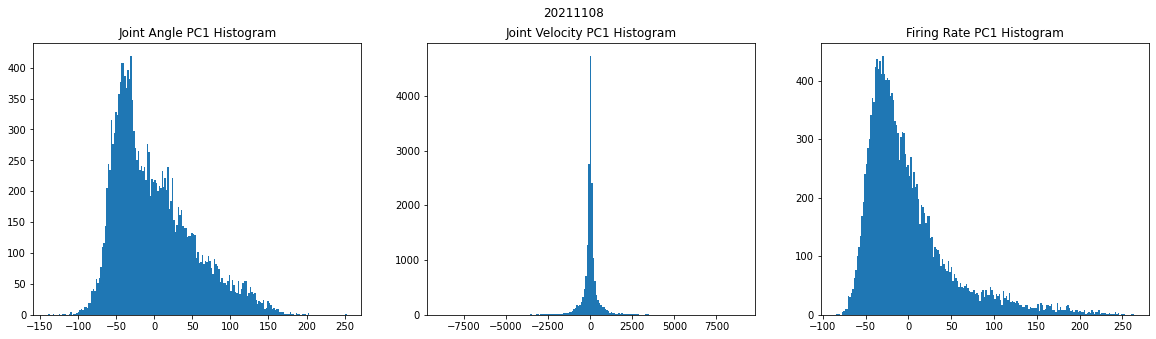

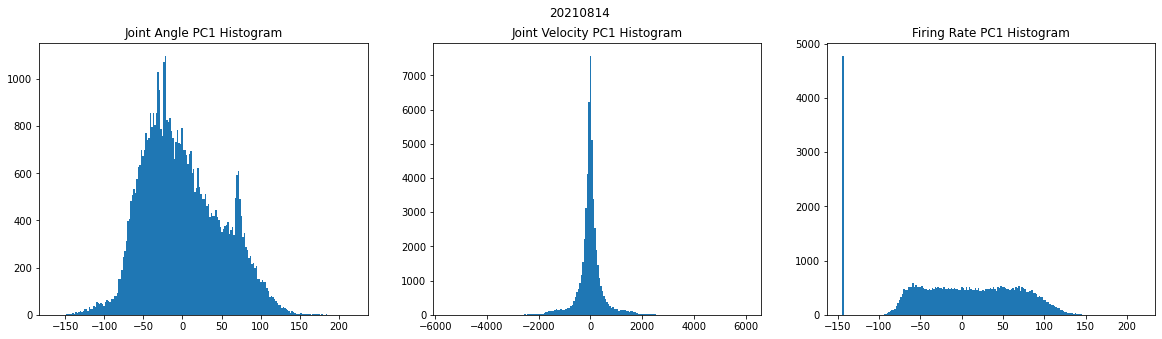

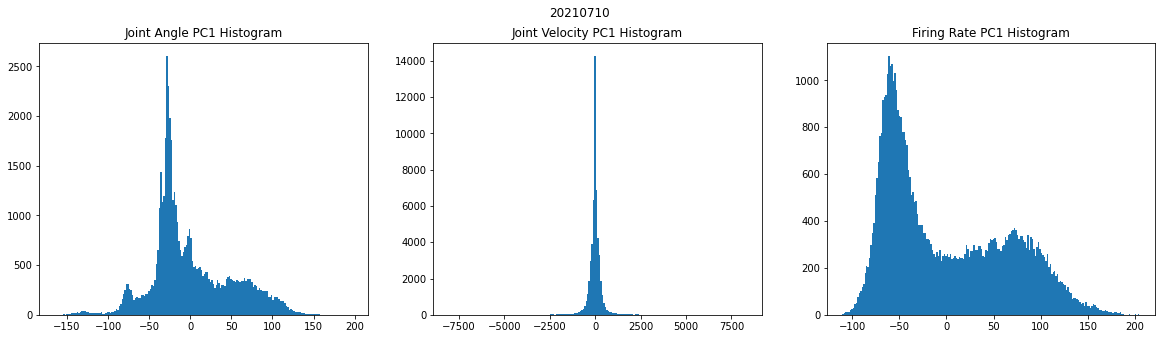

In [ ]:
# Visualize data using PCA
for i, (joint_angles, joint_velocities, firing_rates) in enumerate(zip(joint_angles_list, velocities_list, firing_rates_list)):
    date = dates_list[i]

    num_instances = joint_angles.shape[0]
    print('{}, {} instances'.format(date, num_instances))

    fig, ax = plt.subplots(nrows = 1, ncols = 3)

    # joint_scaler, velocities_scaler, firing_rates_scaler = StandardScaler(),StandardScaler(),StandardScaler()
    # joint_angles_scaled, joint_velocities_scaled, firing_rates_scaled = joint_scaler.fit_transform(joint_angles), velocities_scaler.fit_transform(joint_velocities), firing_rates_scaler.fit_transform(firing_rates)
    
    # m_joints, m_velocities, m_firing = np.mean(joint_angles, axis = 0), np.mean(joint_velocities, axis = 0), np.mean(firing_rates, axis = 0)
    # joint_angles_scaled, joint_velocities_scaled, firing_rates_scaled = joint_angles-m_joints, joint_velocities-m_velocities, firing_rates-m_firing
    joint_angles_scaled, joint_velocities_scaled, firing_rates_scaled = joint_angles, joint_velocities, firing_rates

    pca_joint_angles = PCA(n_components=1)
    pca_joint_velocities = PCA(n_components=1)
    pca_firing_rates = PCA(n_components=1)

    joint_angles_features = pca_joint_angles.fit_transform(joint_angles_scaled)
    joint_velocities_features = pca_joint_velocities.fit_transform(joint_velocities_scaled)
    firing_rates_features = pca_firing_rates.fit_transform(firing_rates_scaled)
    
    fig.set_size_inches(20, 5)
    ax[0].hist(joint_angles_features, bins = 200)
    ax[1].hist(joint_velocities_features, bins = 200)
    ax[2].hist(firing_rates_features, bins = 200)

    fig.suptitle(date)
    ax[0].set_title('Joint Angle PC1 Histogram')
    ax[1].set_title('Joint Velocity PC1 Histogram')
    ax[2].set_title('Firing Rate PC1 Histogram')
    # print(joint_angles_features.shape)

Joint Angles Variance PC1: 0.7081, Joint Angles Variance PC2: 0.0985, Variance PC1+PC2: 0.8066
Joint Velocities Variance PC1: 0.4232, Joint Velocities Variance PC2: 0.2531, Variance PC1+PC2: 0.6763
Firing Rates Variance PC1: 0.38, Firing Rates Variance PC2: 0.1116, Variance PC1+PC2: 0.49160000000000004


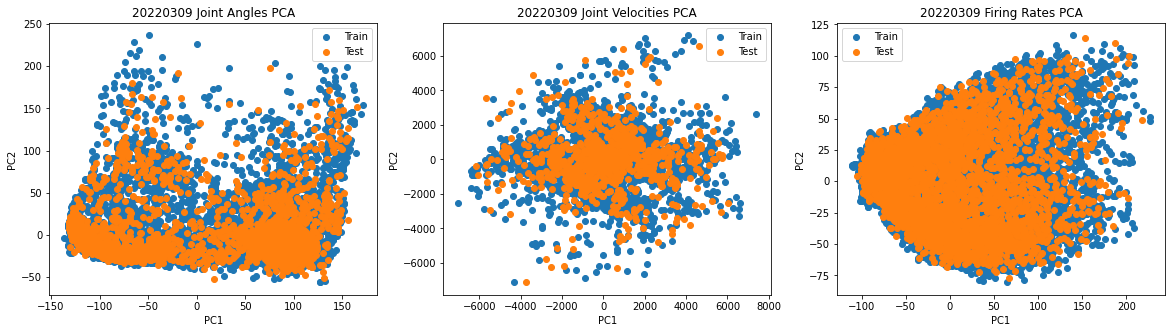



Joint Angles Variance PC1: 0.4462, Joint Angles Variance PC2: 0.2656, Variance PC1+PC2: 0.7118
Joint Velocities Variance PC1: 0.3912, Joint Velocities Variance PC2: 0.1697, Variance PC1+PC2: 0.5609
Firing Rates Variance PC1: 0.1865, Firing Rates Variance PC2: 0.1195, Variance PC1+PC2: 0.306


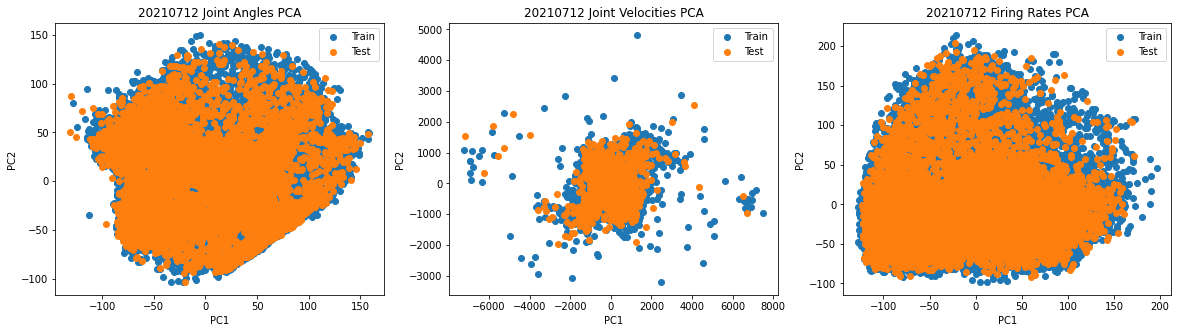



Joint Angles Variance PC1: 0.4745, Joint Angles Variance PC2: 0.1782, Variance PC1+PC2: 0.6527
Joint Velocities Variance PC1: 0.2554, Joint Velocities Variance PC2: 0.2154, Variance PC1+PC2: 0.4708
Firing Rates Variance PC1: 0.2166, Firing Rates Variance PC2: 0.1329, Variance PC1+PC2: 0.3495


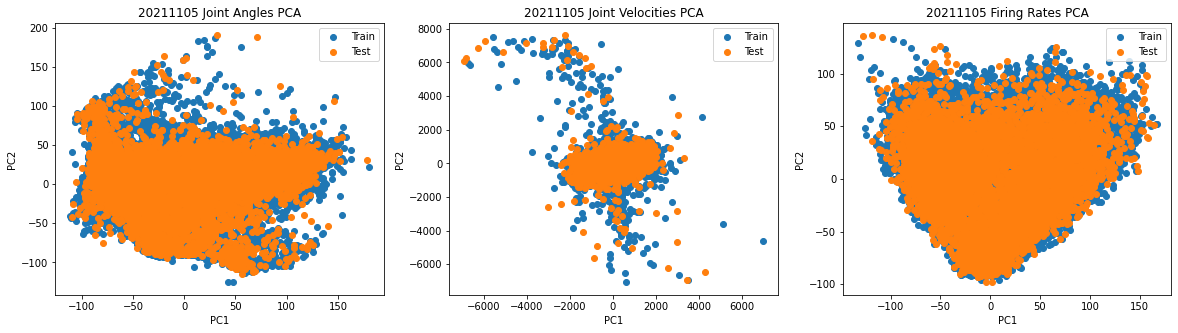



Joint Angles Variance PC1: 0.2704, Joint Angles Variance PC2: 0.1615, Variance PC1+PC2: 0.43189999999999995
Joint Velocities Variance PC1: 0.132, Joint Velocities Variance PC2: 0.1193, Variance PC1+PC2: 0.2513
Firing Rates Variance PC1: 0.1676, Firing Rates Variance PC2: 0.1453, Variance PC1+PC2: 0.3129


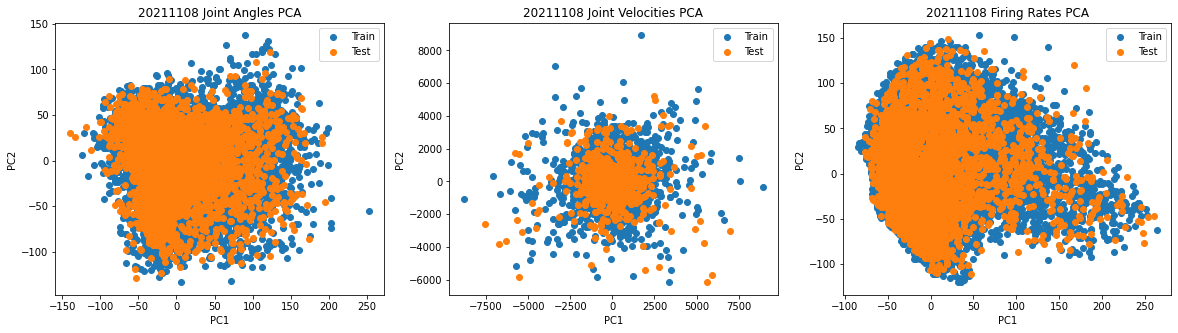



Joint Angles Variance PC1: 0.2837, Joint Angles Variance PC2: 0.2401, Variance PC1+PC2: 0.5238
Joint Velocities Variance PC1: 0.1415, Joint Velocities Variance PC2: 0.1362, Variance PC1+PC2: 0.27769999999999995
Firing Rates Variance PC1: 0.2737, Firing Rates Variance PC2: 0.1497, Variance PC1+PC2: 0.4234


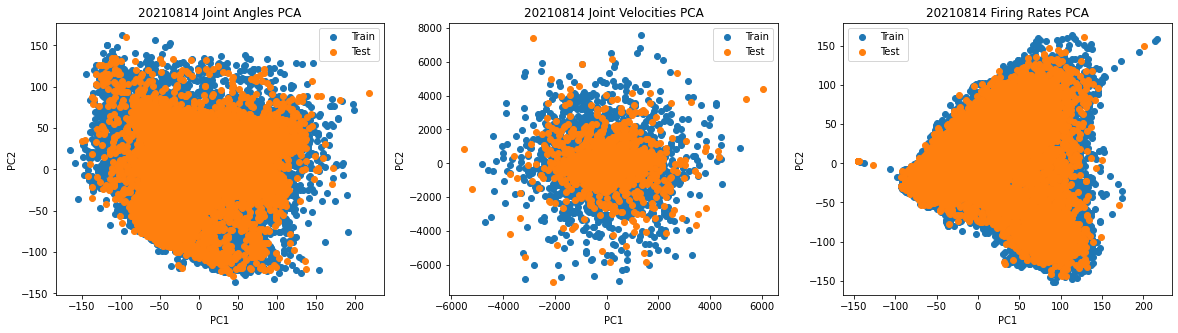



Joint Angles Variance PC1: 0.3385, Joint Angles Variance PC2: 0.2009, Variance PC1+PC2: 0.5394
Joint Velocities Variance PC1: 0.1845, Joint Velocities Variance PC2: 0.1452, Variance PC1+PC2: 0.3297
Firing Rates Variance PC1: 0.2427, Firing Rates Variance PC2: 0.0694, Variance PC1+PC2: 0.3121


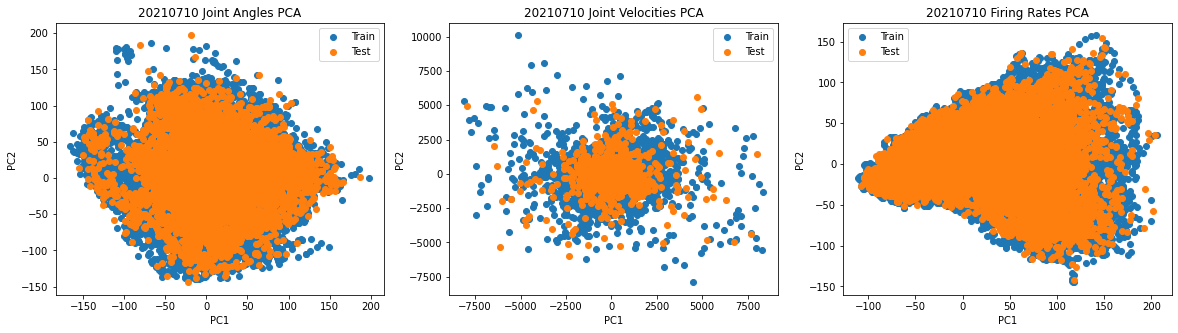

In [ ]:
# Visualize data using PCA
for i, (joint_angles, joint_velocities, firing_rates) in enumerate(zip(joint_angles_list, velocities_list, firing_rates_list)):
    date = dates_list[i]

    # PCA - visualization
    num_instances = joint_angles.shape[0]
    train_split = int(num_instances*.8)
    p = np.random.permutation(num_instances)

    # joint_scaler, velocities_scaler, firing_rates_scaler = StandardScaler(),StandardScaler(),StandardScaler()
    # joint_angles_scaled, joint_velocities_scaled, firing_rates_scaled = joint_scaler.fit_transform(joint_angles), velocities_scaler.fit_transform(joint_velocities), firing_rates_scaler.fit_transform(firing_rates)
    
    m_joints, m_velocities, m_firing = np.mean(joint_angles, axis = 0), np.mean(joint_velocities, axis = 0), np.mean(firing_rates, axis = 0)
    joint_angles_scaled, joint_velocities_scaled, firing_rates_scaled = joint_angles-m_joints, joint_velocities-m_velocities, firing_rates-m_firing

    fig, ax = plt.subplots(nrows = 1, ncols = 3)

    pca_joint_angles = PCA(n_components=2)
    pca_joint_velocities = PCA(n_components=2)
    pca_firing_rates = PCA(n_components=2)

    joint_angles_features = pca_joint_angles.fit_transform(joint_angles_scaled[p])
    joint_velocities_features = pca_joint_velocities.fit_transform(joint_velocities_scaled[p])
    firing_rates_features = pca_firing_rates.fit_transform(firing_rates_scaled[p])
    
    joint_angles_var = pca_joint_angles.explained_variance_ratio_
    joint_velocities_var = pca_joint_velocities.explained_variance_ratio_
    firing_rates_var = pca_firing_rates.explained_variance_ratio_

    pca1_angles_var, pca2_angles_var = round(joint_angles_var[0],4), round(joint_angles_var[1],4)
    pca1_velocities_var, pca2_velocities_var = round(joint_velocities_var[0],4), round(joint_velocities_var[1],4)
    pca1_firing_rates_var, pca2_firing_rates_var = round(firing_rates_var[0],4), round(firing_rates_var[1],4)

    print('Joint Angles Variance PC1: {}, Joint Angles Variance PC2: {}, Variance PC1+PC2: {}'.format(pca1_angles_var, pca2_angles_var, pca1_angles_var+pca2_angles_var))
    print('Joint Velocities Variance PC1: {}, Joint Velocities Variance PC2: {}, Variance PC1+PC2: {}'.format(pca1_velocities_var, pca2_velocities_var, pca1_velocities_var+pca2_velocities_var))
    print('Firing Rates Variance PC1: {}, Firing Rates Variance PC2: {}, Variance PC1+PC2: {}'.format(pca1_firing_rates_var, pca2_firing_rates_var, pca1_firing_rates_var+pca2_firing_rates_var))
    
    fig.set_size_inches(20, 5)
    ax[0].scatter(joint_angles_features[:train_split,0], joint_angles_features[:train_split,1], label='Train')
    ax[0].scatter(joint_angles_features[train_split:,0], joint_angles_features[train_split:,1], label='Test')

    ax[1].scatter(joint_velocities_features[:train_split,0], joint_velocities_features[:train_split,1],label='Train')
    ax[1].scatter(joint_velocities_features[train_split:,0], joint_velocities_features[train_split:,1], label='Test')

    ax[2].scatter(firing_rates_features[:train_split,0], firing_rates_features[:train_split,1],label='Train')
    ax[2].scatter(firing_rates_features[train_split:,0], firing_rates_features[train_split:,1], label='Test')
    
    ax[0].set_xlabel('PC1')
    ax[0].set_ylabel('PC2')
    ax[1].set_xlabel('PC1')
    ax[1].set_ylabel('PC2')
    ax[2].set_xlabel('PC1')
    ax[2].set_ylabel('PC2')

    ax[0].set_title('{} Joint Angles PCA'.format(date))
    ax[1].set_title('{} Joint Velocities PCA'.format(date))
    ax[2].set_title('{} Firing Rates PCA'.format(date))

    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

    plt.show()
    print('\n')

# Building Dataloader

In [ ]:
class OSIMDataset(Dataset):
    def __init__(self, date, inp_type, good_range, split_neurons = False, split_num = 0, shuffle = False):
        self.date = date
        self.inp_type = inp_type
        inp_types = ['Joint Angles','Joint Velocities','Joint Angles and Velocities']
        if inp_type == 'Joint Angles':
            input = joint_angles_dict[date]
        elif inp_type == 'Joint Velocities':
            input = velocities_dict[date]
        elif inp_type == 'Joint Angles and Velocities':
            input = angles_and_velocities_dict[date]
        else:
            print('Invalid Input Type')
            assert inp_type in inp_types
        if split_neurons == False:
            neuraldata = firing_rates_dict[date]
        else:
            neuraldata = firing_rates_dict_split[date][split_num]
            self.split_num = split_num
            
        self.inputs = input
        self.input_type = inp_type
        self.input_dim = self.inputs.shape[-1]
        self.num_neural_units = neuraldata.shape[-1]
        self.neuraloutputs = neuraldata
        self.sample_nums = np.arange(len(self.inputs))
        self.inputs = np.delete(self.inputs, np.arange(good_range[0],good_range[1]), 0)
        self.neuraloutputs = np.delete(self.neuraloutputs, np.arange(good_range[0],good_range[1]), 0)

        def shuffle_data(inputs, targets, samp_nums):
            assert len(inputs) == len(targets)
            p = np.random.permutation(len(inputs))
            return(inputs[p], targets[p], samp_nums[p])

        if shuffle == True:
            self.inputs, self.neuraloutputs, self.sample_nums = \
              shuffle_data(self.inputs, self.neuraloutputs, self.sample_nums)

    def __len__(self):
        assert len(self.inputs) == len(self.neuraloutputs)
        return len(self.inputs)

    def __getitem__(self, idx):
        input = torch.from_numpy(self.inputs[idx])
        neuraloutput = torch.from_numpy(self.neuraloutputs[idx])
        sample_num = self.sample_nums[idx]
        return input.float(), neuraloutput.float(), sample_num

In [ ]:
def create_and_save_datasets(dataset, tcnn = False, instance_length = 100, split_neurons = False, split_num = 0, restraint_type = 'fullyrestrained'):
    num_instances = len(dataset)
    train_split = int(num_instances*0.8)

    osim_train_dataset = Subset(dataset, np.arange(num_instances)[:train_split])
    osim_test_dataset = Subset(dataset, np.arange(num_instances)[train_split:])

    base_dir = '/content/drive/My Drive/Miller_Lab/FIU/PopFRData/processed_shuffled_opensim_datasets/'
    if tcnn == True:
        base_dir = '/content/drive/My Drive/Miller_Lab/FIU/PopFRData/tcnn_processed_shuffled_opensim_datasets/instance_length_{}'.format(instance_length)
    full_dir = os.path.join(base_dir,dataset.date,dataset.input_type)
    if ((tcnn == True) and (split_neurons == True)):
        base_dir = '/content/drive/My Drive/Miller_Lab/FIU/PopFRData/tcnn_processed_shuffled_opensim_datasets_splitneurons/instance_length_{}/{}'.format(instance_length,restraint_type)
        full_dir = os.path.join(base_dir,dataset.date,dataset.input_type,str(split_num))
    if ((tcnn == False) and (split_neurons == True)):
        base_dir = '/content/drive/My Drive/Miller_Lab/FIU/PopFRData/processed_shuffled_opensim_datasets_splitneurons/{}'.format(restraint_type)
        full_dir = os.path.join(base_dir,dataset.date,dataset.input_type,str(split_num))

    if os.path.exists(full_dir) == False:
        os.makedirs(full_dir)
        torch.save(dataset, os.path.join(full_dir,'Full.pt'))
        torch.save(osim_train_dataset, os.path.join(full_dir,'Train.pt'))
        torch.save(osim_test_dataset, os.path.join(full_dir,'Test.pt'))

In [ ]:
def load_datasets(base_dir, new_tcnn = False):
    dataset_dict = {}
    for date in os.listdir(base_dir):
        dataset_dict[date] = {}
        for inp_type in os.listdir(os.path.join(base_dir,date)):
            dataset_dict[date][inp_type] = {}
            for dataset_type in os.listdir(os.path.join(base_dir,date,inp_type)):
                if new_tcnn == False:
                    dataset_dict[date][inp_type][dataset_type[:-3]] = torch.load(os.path.join(base_dir,date,inp_type,dataset_type))
                else:
                    for kinematic_signal_length in os.listdir(os.path.join(base_dir,date,inp_type)):
                        dataset_dict[date][inp_type][kinematic_signal_length] = {}
                        for dataset_type in os.listdir(os.path.join(base_dir,date,inp_type,str(kinematic_signal_length))):
                            dataset_dict[date][inp_type][kinematic_signal_length][dataset_type[:-3]] = torch.load(os.path.join(base_dir,date,inp_type,str(kinematic_signal_length),dataset_type))
    return dataset_dict

In [ ]:
def get_loaders(dataset_dict, batch_size, new_tcnn = False):
    loader_dict = {}
    for date in dataset_dict:
        loader_dict[date] = {}
        for inp_type in dataset_dict[date]:
            loader_dict[date][inp_type] = {}
            if new_tcnn == False:
                for dataset_type in dataset_dict[date][inp_type]:
                    loader = torch.utils.data.DataLoader(dataset_dict[date][inp_type][dataset_type], batch_size=batch_size, pin_memory=True, sampler=None)
                    loader_dict[date][inp_type][dataset_type] = loader
            else:
                for kinematic_signal_length in dataset_dict[date][inp_type]:
                    loader_dict[date][inp_type][kinematic_signal_length] = {}
                    for dataset_type in dataset_dict[date][inp_type][kinematic_signal_length]:
                        loader = torch.utils.data.DataLoader(dataset_dict[date][inp_type][kinematic_signal_length][dataset_type], batch_size=batch_size, pin_memory=True, sampler=None)
                        loader_dict[date][inp_type][kinematic_signal_length][dataset_type] = loader
    return loader_dict

In [ ]:
def convert_osim_dataset_to_array(dataset):
    inp_list = []
    out_list = []
    for i in range(len(dataset)):
        inp, out = dataset[i][0], dataset[i][1]
        inp_list.append(inp)
        out_list.append(out)
    return(np.vstack(inp_list), np.vstack(out_list))

In [ ]:
joint_angles_dict.keys()

dict_keys(['20211108', '20210830', '20210921', '20211009'])

In [ ]:
inp_types = ['Joint Angles']
# for date in joint_angles_dict.keys():
for date in ['20210830']:
    for inp_type in inp_types:
        good_range = good_frates_range_dict[date]
        dataset = OSIMDataset(date, inp_type, good_range, shuffle = True)
        create_and_save_datasets(dataset, 'semirestrained')

In [ ]:
inp_types = ['Joint Angles']
for date in joint_angles_dict.keys():
    print(date)
    for inp_type in inp_types:
        for split_num in [0,1,2]:
            dataset = OSIMDataset(date, inp_type, good_frates_range_dict[date], split_neurons = True, split_num = split_num, shuffle = True)
            create_and_save_datasets(dataset, tcnn = False, split_neurons = True, split_num = split_num, restraint_type = 'semirestrained')

20211108
20210830
20210921
20211009


In [ ]:
dataset_dict = load_datasets('/content/drive/My Drive/Miller_Lab/FIU/PopFRData/processed_shuffled_opensim_datasets/semirestrained/')
loader_dict = get_loaders(dataset_dict, 32)

In [ ]:
for date in dataset_dict.keys():
    print(date, len(dataset_dict[date]['Joint Angles']['Full']),\
          dataset_dict[date]['Joint Angles']['Full'][0][0].shape,\
          dataset_dict[date]['Joint Angles']['Full'][0][1].shape)

20211108 17370 torch.Size([24]) torch.Size([93])
20210921 35341 torch.Size([24]) torch.Size([123])
20211009 35341 torch.Size([24]) torch.Size([119])
20210830 33541 torch.Size([24]) torch.Size([114])


# Model and Training

In [ ]:
class FCNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, hidden_layer_dim, add_relu = False):
        super(FCNet, self).__init__()
        self.name = 'Multi-Layer Perceptron'
        self.net = nn.ModuleList()
        assert num_layers >= 2
        self.num_layers = num_layers
        self.hidden_layer_dim = hidden_layer_dim

        if type(hidden_layer_dim == int):
            # input layer
            self.net.append(nn.Linear(input_dim, hidden_layer_dim))
            self.net.append(nn.ReLU())
            # hidden layers
            for i in range(num_layers-2):
                self.net.append(nn.Linear(hidden_layer_dim, hidden_layer_dim))
                self.net.append(nn.ReLU())
            # output layer
            self.net.append(nn.Linear(hidden_layer_dim, output_dim))
            if add_relu == True:
                self.net.append(nn.ReLU())
        
        elif type(hidden_layer_dim == list):
            assert len(hidden_layer_dim) == num_layers-1

            self.net.append(nn.Linear(input_dim, hidden_layer_dim[0]))
            self.net.append(nn.ReLU())
            for i in range(len(hidden_layer_dim)-1):
                self.net.append(nn.Linear(hidden_layer_dim[i], hidden_layer_dim[i+1]))
                self.net.append(nn.ReLU())
            self.net.append(nn.Linear(hidden_layer_dim[-1], output_dim))
    
    def forward(self, x):
        for layer in self.net:
            x = layer(x)
        return(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_pr2(real_data, pred, lam = 0, EPS = 0.000001, return_electrodes = False):
    predictions = np.copy(pred)
    predictions[predictions==0]=EPS
    m = np.mean(real_data, axis = 0) #average for each neuron across all instances
    m[m==0]=EPS

    d1 = real_data/predictions #element-wise division
    d2 = real_data/m
    d1[d1==0]=EPS
    d2[d2==0]=EPS

    if (((d1<0).any()) or ((d2<0).any())):
        return(np.nan)
    else:
        a1=(real_data*np.log(d1))-(real_data-predictions)
        a2=(real_data*np.log(d2))-(real_data-m)
        sum1 = np.sum(a1, axis = 0) #sum across instances
        sum2 = np.sum(a2, axis = 0) #sum across instances

        sum2[sum2==0]=EPS
        pR2 = 1 - (sum1/sum2)
        if return_electrodes == False:
            return(np.mean(pR2))
        else:
            return(pR2)

def train(loader, model, optimizer, criterion, scheduler, conv = False):
    model.train()
    batch_losses = []

    for i, (input, target, sample_num) in enumerate(loader):
        optimizer.zero_grad() #clear gradient
        input = input.to(device, dtype=torch.float)
        target = target.to(device, dtype=torch.float)
        
        pred = model(input)
        loss = criterion(pred, target)  # calculate loss
        mean_batch_loss = loss.item()
        batch_losses.append(mean_batch_loss)

        loss.backward()  # one backward pass
        # scheduler.step(loss)
        optimizer.step()  # update the parameters

    avg_loss_epoch = sum(batch_losses)/len(batch_losses)
    return(avg_loss_epoch)

def test(loader, model, optimizer, criterion, num_neural_units, conv = False):
    model.eval()
    batch_losses = []
    pred_tot = []
    output_tot = []

    with torch.no_grad():
        for i, (input, target, sample_num) in enumerate(loader):
            input = input.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.float)
            pred = model(input)

            loss = criterion(pred, target)  
            mean_batch_loss = loss.item()
            batch_losses.append(mean_batch_loss)
            
            pred_tot += pred
            output_tot += target

    avg_loss_epoch = sum(batch_losses)/len(batch_losses)
    pred_tot = torch.stack(pred_tot).detach().numpy()
    output_tot = torch.stack(output_tot).detach().numpy()
    if conv == True:
        pred_tot = pred_tot.reshape(-1,num_neural_units)
        output_tot = output_tot.reshape(-1,num_neural_units)
    r2_tot_batch = r2_score(output_tot, pred_tot, multioutput='variance_weighted')
    pr2_tot_batch = get_pr2(output_tot, pred_tot)
    
    return(avg_loss_epoch, r2_tot_batch, pr2_tot_batch, pred_tot, output_tot)

def get_instance_losses(loader, model, criterion = torch.nn.MSELoss(reduction='none')):
    model.eval()
    inputs = []
    targets = []
    preds = []
    sample_nums = []
    losses = []

    with torch.no_grad():
        for i, (input, target, sample_num) in enumerate(loader):
            input = input.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.float)

            pred = model(input)
            all_losses_batch = criterion(pred, target)  # calculate loss
            all_losses_batch = all_losses_batch.detach().cpu().data.numpy()
            
            inputs.append(input.cpu().data.numpy())
            targets.append(target.cpu().data.numpy())
            sample_nums.append(sample_num)
            preds.append(pred)
            losses.append(all_losses_batch)

    all_inputs = np.vstack(inputs)
    all_targets = np.vstack(targets)
    all_preds = np.vstack(preds)
    all_sample_nums = np.hstack(sample_nums)
    all_losses = np.vstack(losses)
    all_losses = np.mean(all_losses, axis = 1)

    all_data = [all_losses, all_inputs, all_targets, all_preds, all_sample_nums]
    return(all_data)

In [ ]:
def plot_targets_and_preds(targets, preds, rng, electrodes_list, fig_shape):
    nrows,ncols=fig_shape[0], fig_shape[1]
    assert len(electrodes_list) == nrows*ncols
    f, ax = plt.subplots(nrows, ncols)
    f.subplots_adjust(top=1.2)
    f.set_size_inches(40, 20)
    t = nrows*ncols
    for k in range(len(electrodes_list)):
        ax[k].plot(targets[:rng,electrodes_list[k]], label = 'Target')
        ax[k].plot(preds[:rng,electrodes_list[k]], label = 'Prediction')
        ax[k].set_xlabel('Frame/Instance #')
        ax[k].set_ylabel('Smoothed Firing Rates')
        ax[k].set_title('Electrode {}'.format(electrodes_list[k]))
        ax[k].legend()
    plt.show()

# MLP

In [ ]:
def plot_top_5_electrodes(model, good_inp, good_out):
    with torch.no_grad():
        pred_good_section = model(torch.from_numpy(good_inp).float())
        output_good_section = torch.from_numpy(good_out).float()
        plot_targets_and_preds(output_good_section, pred_good_section, 600, electrodes_list = [18, 32, 57, 58, 78], fig_shape = (5,1))

In [ ]:
def calc_kld(P,Q):
    kld = (P * np.log(P / Q)).sum()
    return kld

In [ ]:
def plot_distributions(model, train_dataset, test_dataset, nrows=12, ncols=8, bins = 20):
    train_inp, train_out = convert_osim_dataset_to_array(train_dataset)
    test_inp, test_out = convert_osim_dataset_to_array(test_dataset)
    preds_dist = []
    with torch.no_grad():
        train_preds = model(torch.from_numpy(train_inp).float())
        test_preds = model(torch.from_numpy(test_inp).float())

        kld_loss = torch.nn.KLDivLoss()
        kld_train_list = []
        kld_test_list = []
        f, ax = plt.subplots(nrows, ncols)
        f.subplots_adjust(top=0.97)
        f.set_size_inches(25, 25)
        f2, ax2 = plt.subplots(nrows, ncols)
        f2.subplots_adjust(top=0.97)
        f2.set_size_inches(25, 25)
        x = 4
        for i in range(train_out.shape[1]):#train_out.shape[1]
            assert train_out[:,i].shape == train_preds[:,i].shape
            assert test_out[:,i].shape == test_preds[:,i].shape

            k = i-(int(i/ncols)*ncols)
            j = int(i/ncols)
            train_target_dist = ax[j][k].hist(train_out[:,i], bins = bins, alpha = 0.4, label = 'Targets')[0]/len(train_out[:,i])
            train_pred_dist = ax[j][k].hist(train_preds[:,i], bins = bins, alpha = 0.4, label = 'Predictions')[0]/len(train_preds[:,i])
            ax[j][k].legend()
            plt.tight_layout()
            test_target_dist = ax2[j][k].hist(test_out[:,i], bins = bins, alpha = 0.4, label = 'Targets')[0]/len(test_out[:,i])
            test_pred_dist = ax2[j][k].hist(test_preds[:,i], bins = bins, alpha = 0.4, label = 'Predictions')[0]/len(test_preds[:,i])
            ax2[j][k].legend()
            plt.tight_layout()

        plt.show()
        return(train_target_dist, train_pred_dist, test_target_dist, test_pred_dist)

In [ ]:
def plot_losses_MLP(dataset, train_loader, test_loader, learning_rate, num_layers, restraint_type, add_relu = False, adapt_lr = True, save = True, numepochs = 301):
    assert ((restraint_type == 'fullyrestrained') or (restraint_type == 'semirestrained'))
    
    model = FCNet(input_dim=dataset.input_dim, output_dim=dataset.num_neural_units, \
                  num_layers=num_layers, hidden_layer_dim=150, add_relu = add_relu)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=8, min_lr=0.00005)
    total_params = sum(p.numel() for p in model.parameters())

    print('{}, full dataset'.format(model.name))
    print('Num Layers: {}, Hidden Layer Dimensionality: {}, Total Parameters: {}'\
        .format(model.num_layers, model.hidden_layer_dim, total_params))

    train_losses = []
    val_losses = []
    test_losses = []
    start = time.time()
    for epoch in range(numepochs):
        lr = scheduler.optimizer.param_groups[0]['lr']
        train_loss = train(train_loader, model, optimizer, criterion, scheduler)
        _, train_R2, train_pr2, train_preds, train_targets = test(train_loader, model, optimizer, criterion, dataset.num_neural_units)
        test_loss, test_R2, test_pr2, test_preds, test_targets = test(test_loader, model, optimizer, criterion, dataset.num_neural_units)
        if adapt_lr == True:
            scheduler.step(test_loss)
        if epoch % 50==0:
            print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:7f}, Test Loss: {:7f}. Train R2: {:.7f}, Test R2: {:.7f}, Train pR2: {:.7f}, Test pR2: {:.7f}'\
                  .format(epoch, lr, train_loss, test_loss, train_R2, test_R2, train_pr2, test_pr2))
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    end = time.time()
    print('Time to train model: {}'.format(end-start))

    plt.plot(train_losses)
    plt.plot(test_losses)
    plt.title('Losses - Date: {}, Model: {}, Layers: {}'.format(dataset.date, model.name, model.num_layers))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train Losses', 'Test Losses'])
    plt.show()

    
    directory = '/content/drive/My Drive/Miller_Lab/FIU/MLP/Pop_FR_OpenSIM/{}'.format(restraint_type)
    if add_relu == True:
        model_name = 'MLP_{}_{}_{}_layers_reluadded'.format(dataset.date,dataset.inp_type,model.num_layers)
    else:
        model_name = 'MLP_{}_{}_{}_layers'.format(dataset.date,dataset.inp_type,model.num_layers)
    if save == True:
        torch.save(model.state_dict(), directory+model_name)

    return(model)

Multi-Layer Perceptron, full dataset
Num Layers: 2, Hidden Layer Dimensionality: 150, Total Parameters: 17793
Epoch: 000, LR: 0.001000, Train Loss: 170.928299, Test Loss: 143.208400. Train R2: 0.1144080, Test R2: 0.1042111, Train pR2: -0.6077211, Test pR2: -0.6172262
Epoch: 050, LR: 0.001000, Train Loss: 119.036304, Test Loss: 124.369758. Train R2: 0.2866022, Test R2: 0.2217044, Train pR2: -0.3262220, Test pR2: -0.4189831
Epoch: 100, LR: 0.000640, Train Loss: 114.453183, Test Loss: 122.989473. Train R2: 0.3113314, Test R2: 0.2303138, Train pR2: -0.3258677, Test pR2: -0.4481925
Epoch: 150, LR: 0.000328, Train Loss: 112.052821, Test Loss: 122.171013. Train R2: 0.3248852, Test R2: 0.2354010, Train pR2: -0.3024894, Test pR2: -0.4349524
Epoch: 200, LR: 0.000107, Train Loss: 110.650414, Test Loss: 121.763605. Train R2: 0.3312207, Test R2: 0.2379618, Train pR2: -0.2740310, Test pR2: -0.4101851
Epoch: 250, LR: 0.000050, Train Loss: 110.229261, Test Loss: 121.708449. Train R2: 0.3328947, Test R

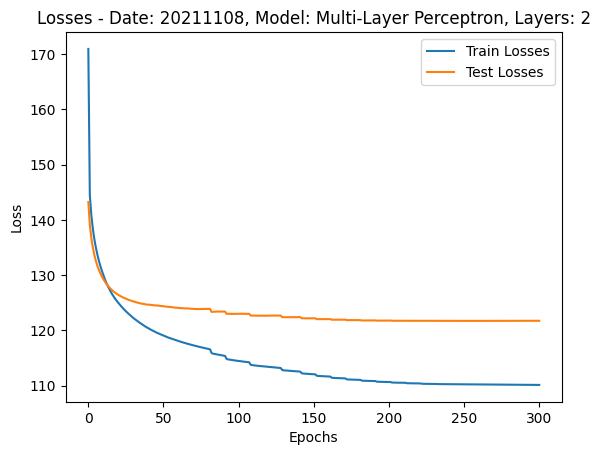

Multi-Layer Perceptron, full dataset
Num Layers: 2, Hidden Layer Dimensionality: 150, Total Parameters: 20964
Epoch: 000, LR: 0.001000, Train Loss: 227.923653, Test Loss: 215.737836. Train R2: -0.0422311, Test R2: -0.0491614, Train pR2: -1.5169109, Test pR2: -1.5165957
Epoch: 050, LR: 0.000640, Train Loss: 193.436622, Test Loss: 201.356682. Train R2: 0.0619075, Test R2: 0.0207816, Train pR2: -1.2321162, Test pR2: -1.2686082
Epoch: 100, LR: 0.000410, Train Loss: 190.698163, Test Loss: 200.022955. Train R2: 0.0769775, Test R2: 0.0272739, Train pR2: -1.2202085, Test pR2: -1.2652967
Epoch: 150, LR: 0.000134, Train Loss: 188.644860, Test Loss: 199.425647. Train R2: 0.0849060, Test R2: 0.0301793, Train pR2: -1.2131417, Test pR2: -1.2640154
Epoch: 200, LR: 0.000050, Train Loss: 187.886695, Test Loss: 199.242661. Train R2: 0.0878490, Test R2: 0.0310691, Train pR2: -1.2071860, Test pR2: -1.2586418
Epoch: 250, LR: 0.000050, Train Loss: 187.750470, Test Loss: 199.290540. Train R2: 0.0885247, Test

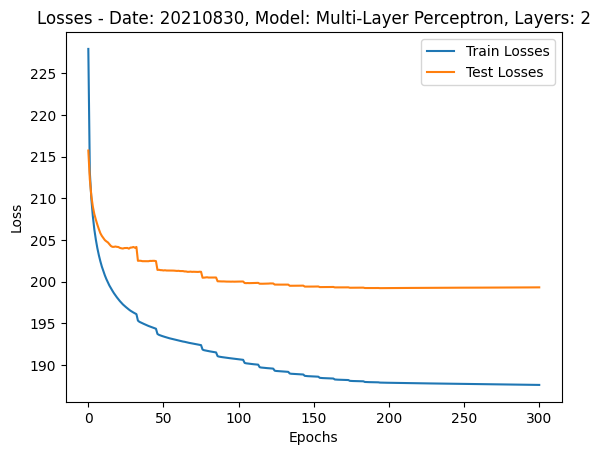

Multi-Layer Perceptron, full dataset
Num Layers: 2, Hidden Layer Dimensionality: 150, Total Parameters: 22323
Epoch: 000, LR: 0.001000, Train Loss: 146.196392, Test Loss: 130.361340. Train R2: 0.1642791, Test R2: 0.1551901, Train pR2: -1.9522347, Test pR2: -1.9596672
Epoch: 050, LR: 0.001000, Train Loss: 110.822857, Test Loss: 116.227901. Train R2: 0.2826199, Test R2: 0.2467669, Train pR2: -1.4823750, Test pR2: -1.5172169
Epoch: 100, LR: 0.001000, Train Loss: 109.381316, Test Loss: 115.718578. Train R2: 0.2907739, Test R2: 0.2500680, Train pR2: -1.5130996, Test pR2: -1.5559703
Epoch: 150, LR: 0.000640, Train Loss: 107.565522, Test Loss: 114.429365. Train R2: 0.3016131, Test R2: 0.2584215, Train pR2: -1.4760592, Test pR2: -1.5152781
Epoch: 200, LR: 0.000210, Train Loss: 105.705459, Test Loss: 112.860225. Train R2: 0.3133998, Test R2: 0.2685893, Train pR2: -1.4292625, Test pR2: -1.4683524
Epoch: 250, LR: 0.000069, Train Loss: 104.985575, Test Loss: 112.426467. Train R2: 0.3170237, Test R

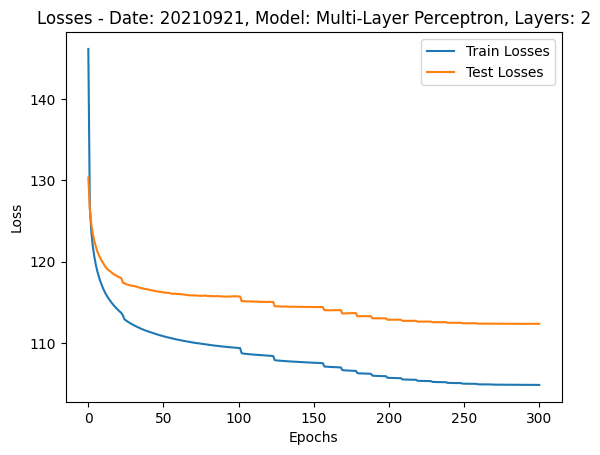

Multi-Layer Perceptron, full dataset
Num Layers: 2, Hidden Layer Dimensionality: 150, Total Parameters: 21719
Epoch: 000, LR: 0.001000, Train Loss: 124.624733, Test Loss: 113.237904. Train R2: 0.1298384, Test R2: 0.1264199, Train pR2: -1.9432423, Test pR2: -1.9612803
Epoch: 050, LR: 0.001000, Train Loss: 94.001077, Test Loss: 97.044200. Train R2: 0.2743706, Test R2: 0.2513524, Train pR2: -1.3478816, Test pR2: -1.3848081
Epoch: 100, LR: 0.001000, Train Loss: 92.862860, Test Loss: 96.295832. Train R2: 0.2837162, Test R2: 0.2571205, Train pR2: -1.3657258, Test pR2: -1.4058422
Epoch: 150, LR: 0.001000, Train Loss: 92.314625, Test Loss: 95.943117. Train R2: 0.2883217, Test R2: 0.2598379, Train pR2: -1.3754853, Test pR2: -1.4184245
Epoch: 200, LR: 0.000800, Train Loss: 91.554918, Test Loss: 95.387393. Train R2: 0.2943094, Test R2: 0.2641268, Train pR2: -1.3545928, Test pR2: -1.3984731
Epoch: 250, LR: 0.000410, Train Loss: 90.332624, Test Loss: 94.707645. Train R2: 0.3019943, Test R2: 0.26937

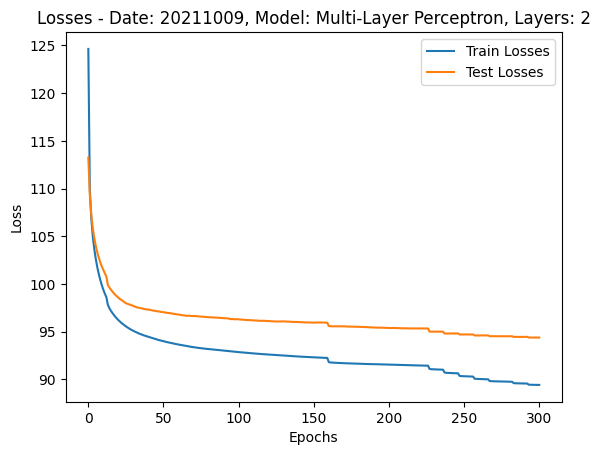

In [ ]:
mlp_2layers_addedrelu_list = []
for date in joint_angles_dict.keys():
    mlp_2layers_addedrelu = plot_losses_MLP(dataset_dict[date]['Joint Angles']['Full'], \
                                            loader_dict[date]['Joint Angles']['Train'], \
                                            loader_dict[date]['Joint Angles']['Test'], \
                                            0.001, 2, restraint_type = 'semirestrained',
                                            add_relu = True, adapt_lr = True, save = False)
    mlp_2layers_addedrelu_list.append(mlp_2layers_addedrelu)

Multi-Layer Perceptron, full dataset
Num Layers: 3, Hidden Layer Dimensionality: 150, Total Parameters: 43614
Epoch: 000, LR: 0.001000, Train Loss: 227.724172, Test Loss: 214.660922. Train R2: -0.0309973, Test R2: -0.0365005, Train pR2: -1.4793506, Test pR2: -1.4749790
Epoch: 050, LR: 0.000410, Train Loss: 164.418295, Test Loss: 201.888336. Train R2: 0.2025948, Test R2: 0.0252857, Train pR2: -0.9655910, Test pR2: -1.1781375
Epoch: 100, LR: 0.000134, Train Loss: 156.831006, Test Loss: 203.539703. Train R2: 0.2439490, Test R2: 0.0173389, Train pR2: -0.9465309, Test pR2: -1.2343261
Epoch: 150, LR: 0.000050, Train Loss: 154.607421, Test Loss: 204.456555. Train R2: 0.2557291, Test R2: 0.0129315, Train pR2: -0.9391010, Test pR2: -1.2501450
Epoch: 200, LR: 0.000050, Train Loss: 153.724934, Test Loss: 205.272251. Train R2: 0.2600584, Test R2: 0.0089800, Train pR2: -0.9405329, Test pR2: -1.2708533
Epoch: 250, LR: 0.000050, Train Loss: 153.019360, Test Loss: 206.004278. Train R2: 0.2635305, Test

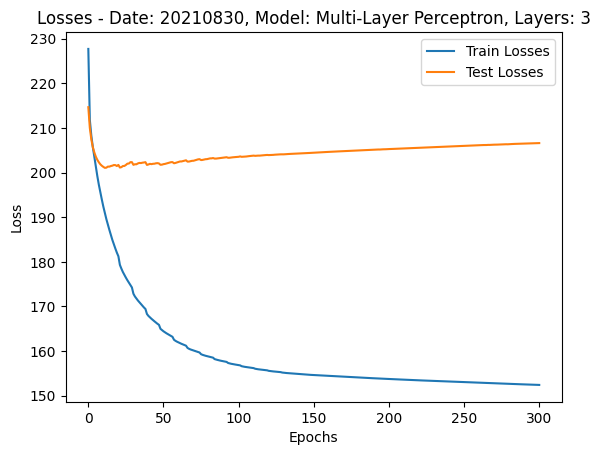

In [ ]:
for date in ['20210830']:
    mlp_3layers_addedrelu = plot_losses_MLP(dataset_dict[date]['Joint Angles']['Full'], \
                                            loader_dict[date]['Joint Angles']['Train'], \
                                            loader_dict[date]['Joint Angles']['Test'], \
                                            0.001, 3, restraint_type = 'semirestrained',
                                            add_relu = True, adapt_lr = True, save = False)

Multi-Layer Perceptron, full dataset
Num Layers: 3, Hidden Layer Dimensionality: 150, Total Parameters: 40443
Epoch: 000, LR: 0.001000, Train Loss: 180.095179, Test Loss: 156.728326. Train R2: 0.0309801, Test R2: 0.0196521, Train pR2: -4.2855825, Test pR2: -4.2760954
Epoch: 050, LR: 0.000800, Train Loss: 94.777641, Test Loss: 116.579068. Train R2: 0.4196313, Test R2: 0.2703220, Train pR2: -0.5682601, Test pR2: -0.7751772
Epoch: 100, LR: 0.000262, Train Loss: 86.391530, Test Loss: 115.801310. Train R2: 0.4754044, Test R2: 0.2752507, Train pR2: -0.4975302, Test pR2: -0.7954201
Epoch: 150, LR: 0.000069, Train Loss: 83.718590, Test Loss: 116.099272. Train R2: 0.4932843, Test R2: 0.2733938, Train pR2: -0.4842845, Test pR2: -0.8195038
Epoch: 200, LR: 0.000050, Train Loss: 82.995385, Test Loss: 116.502621. Train R2: 0.4976485, Test R2: 0.2708726, Train pR2: -0.4810111, Test pR2: -0.8223138
Epoch: 250, LR: 0.000050, Train Loss: 82.565308, Test Loss: 116.917012. Train R2: 0.5002671, Test R2: 0.

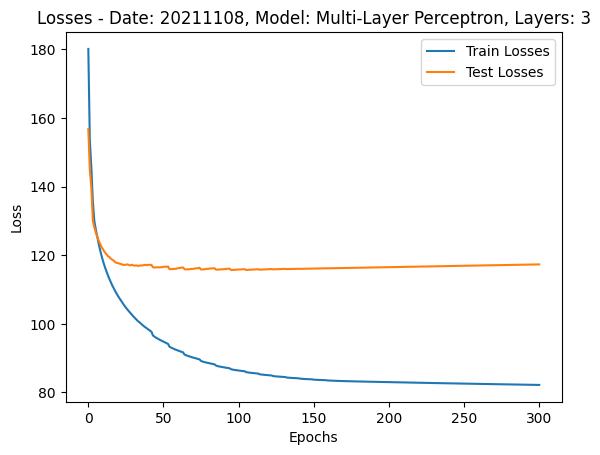

Multi-Layer Perceptron, full dataset
Num Layers: 3, Hidden Layer Dimensionality: 150, Total Parameters: 43614
Epoch: 000, LR: 0.001000, Train Loss: 233.968119, Test Loss: 225.341819. Train R2: -0.0885151, Test R2: -0.0958579, Train pR2: -4.2778111, Test pR2: -4.2801208
Epoch: 050, LR: 0.000512, Train Loss: 163.998812, Test Loss: 204.205048. Train R2: 0.1991295, Test R2: 0.0069472, Train pR2: -1.3948383, Test pR2: -1.6246527
Epoch: 100, LR: 0.000134, Train Loss: 155.827034, Test Loss: 206.461537. Train R2: 0.2401165, Test R2: -0.0040233, Train pR2: -1.2739305, Test pR2: -1.5788352
Epoch: 150, LR: 0.000050, Train Loss: 153.595867, Test Loss: 207.054673. Train R2: 0.2536607, Test R2: -0.0069160, Train pR2: -1.2693353, Test pR2: -1.6012467
Epoch: 200, LR: 0.000050, Train Loss: 152.795601, Test Loss: 207.815140. Train R2: 0.2577016, Test R2: -0.0106121, Train pR2: -1.2705305, Test pR2: -1.6204129
Epoch: 250, LR: 0.000050, Train Loss: 152.180262, Test Loss: 208.506581. Train R2: 0.2607974, T

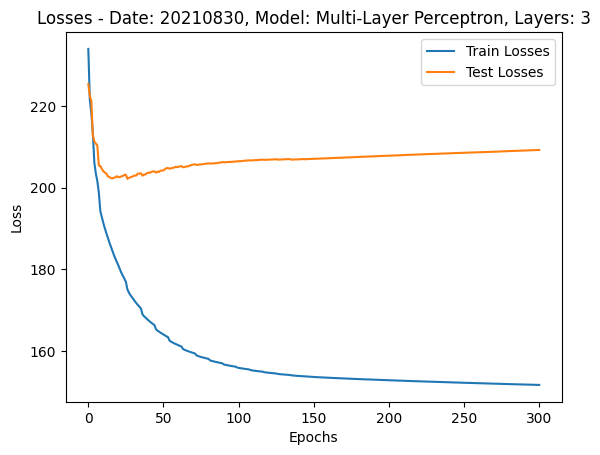

Multi-Layer Perceptron, full dataset
Num Layers: 3, Hidden Layer Dimensionality: 150, Total Parameters: 44973
Epoch: 000, LR: 0.001000, Train Loss: 141.034505, Test Loss: 130.646102. Train R2: 0.1647639, Test R2: 0.1533473, Train pR2: -2.6153400, Test pR2: -2.6358600
Epoch: 050, LR: 0.000800, Train Loss: 89.768318, Test Loss: 105.581068. Train R2: 0.4128450, Test R2: 0.3157688, Train pR2: -0.9041978, Test pR2: -1.0003446
Epoch: 100, LR: 0.000328, Train Loss: 84.390237, Test Loss: 104.783162. Train R2: 0.4467134, Test R2: 0.3209340, Train pR2: -0.8632342, Test pR2: -0.9928265
Epoch: 150, LR: 0.000107, Train Loss: 82.392143, Test Loss: 103.860306. Train R2: 0.4631849, Test R2: 0.3269150, Train pR2: -0.8552271, Test pR2: -1.0007517
Epoch: 200, LR: 0.000050, Train Loss: 81.733576, Test Loss: 103.787411. Train R2: 0.4680121, Test R2: 0.3273874, Train pR2: -0.8566812, Test pR2: -1.0118976
Epoch: 250, LR: 0.000050, Train Loss: 81.495280, Test Loss: 103.947980. Train R2: 0.4695984, Test R2: 0.

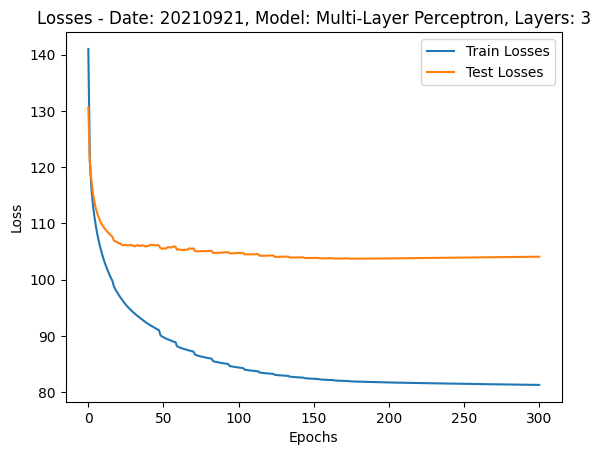

Multi-Layer Perceptron, full dataset
Num Layers: 3, Hidden Layer Dimensionality: 150, Total Parameters: 44369
Epoch: 000, LR: 0.001000, Train Loss: 146.394612, Test Loss: 135.206093. Train R2: -0.0420755, Test R2: -0.0430628, Train pR2: -4.4402056, Test pR2: -4.4132195
Epoch: 050, LR: 0.001000, Train Loss: 80.382256, Test Loss: 90.990852. Train R2: 0.3693781, Test R2: 0.2980525, Train pR2: -0.8183051, Test pR2: -0.8883111
Epoch: 100, LR: 0.000410, Train Loss: 75.648872, Test Loss: 89.466649. Train R2: 0.4104325, Test R2: 0.3098144, Train pR2: -0.7102105, Test pR2: -0.8061916
Epoch: 150, LR: 0.000168, Train Loss: 73.863594, Test Loss: 88.956468. Train R2: 0.4263185, Test R2: 0.3137504, Train pR2: -0.6950846, Test pR2: -0.8047984
Epoch: 200, LR: 0.000055, Train Loss: 73.081517, Test Loss: 88.743294. Train R2: 0.4335102, Test R2: 0.3153975, Train pR2: -0.6819138, Test pR2: -0.7960300
Epoch: 250, LR: 0.000050, Train Loss: 72.882714, Test Loss: 88.792751. Train R2: 0.4350758, Test R2: 0.315

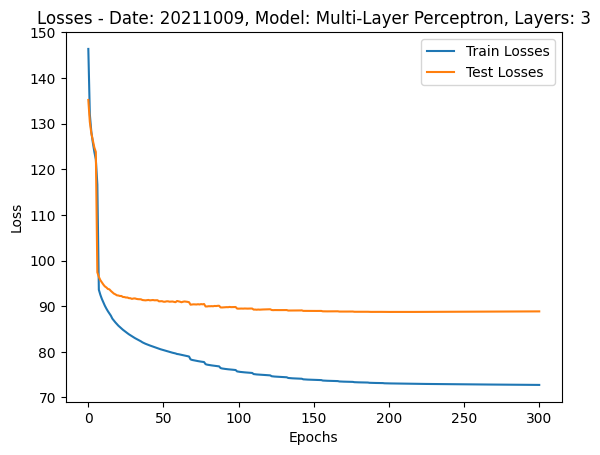

In [ ]:
mlp_3layers_addedrelu_list = []
for date in joint_angles_dict.keys():
    mlp_3layers_addedrelu = plot_losses_MLP(dataset_dict[date]['Joint Angles']['Full'],
                                            loader_dict[date]['Joint Angles']['Train'],
                                            loader_dict[date]['Joint Angles']['Test'],
                                            0.001, 3, restraint_type = 'semirestrained',
                                            add_relu = True, adapt_lr = True, save = False)
    mlp_3layers_addedrelu_list.append(mlp_3layers_addedrelu)

Multi-Layer Perceptron, full dataset
Num Layers: 4, Hidden Layer Dimensionality: 150, Total Parameters: 63093
Epoch: 000, LR: 0.001000, Train Loss: 189.741551, Test Loss: 164.007953. Train R2: -0.0149837, Test R2: -0.0257294, Train pR2: -5.0584850, Test pR2: -5.0690680
Epoch: 050, LR: 0.000800, Train Loss: 81.818048, Test Loss: 115.236932. Train R2: 0.4874453, Test R2: 0.2789473, Train pR2: -0.8578908, Test pR2: -1.0818219
Epoch: 100, LR: 0.000262, Train Loss: 70.259577, Test Loss: 116.223114. Train R2: 0.5630472, Test R2: 0.2730288, Train pR2: -0.6074061, Test pR2: -0.9965620
Epoch: 150, LR: 0.000086, Train Loss: 67.189574, Test Loss: 117.140164. Train R2: 0.5899781, Test R2: 0.2672124, Train pR2: -0.5897866, Test pR2: -1.0402920
Epoch: 200, LR: 0.000050, Train Loss: 66.180348, Test Loss: 117.848415. Train R2: 0.5976629, Test R2: 0.2627223, Train pR2: -0.5871695, Test pR2: -1.0594937
Epoch: 250, LR: 0.000050, Train Loss: 65.602741, Test Loss: 118.656511. Train R2: 0.6013496, Test R2: 

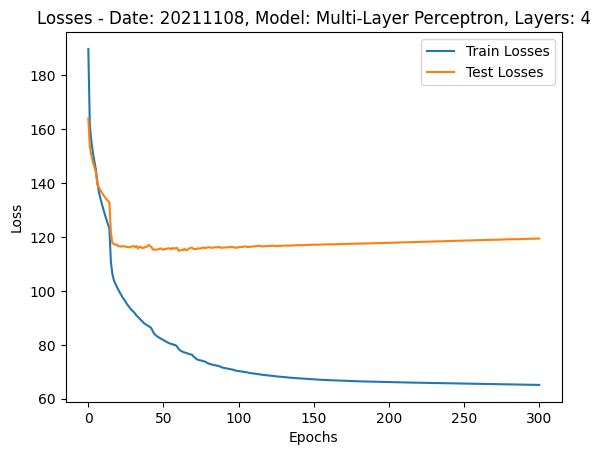

Multi-Layer Perceptron, full dataset
Num Layers: 4, Hidden Layer Dimensionality: 150, Total Parameters: 66264
Epoch: 000, LR: 0.001000, Train Loss: 235.591516, Test Loss: 213.628230. Train R2: -0.0350281, Test R2: -0.0389037, Train pR2: -2.3902292, Test pR2: -2.3989933
Epoch: 050, LR: 0.000512, Train Loss: 145.187359, Test Loss: 210.494410. Train R2: 0.2488247, Test R2: -0.0236266, Train pR2: -1.3252379, Test pR2: -1.7085242
Epoch: 100, LR: 0.000134, Train Loss: 134.536848, Test Loss: 216.000118. Train R2: 0.3198561, Test R2: -0.0504188, Train pR2: -1.1652277, Test pR2: -1.7336400
Epoch: 150, LR: 0.000050, Train Loss: 131.628227, Test Loss: 217.360745. Train R2: 0.3524472, Test R2: -0.0570247, Train pR2: -1.1088630, Test pR2: -1.7565290
Epoch: 200, LR: 0.000050, Train Loss: 130.089617, Test Loss: 219.082865. Train R2: 0.3610905, Test R2: -0.0653989, Train pR2: -1.0792913, Test pR2: -1.7536906
Epoch: 250, LR: 0.000050, Train Loss: 129.050469, Test Loss: 220.899236. Train R2: 0.3666631, 

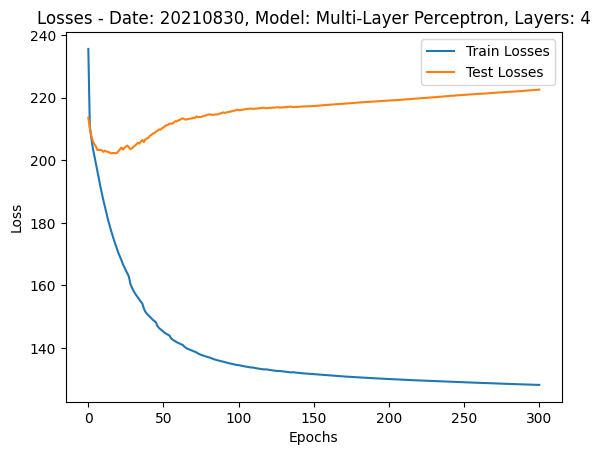

Multi-Layer Perceptron, full dataset
Num Layers: 4, Hidden Layer Dimensionality: 150, Total Parameters: 67623
Epoch: 000, LR: 0.001000, Train Loss: 146.958715, Test Loss: 136.541922. Train R2: 0.1257056, Test R2: 0.1151313, Train pR2: -2.7529042, Test pR2: -2.7638910
Epoch: 050, LR: 0.000800, Train Loss: 78.921599, Test Loss: 104.704640. Train R2: 0.4654325, Test R2: 0.3214376, Train pR2: -1.2157453, Test pR2: -1.3701478
Epoch: 100, LR: 0.000328, Train Loss: 70.922406, Test Loss: 104.215805. Train R2: 0.5209252, Test R2: 0.3245872, Train pR2: -1.0947969, Test pR2: -1.3094751
Epoch: 150, LR: 0.000134, Train Loss: 68.353146, Test Loss: 103.642372. Train R2: 0.5462741, Test R2: 0.3283066, Train pR2: -1.0857538, Test pR2: -1.3480465
Epoch: 200, LR: 0.000050, Train Loss: 67.267746, Test Loss: 103.580761. Train R2: 0.5591900, Test R2: 0.3287091, Train pR2: -1.0803201, Test pR2: -1.3653405
Epoch: 250, LR: 0.000050, Train Loss: 66.834081, Test Loss: 103.865243. Train R2: 0.5623917, Test R2: 0.

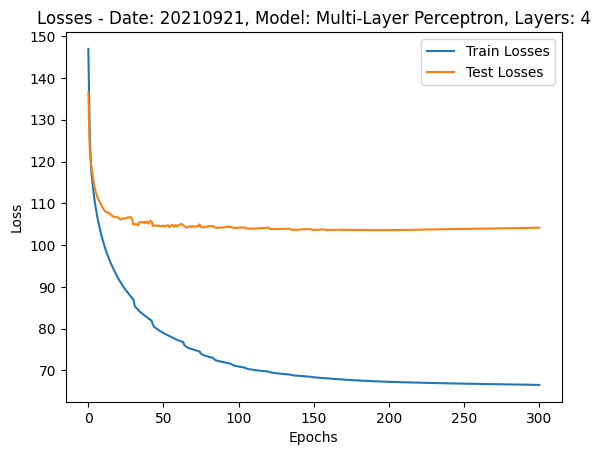

Multi-Layer Perceptron, full dataset
Num Layers: 4, Hidden Layer Dimensionality: 150, Total Parameters: 67019
Epoch: 000, LR: 0.001000, Train Loss: 145.257594, Test Loss: 126.810550. Train R2: 0.0234965, Test R2: 0.0217056, Train pR2: -2.7957182, Test pR2: -2.8242226
Epoch: 050, LR: 0.000640, Train Loss: 71.053289, Test Loss: 88.383519. Train R2: 0.4375213, Test R2: 0.3181854, Train pR2: -0.4844082, Test pR2: -0.5973667
Epoch: 100, LR: 0.000262, Train Loss: 65.603462, Test Loss: 87.956792. Train R2: 0.4834604, Test R2: 0.3214769, Train pR2: -0.4655663, Test pR2: -0.6224994
Epoch: 150, LR: 0.000069, Train Loss: 63.822724, Test Loss: 87.776407. Train R2: 0.5024620, Test R2: 0.3228686, Train pR2: -0.4489972, Test pR2: -0.6283774
Epoch: 200, LR: 0.000050, Train Loss: 63.284878, Test Loss: 87.938396. Train R2: 0.5076835, Test R2: 0.3216189, Train pR2: -0.4472493, Test pR2: -0.6325984
Epoch: 250, LR: 0.000050, Train Loss: 62.981745, Test Loss: 88.190759. Train R2: 0.5101841, Test R2: 0.31967

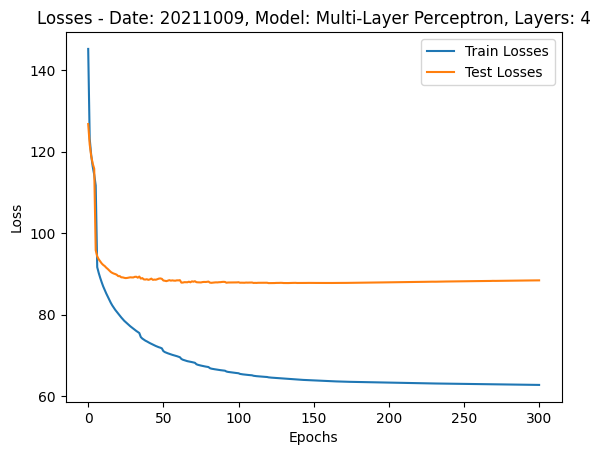

In [ ]:
mlp_4layers_addedrelu_list = []
for date in joint_angles_dict.keys():
    mlp_4layers_addedrelu = plot_losses_MLP(dataset_dict[date]['Joint Angles']['Full'], \
                                            loader_dict[date]['Joint Angles']['Train'], \
                                            loader_dict[date]['Joint Angles']['Test'], \
                                            0.001, 4, restraint_type = 'semirestrained',
                                            add_relu = True, adapt_lr = True, save = False)
    mlp_3layers_addedrelu_list.append(mlp_4layers_addedrelu)

In [ ]:
for date, model in zip(joint_angles_dict.keys(),mlp_3layers_addedrelu_list):
    directory = '/content/drive/My Drive/Miller_Lab/FIU/MLP/Pop_FR_OpenSIM/semirestrained/'
    model_name = 'MLP_{}_{}_{}_layers_reluadded'.format(date,'Joint Angles','3')
    torch.save(model.state_dict(), directory+model_name)

# Temp CNN

In [ ]:
#input norm - if true, pair normed input with normal output; if not, pair unnormed input with frate output
class CustomDataset(Dataset):
    def __init__(self, date, inp_type, split_neurons = False, split_num = 0, shuffle = True, time_delay = True, instance_length = 100, good_range = (3000, 3600)):
        self.date = date
        self.input_type = inp_type
        inp_types = ['Joint Angles','Joint Velocities','Joint Angles and Velocities']
        if inp_type == 'Joint Angles':
            input = joint_angles_dict[date]
        elif inp_type == 'Joint Velocities':
            input = velocities_dict[date]
        elif inp_type == 'Joint Angles and Velocities':
            input = angles_and_velocities_dict[date]
        else:
            print('Invalid Input Type')
            assert inp_type in inp_types
        if split_neurons == False:
            neuraldata = firing_rates_dict[date]
        else:
            neuraldata = firing_rates_dict_split[date][split_num]
            self.split_num = split_num

        # remove the "good" section for testing
        self.inputs = np.delete(input, np.arange(good_range[0],good_range[1]), 0)
        self.neuraloutputs = np.delete(neuraldata, np.arange(good_range[0],good_range[1]), 0)

        num_instances = self.neuraloutputs.shape[0]
        remainder = num_instances%instance_length
        round_num_instances = num_instances-remainder
        print(num_instances, remainder, round_num_instances)

        if time_delay == False:
            self.inputs = self.inputs[:round_num_instances] #make dataset divisible by instance_length
            self.neuraloutputs = self.neuraloutputs[:round_num_instances] #make dataset divisible by instance_length
        elif remainder>4:
            self.inputs = self.inputs[4:round_num_instances+4] #make dataset divisible by instance_length; shift by 4
            self.neuraloutputs = self.neuraloutputs[:round_num_instances] #make dataset divisible by instance_length
        else:
            round_num_instances = round_num_instances - instance_length
            self.inputs = self.inputs[4:round_num_instances+4] #make dataset divisible by instance_length; shift by 4
            self.neuraloutputs = self.neuraloutputs[:round_num_instances] #make dataset divisible by instance_length

        print('Input shape before: {}, Output shape before: {}'.format(self.inputs.shape, self.neuraloutputs.shape))

        self.input_dim = self.inputs.shape[-1]
        self.num_neural_units = neuraldata.shape[1]
        self.inputs = self.inputs.reshape((-1, instance_length, self.input_dim), order = 'C')
        print('Input shape after: {}'.format(self.inputs.shape))
        self.neuraloutputs = self.neuraloutputs.reshape((-1, instance_length, self.num_neural_units), order = 'C') #I checked. We want order C
        print('Output shape after: {}'.format(self.neuraloutputs.shape))
        self.sample_nums = np.arange(len(self.inputs)).astype(int)
        
        def shuffle_data(inputs, targets, samp_nums):
            assert len(inputs) == len(targets)
            p = np.random.permutation(len(inputs))
            return(inputs[p], targets[p], samp_nums[p])

        if shuffle == True:
            self.inputs, self.neuraloutputs, self.sample_nums =\
             shuffle_data(self.inputs, self.neuraloutputs, self.sample_nums)

    def __len__(self):
        assert len(self.inputs) == len(self.neuraloutputs)
        return len(self.inputs)

    def __getitem__(self, idx):
        input = torch.from_numpy(self.inputs[idx])
        neuraloutput = torch.from_numpy(self.neuraloutputs[idx])
        return input.float().t(), neuraloutput.float(), self.sample_nums #input is transposed for convenience - better for Conv1D

In [ ]:
class TempConvNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, num_conv_layers, num_readout_layers, kernel_size, filters_per_conv, add_relu = False, causal=False):
        super(TempConvNet, self).__init__()
        self.name = "Temporal CNN"
        self.net = nn.ModuleList()
        self.num_conv_layers = num_conv_layers
        self.num_readout_layers = num_readout_layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.causal = causal
        self.add_relu = add_relu
        self.padding = 0
        # if self.causal == False:
        #     self.padding = 'same'
        # else:
        #     self.padding = 0
        
        # 1D convolutional layers
        for i in range(num_conv_layers):
            self.net.append(nn.Conv1d(in_channels = input_dim, out_channels = input_dim*filters_per_conv, \
                                      kernel_size = kernel_size, padding = self.padding))
            self.net.append(nn.ReLU())
            input_dim *= filters_per_conv

        # output layer
        self.net.append(nn.Linear(input_dim, output_dim))
        if num_readout_layers > 1:
            for i in range(num_readout_layers-1):
                self.net.append(nn.ReLU())
                self.net.append(nn.Linear(output_dim, output_dim))
        if add_relu == True:
            self.net.append(nn.ReLU())

    def forward(self, x):
        for i, layer in enumerate(self.net):
            # shape_before = x.shape
            # if (type(layer)==torch.nn.modules.linear.Linear) and (i==(len(self.net)-(2*self.num_readout_layers-(1+int(self.add_relu))))):
            #     x = layer(torch.transpose(x, 1, 2))
            # elif ((type(layer)==torch.nn.modules.conv.Conv1d) and (self.causal == True)):
            #     x = layer(x)
            #     x = x[:, :, :-layer.padding[0]]
            # else:
            #     x = layer(x)
            # shape_after = x.shape
            if (type(layer)==torch.nn.modules.linear.Linear):
                x = layer(torch.transpose(x, 1, 2))
            elif ((type(layer)==torch.nn.modules.conv.Conv1d) and (self.causal == True)):
                x = torch.nn.functional.pad(x, (0, self.kernel_size-1), mode='constant', value=0)
                x = layer(x)
            elif ((type(layer)==torch.nn.modules.conv.Conv1d) and (self.causal == False)):
                left_pad = math.ceil((self.kernel_size-1)/2)
                right_pad = math.floor((self.kernel_size-1)/2)
                x = torch.nn.functional.pad(x, (left_pad, right_pad), mode='constant', value=0)
                x = layer(x)
            else:
                x = layer(x)
            # print('Shape before: {}, shape after: {}'.format(shape_before, shape_after))
        return(x)

In [ ]:
def plot_losses_TempCNN(dataset, train_loader, test_loader, learning_rate, num_conv_layers, kernel_size = 5, add_relu = True, causal = True, adapt_lr = True, save = True, l2_reg = 0, numepochs = 301):
    date = dataset.date

    num_readout_layers, kernel_size, num_kernels = 1, kernel_size, 2
    model = TempConvNet(dataset.input_dim, dataset.num_neural_units, num_conv_layers, \
                        num_readout_layers, kernel_size, num_kernels, add_relu = add_relu, causal=causal)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if l2_reg > 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=8, min_lr=0.00005)
    total_params = sum(p.numel() for p in model.parameters())

    print('{}, full dataset'.format(model.name))
    print('Num Conv Layers: {}, Kernel Size: {}, Total Parameters: {}'\
        .format(model.num_conv_layers, model.kernel_size, total_params))

    train_losses = []
    val_losses = []
    test_losses = []
    start = time.time()
    for epoch in range(numepochs):
        lr = scheduler.optimizer.param_groups[0]['lr']
        train_loss = train(train_loader, model, optimizer, criterion, scheduler)
        _, train_R2, train_pr2, train_preds, train_targets = test(train_loader, model, optimizer, criterion, dataset.num_neural_units, conv = True)
        test_loss, test_R2, test_pr2, test_preds, test_targets = test(test_loader, model, optimizer, criterion, dataset.num_neural_units, conv = True)
        if adapt_lr == True: 
            scheduler.step(test_loss)
        if epoch % 50==0:
            print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:7f}, Test Loss: {:7f}. Train R2: {:.7f}, Test R2: {:.7f}, Train pR2: {:.7f}, Test pR2: {:.7f}'\
                  .format(epoch, lr, train_loss, test_loss, train_R2, test_R2, train_pr2, test_pr2))
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    end = time.time()
    print('Time to train model: {}'.format(end-start))

    plt.plot(train_losses)
    plt.plot(test_losses)
    plt.title('Losses - Date: {}, Model: {}, Conv Layers: {}'.format(date, model.name, model.num_conv_layers))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train Losses', 'Test Losses'])
    plt.show()

    directory = '/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/Pop_FR_OpenSIM/Standard/instance_length_7/'
    if add_relu == True:
        model_name = 'TempCNN_{}_{}_{}_convlayers_reluadded'.format(dataset.date,dataset.input_type,model.num_conv_layers)
    else:
        model_name = 'TempCNN_{}_{}_{}_convlayers'.format(dataset.date,dataset.input_type,model.num_conv_layers)
    if save == True:
        torch.save(model.state_dict(), directory+model_name)

    return(model)

In [ ]:
def plot_targets_and_preds_cnn(model, good_inp, good_out, electrodes_list):
    print('Learning Rate: {}'.format(0.001))
    with torch.no_grad():
        good_inp = torch.from_numpy(good_inp.T).float().unsqueeze(0)
        pred_good_section = model(good_inp)
        output_good_section = torch.from_numpy(good_out).float()
        plot_targets_and_preds(output_good_section, pred_good_section.squeeze(), 600, electrodes_list, fig_shape = (len(electrodes_list),1))

In [ ]:
inp_types = ['Joint Angles']
for date in joint_angles_dict.keys():
    print(date)
    print(joint_angles_dict[date].shape, firing_rates_dict[date].shape)
    for inp_type in inp_types:
        dataset = CustomDataset(date, inp_type, instance_length = 100, shuffle = True, time_delay = True, good_range = good_frates_range_dict[date])
        create_and_save_datasets(dataset, instance_length = 100, tcnn = True)

20211108
(17970, 24) (17970, 93)
17370 70 17300
Input shape before: (17300, 24), Output shape before: (17300, 93)
Input shape after: (173, 100, 24)
Output shape after: (173, 100, 93)
20210830
(35941, 24) (35941, 114)
35341 41 35300
Input shape before: (35300, 24), Output shape before: (35300, 114)
Input shape after: (353, 100, 24)
Output shape after: (353, 100, 114)
20210921
(35941, 24) (35941, 123)
35341 41 35300
Input shape before: (35300, 24), Output shape before: (35300, 123)
Input shape after: (353, 100, 24)
Output shape after: (353, 100, 123)
20211009
(35941, 24) (35941, 119)
35341 41 35300
Input shape before: (35300, 24), Output shape before: (35300, 119)
Input shape after: (353, 100, 24)
Output shape after: (353, 100, 119)


In [ ]:
inp_types = ['Joint Angles']
for date in joint_angles_dict.keys():
    print(date)
    for inp_type in inp_types:
        for split_num in [0,1,2]:
            dataset = CustomDataset(date, inp_type, split_neurons = True, split_num = split_num, instance_length = 100, shuffle = True, time_delay = True, good_range = good_frates_range_dict[date])
            create_and_save_datasets(dataset, instance_length = 100, tcnn = True, split_neurons = True, split_num = split_num, restraint_type = 'semirestrained')

20211108
17370 70 17300
Input shape before: (17300, 24), Output shape before: (17300, 31)
Input shape after: (173, 100, 24)
Output shape after: (173, 100, 31)
17370 70 17300
Input shape before: (17300, 24), Output shape before: (17300, 31)
Input shape after: (173, 100, 24)
Output shape after: (173, 100, 31)
17370 70 17300
Input shape before: (17300, 24), Output shape before: (17300, 31)
Input shape after: (173, 100, 24)
Output shape after: (173, 100, 31)
20210830
33541 41 33500
Input shape before: (33500, 24), Output shape before: (33500, 38)
Input shape after: (335, 100, 24)
Output shape after: (335, 100, 38)
33541 41 33500
Input shape before: (33500, 24), Output shape before: (33500, 38)
Input shape after: (335, 100, 24)
Output shape after: (335, 100, 38)
33541 41 33500
Input shape before: (33500, 24), Output shape before: (33500, 38)
Input shape after: (335, 100, 24)
Output shape after: (335, 100, 38)
20210921
35341 41 35300
Input shape before: (35300, 24), Output shape before: (353

In [ ]:
tcnn_dataset_dict = load_datasets('/content/drive/My Drive/Miller_Lab/FIU/PopFRData/tcnn_processed_shuffled_opensim_datasets/instance_length_100/semirestrained')
tcnn_loader_dict = get_loaders(tcnn_dataset_dict, 32)

In [ ]:
for date in joint_angles_dict.keys():
    print(date,
    len(tcnn_dataset_dict[date]['Joint Angles']['Full']), \
    tcnn_dataset_dict[date]['Joint Angles']['Full'][0][0].shape, \
    tcnn_dataset_dict[date]['Joint Angles']['Full'][0][1].shape)

20211108 173 torch.Size([24, 100]) torch.Size([100, 93])
20210830 353 torch.Size([24, 100]) torch.Size([100, 114])
20210921 353 torch.Size([24, 100]) torch.Size([100, 123])
20211009 353 torch.Size([24, 100]) torch.Size([100, 119])


Temporal CNN, full dataset
Num Conv Layers: 1, Kernel Size: 5, Total Parameters: 10365
Epoch: 000, LR: 0.001000, Train Loss: 470.288489, Test Loss: 478.298721. Train R2: -1.6310746, Test R2: -1.7267504, Train pR2: -17.5053139, Test pR2: -17.9138298
Epoch: 050, LR: 0.001000, Train Loss: 134.484148, Test Loss: 148.220932. Train R2: 0.1798793, Test R2: 0.1235897, Train pR2: -0.9839063, Test pR2: -1.0115305
Epoch: 100, LR: 0.001000, Train Loss: 123.463441, Test Loss: 141.682167. Train R2: 0.2440042, Test R2: 0.1586681, Train pR2: -0.5819430, Test pR2: -0.7012337
Epoch: 150, LR: 0.001000, Train Loss: 118.591800, Test Loss: 140.148731. Train R2: 0.2725864, Test R2: 0.1672730, Train pR2: -0.4482681, Test pR2: -0.5983964
Epoch: 200, LR: 0.001000, Train Loss: 115.389420, Test Loss: 139.714630. Train R2: 0.2911782, Test R2: 0.1709167, Train pR2: -0.4184687, Test pR2: -0.5823882
Epoch: 250, LR: 0.000512, Train Loss: 113.335135, Test Loss: 139.632790. Train R2: 0.3027212, Test R2: 0.1715105, Train

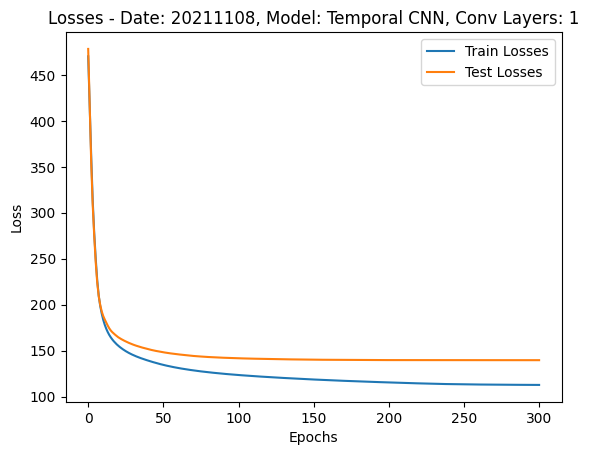

Temporal CNN, full dataset
Num Conv Layers: 1, Kernel Size: 5, Total Parameters: 11394
Epoch: 000, LR: 0.001000, Train Loss: 572.736542, Test Loss: 560.342509. Train R2: -1.5285555, Test R2: -1.5631514, Train pR2: -17.4864960, Test pR2: -17.7938442
Epoch: 050, LR: 0.001000, Train Loss: 207.894738, Test Loss: 227.311712. Train R2: -0.0218893, Test R2: -0.0646575, Train pR2: -1.9064093, Test pR2: -1.9756185
Epoch: 100, LR: 0.001000, Train Loss: 202.417306, Test Loss: 225.181091. Train R2: 0.0046355, Test R2: -0.0549361, Train pR2: -1.4255635, Test pR2: -1.5092554
Epoch: 150, LR: 0.000512, Train Loss: 200.001563, Test Loss: 225.503749. Train R2: 0.0155418, Test R2: -0.0557977, Train pR2: -1.2590655, Test pR2: -1.3560380
Epoch: 200, LR: 0.000134, Train Loss: 199.279082, Test Loss: 225.814061. Train R2: 0.0184587, Test R2: -0.0568825, Train pR2: -1.2336177, Test pR2: -1.3305415
Epoch: 250, LR: 0.000050, Train Loss: 199.083303, Test Loss: 225.878164. Train R2: 0.0192778, Test R2: -0.0571435,

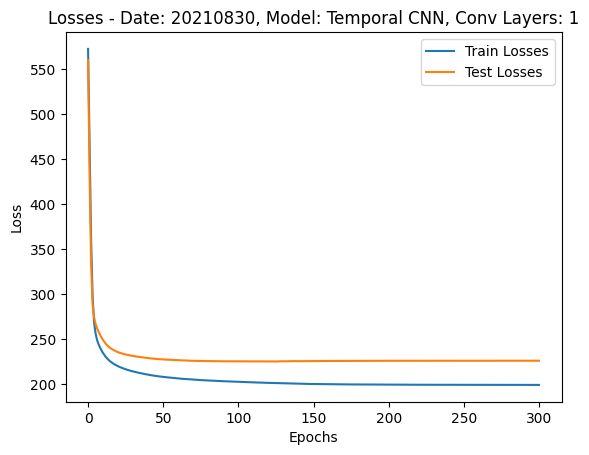

Temporal CNN, full dataset
Num Conv Layers: 1, Kernel Size: 5, Total Parameters: 11835
Epoch: 000, LR: 0.001000, Train Loss: 356.083438, Test Loss: 333.643585. Train R2: -1.0628594, Test R2: -1.1452455, Train pR2: -13.2553291, Test pR2: -13.8806486
Epoch: 050, LR: 0.001000, Train Loss: 121.332839, Test Loss: 129.078634. Train R2: 0.2122395, Test R2: 0.1700077, Train pR2: -1.7352690, Test pR2: -1.8543365
Epoch: 100, LR: 0.001000, Train Loss: 115.122554, Test Loss: 125.428060. Train R2: 0.2527177, Test R2: 0.1916932, Train pR2: -1.4858235, Test pR2: -1.6093929
Epoch: 150, LR: 0.001000, Train Loss: 111.925128, Test Loss: 123.957868. Train R2: 0.2735428, Test R2: 0.1993117, Train pR2: -1.4324174, Test pR2: -1.5669395
Epoch: 200, LR: 0.001000, Train Loss: 110.081203, Test Loss: 122.809397. Train R2: 0.2856017, Test R2: 0.2060079, Train pR2: -1.4091095, Test pR2: -1.5486621
Epoch: 250, LR: 0.001000, Train Loss: 108.796606, Test Loss: 122.082494. Train R2: 0.2939593, Test R2: 0.2097075, Train

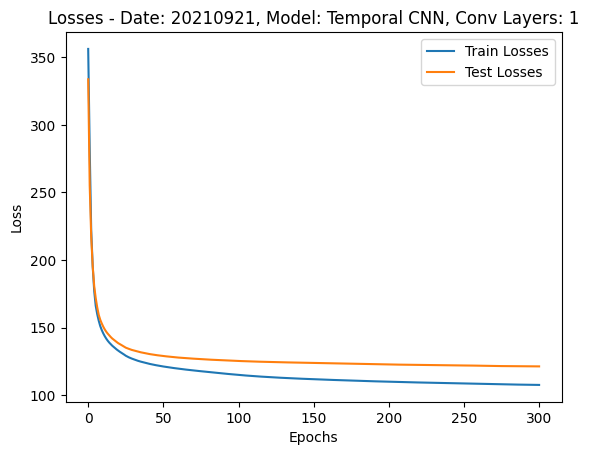

Temporal CNN, full dataset
Num Conv Layers: 1, Kernel Size: 5, Total Parameters: 11639
Epoch: 000, LR: 0.001000, Train Loss: 408.263580, Test Loss: 349.915110. Train R2: -1.8087463, Test R2: -1.7473768, Train pR2: -15.8152981, Test pR2: -15.2545633
Epoch: 050, LR: 0.001000, Train Loss: 105.690080, Test Loss: 109.035810. Train R2: 0.1782913, Test R2: 0.1510735, Train pR2: -1.5042735, Test pR2: -1.5711149
Epoch: 100, LR: 0.001000, Train Loss: 101.760253, Test Loss: 106.743449. Train R2: 0.2086212, Test R2: 0.1703550, Train pR2: -1.1471132, Test pR2: -1.1934639
Epoch: 150, LR: 0.001000, Train Loss: 99.813908, Test Loss: 105.708560. Train R2: 0.2237627, Test R2: 0.1774917, Train pR2: -0.9312824, Test pR2: -0.9801865
Epoch: 200, LR: 0.001000, Train Loss: 98.522502, Test Loss: 105.006149. Train R2: 0.2338820, Test R2: 0.1817964, Train pR2: -0.8453582, Test pR2: -0.9128129
Epoch: 250, LR: 0.001000, Train Loss: 97.570436, Test Loss: 104.628787. Train R2: 0.2413549, Test R2: 0.1843505, Train pR

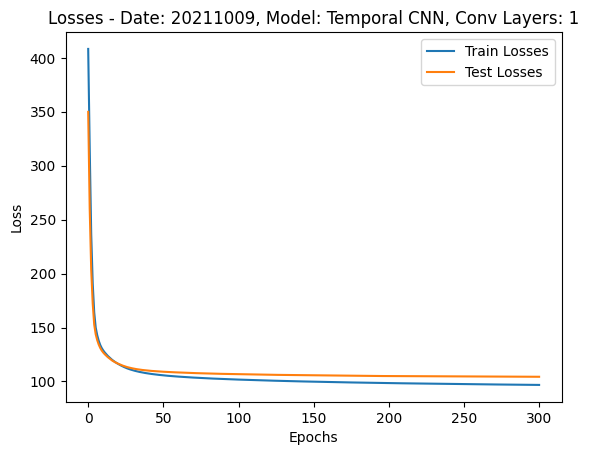

In [ ]:
for date in joint_angles_dict.keys():
    plot_losses_TempCNN(tcnn_dataset_dict[date]['Joint Angles']['Full'], \
                        tcnn_loader_dict[date]['Joint Angles']['Train'], \
                        tcnn_loader_dict[date]['Joint Angles']['Test'], \
                        0.001, 1, kernel_size = 5, add_relu = True, adapt_lr = True, \
                        save = False, causal = True, numepochs = 301)

Temporal CNN, full dataset
Num Conv Layers: 2, Kernel Size: 5, Total Parameters: 37965
Epoch: 000, LR: 0.001000, Train Loss: 510.994025, Test Loss: 498.007507. Train R2: -1.7382033, Test R2: -1.8383795, Train pR2: -13.8665419, Test pR2: -14.6269293
Epoch: 050, LR: 0.001000, Train Loss: 118.423825, Test Loss: 141.650486. Train R2: 0.2772551, Test R2: 0.1723097, Train pR2: -0.5982328, Test pR2: -0.7178447
Epoch: 100, LR: 0.000640, Train Loss: 104.708723, Test Loss: 139.850868. Train R2: 0.3555915, Test R2: 0.1844113, Train pR2: -0.2589036, Test pR2: -0.4852439
Epoch: 150, LR: 0.000262, Train Loss: 99.833034, Test Loss: 139.910286. Train R2: 0.3835547, Test R2: 0.1830120, Train pR2: -0.2394235, Test pR2: -0.4971100
Epoch: 200, LR: 0.000086, Train Loss: 98.478818, Test Loss: 140.148170. Train R2: 0.3911359, Test R2: 0.1818472, Train pR2: -0.2370341, Test pR2: -0.5001985
Epoch: 250, LR: 0.000050, Train Loss: 98.021965, Test Loss: 140.240311. Train R2: 0.3937428, Test R2: 0.1812586, Train pR

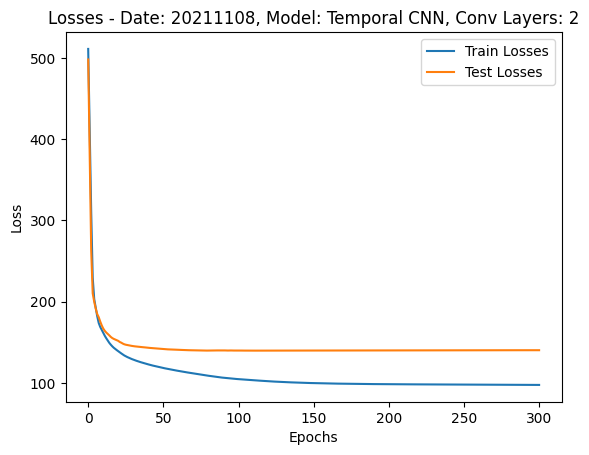

Temporal CNN, full dataset
Num Conv Layers: 2, Kernel Size: 5, Total Parameters: 40002
Epoch: 000, LR: 0.001000, Train Loss: 533.473887, Test Loss: 437.746948. Train R2: -0.9984702, Test R2: -1.0138001, Train pR2: -9.6615105, Test pR2: -10.0815659
Epoch: 050, LR: 0.000800, Train Loss: 202.810584, Test Loss: 227.098409. Train R2: 0.0032761, Test R2: -0.0670578, Train pR2: -2.1271477, Test pR2: -2.1972861
Epoch: 100, LR: 0.000262, Train Loss: 195.817622, Test Loss: 229.171926. Train R2: 0.0362049, Test R2: -0.0759055, Train pR2: -1.7920469, Test pR2: -1.9015262
Epoch: 150, LR: 0.000069, Train Loss: 194.014865, Test Loss: 230.301992. Train R2: 0.0443467, Test R2: -0.0813098, Train pR2: -1.7838017, Test pR2: -1.9095379
Epoch: 200, LR: 0.000050, Train Loss: 193.378057, Test Loss: 230.717707. Train R2: 0.0474018, Test R2: -0.0833498, Train pR2: -1.7812326, Test pR2: -1.9123936
Epoch: 250, LR: 0.000050, Train Loss: 192.789356, Test Loss: 231.103902. Train R2: 0.0502920, Test R2: -0.0853492, T

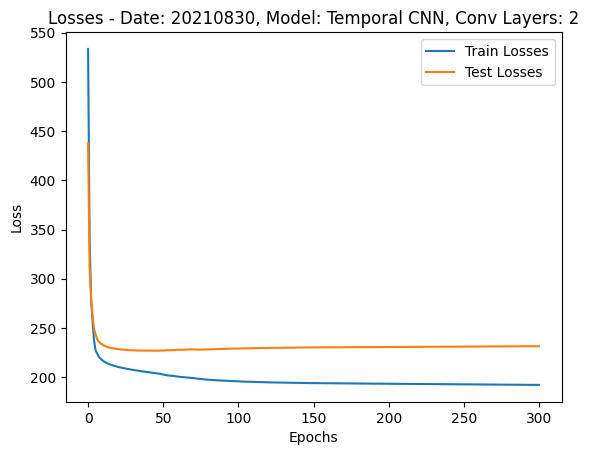

Temporal CNN, full dataset
Num Conv Layers: 2, Kernel Size: 5, Total Parameters: 40875
Epoch: 000, LR: 0.001000, Train Loss: 349.456991, Test Loss: 282.443614. Train R2: -0.7714836, Test R2: -0.8086754, Train pR2: -8.9284153, Test pR2: -9.3638849
Epoch: 050, LR: 0.001000, Train Loss: 112.408726, Test Loss: 123.878011. Train R2: 0.2748237, Test R2: 0.1974785, Train pR2: -1.9329005, Test pR2: -2.0890195
Epoch: 100, LR: 0.001000, Train Loss: 103.883185, Test Loss: 120.577014. Train R2: 0.3298921, Test R2: 0.2171727, Train pR2: -1.3512588, Test pR2: -1.5355766
Epoch: 150, LR: 0.000410, Train Loss: 99.332354, Test Loss: 120.129110. Train R2: 0.3548973, Test R2: 0.2207106, Train pR2: -1.2983850, Test pR2: -1.5134814
Epoch: 200, LR: 0.000134, Train Loss: 98.032377, Test Loss: 120.133687. Train R2: 0.3620073, Test R2: 0.2209282, Train pR2: -1.2772193, Test pR2: -1.5036844
Epoch: 250, LR: 0.000050, Train Loss: 97.651611, Test Loss: 120.150960. Train R2: 0.3640869, Test R2: 0.2208570, Train pR2:

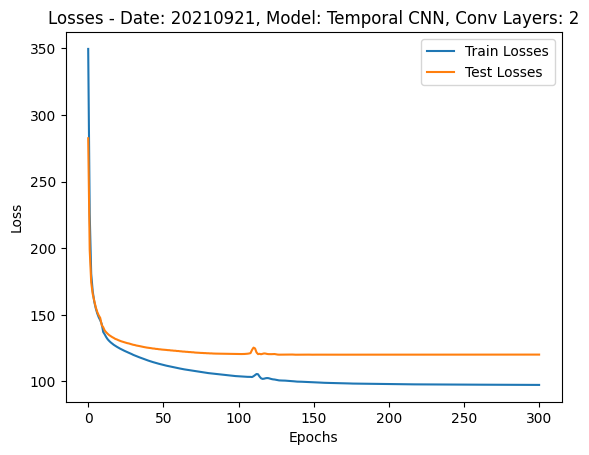

Temporal CNN, full dataset
Num Conv Layers: 2, Kernel Size: 5, Total Parameters: 40487
Epoch: 000, LR: 0.001000, Train Loss: 393.122928, Test Loss: 280.496435. Train R2: -1.2215294, Test R2: -1.2013365, Train pR2: -8.8883009, Test pR2: -8.5865030
Epoch: 050, LR: 0.001000, Train Loss: 100.508436, Test Loss: 106.499522. Train R2: 0.2174723, Test R2: 0.1710216, Train pR2: -1.5289259, Test pR2: -1.5975018
Epoch: 100, LR: 0.001000, Train Loss: 94.280633, Test Loss: 104.752675. Train R2: 0.2636012, Test R2: 0.1829832, Train pR2: -1.3756521, Test pR2: -1.4639431
Epoch: 150, LR: 0.001000, Train Loss: 89.466319, Test Loss: 102.550161. Train R2: 0.3023686, Test R2: 0.1970991, Train pR2: -1.1969821, Test pR2: -1.3059474
Epoch: 200, LR: 0.001000, Train Loss: 86.172901, Test Loss: 101.636492. Train R2: 0.3288362, Test R2: 0.2031137, Train pR2: -1.0556233, Test pR2: -1.1771088
Epoch: 250, LR: 0.000512, Train Loss: 83.924689, Test Loss: 100.007561. Train R2: 0.3486158, Test R2: 0.2105723, Train pR2: 

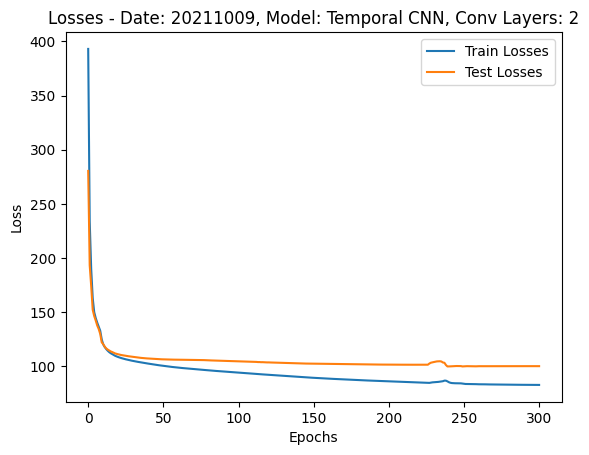

In [ ]:
for date in joint_angles_dict.keys():
    plot_losses_TempCNN(tcnn_dataset_dict[date]['Joint Angles']['Full'], \
                        tcnn_loader_dict[date]['Joint Angles']['Train'], \
                        tcnn_loader_dict[date]['Joint Angles']['Test'], \
                        0.001, 2, kernel_size = 5, add_relu = True, adapt_lr = True, \
                        save = False, causal = True, numepochs = 301)

Temporal CNN, full dataset
Num Conv Layers: 3, Kernel Size: 5, Total Parameters: 139245
Epoch: 000, LR: 0.001000, Train Loss: 478.561359, Test Loss: 377.660187. Train R2: -1.1723664, Test R2: -1.2704774, Train pR2: -6.8788300, Test pR2: -6.7704473
Epoch: 050, LR: 0.001000, Train Loss: 108.285973, Test Loss: 140.528290. Train R2: 0.3219856, Test R2: 0.1394559, Train pR2: -1.0881629, Test pR2: -1.2307296
Epoch: 100, LR: 0.000512, Train Loss: 93.090837, Test Loss: 138.936069. Train R2: 0.4252047, Test R2: 0.1686198, Train pR2: -1.0385107, Test pR2: -1.2869546
Epoch: 150, LR: 0.000168, Train Loss: 88.214977, Test Loss: 139.816456. Train R2: 0.4529116, Test R2: 0.1600125, Train pR2: -0.9760803, Test pR2: -1.2783601
Epoch: 200, LR: 0.000050, Train Loss: 86.693185, Test Loss: 140.005867. Train R2: 0.4614738, Test R2: 0.1579012, Train pR2: -0.9049739, Test pR2: -1.2241452
Epoch: 250, LR: 0.000050, Train Loss: 85.871384, Test Loss: 140.247009. Train R2: 0.4663141, Test R2: 0.1559181, Train pR2:

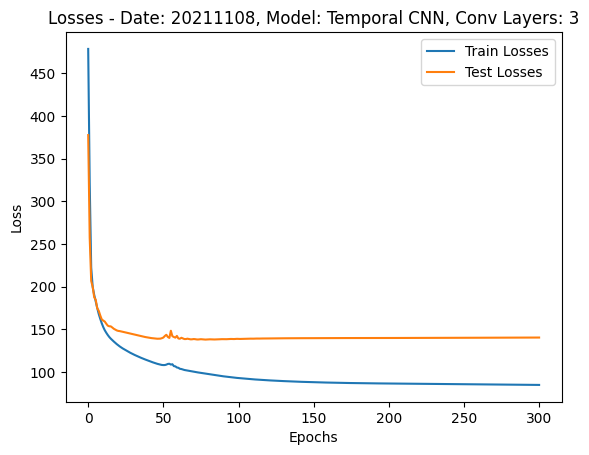

Temporal CNN, full dataset
Num Conv Layers: 3, Kernel Size: 5, Total Parameters: 143298
Epoch: 000, LR: 0.001000, Train Loss: 474.388743, Test Loss: 332.246948. Train R2: -0.5058467, Test R2: -0.5361208, Train pR2: -4.9034986, Test pR2: -4.9156752
Epoch: 050, LR: 0.000640, Train Loss: 187.963069, Test Loss: 229.787638. Train R2: 0.0751992, Test R2: -0.0755383, Train pR2: -1.7646823, Test pR2: -1.8869890
Epoch: 100, LR: 0.000210, Train Loss: 173.942978, Test Loss: 235.355077. Train R2: 0.1446023, Test R2: -0.1154762, Train pR2: -1.4866407, Test pR2: -1.7244354
Epoch: 150, LR: 0.000055, Train Loss: 169.566562, Test Loss: 239.151388. Train R2: 0.1642449, Test R2: -0.1324637, Train pR2: -1.3502202, Test pR2: -1.6666784
Epoch: 200, LR: 0.000050, Train Loss: 168.060620, Test Loss: 240.401652. Train R2: 0.1716480, Test R2: -0.1390349, Train pR2: -1.3425475, Test pR2: -1.6809645
Epoch: 250, LR: 0.000050, Train Loss: 166.585232, Test Loss: 241.605759. Train R2: 0.1789182, Test R2: -0.1453380, T

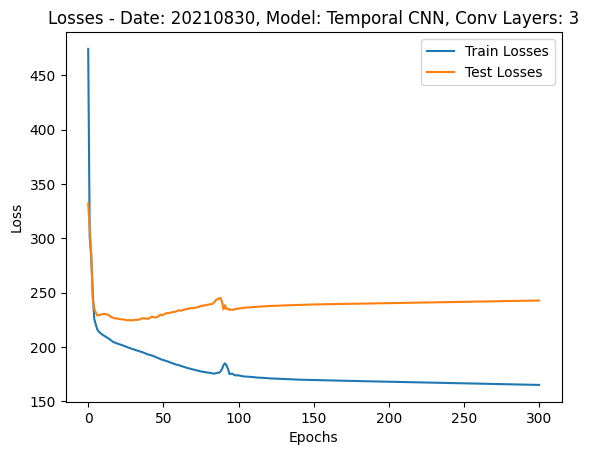

Temporal CNN, full dataset
Num Conv Layers: 3, Kernel Size: 5, Total Parameters: 145035
Epoch: 000, LR: 0.001000, Train Loss: 289.386303, Test Loss: 194.010254. Train R2: -0.2103074, Test R2: -0.2391717, Train pR2: -4.3853979, Test pR2: -4.6018939
Epoch: 050, LR: 0.001000, Train Loss: 104.612587, Test Loss: 124.486224. Train R2: 0.3248697, Test R2: 0.2004185, Train pR2: -1.5300354, Test pR2: -1.7227736
Epoch: 100, LR: 0.000640, Train Loss: 87.605281, Test Loss: 119.582527. Train R2: 0.4226275, Test R2: 0.2299849, Train pR2: -0.9989457, Test pR2: -1.2358929
Epoch: 150, LR: 0.000210, Train Loss: 82.307207, Test Loss: 117.909129. Train R2: 0.4649305, Test R2: 0.2384479, Train pR2: -0.9690767, Test pR2: -1.2678248
Epoch: 200, LR: 0.000055, Train Loss: 80.864232, Test Loss: 118.367149. Train R2: 0.4731167, Test R2: 0.2361121, Train pR2: -0.9404268, Test pR2: -1.2557710
Epoch: 250, LR: 0.000050, Train Loss: 80.271886, Test Loss: 118.572113. Train R2: 0.4769929, Test R2: 0.2346656, Train pR2:

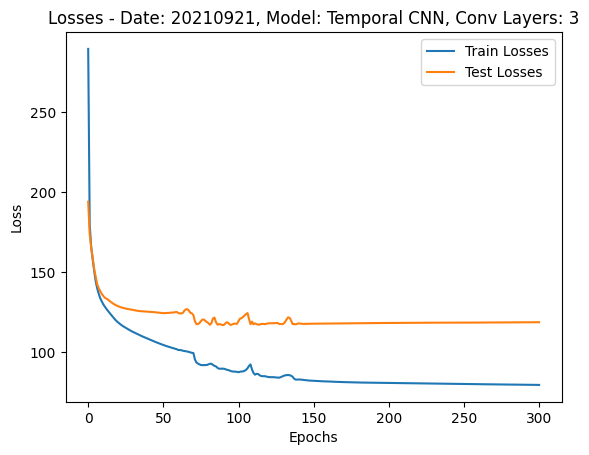

Temporal CNN, full dataset
Num Conv Layers: 3, Kernel Size: 5, Total Parameters: 144263
Epoch: 000, LR: 0.001000, Train Loss: 339.280045, Test Loss: 187.299998. Train R2: -0.4820785, Test R2: -0.4703132, Train pR2: -4.8434553, Test pR2: -4.9008980
Epoch: 050, LR: 0.001000, Train Loss: 93.601139, Test Loss: 103.049187. Train R2: 0.2753359, Test R2: 0.1898987, Train pR2: -1.8619095, Test pR2: -1.9441946
Epoch: 100, LR: 0.000410, Train Loss: 84.762285, Test Loss: 102.102269. Train R2: 0.3447953, Test R2: 0.1993215, Train pR2: -1.2155509, Test pR2: -1.3578066
Epoch: 150, LR: 0.000168, Train Loss: 81.511919, Test Loss: 102.055054. Train R2: 0.3659193, Test R2: 0.1989049, Train pR2: -1.0848367, Test pR2: -1.2473654
Epoch: 200, LR: 0.000050, Train Loss: 80.625577, Test Loss: 102.158613. Train R2: 0.3716883, Test R2: 0.1977958, Train pR2: -1.0774260, Test pR2: -1.2513227
Epoch: 250, LR: 0.000050, Train Loss: 80.191060, Test Loss: 102.292152. Train R2: 0.3751234, Test R2: 0.1967774, Train pR2: 

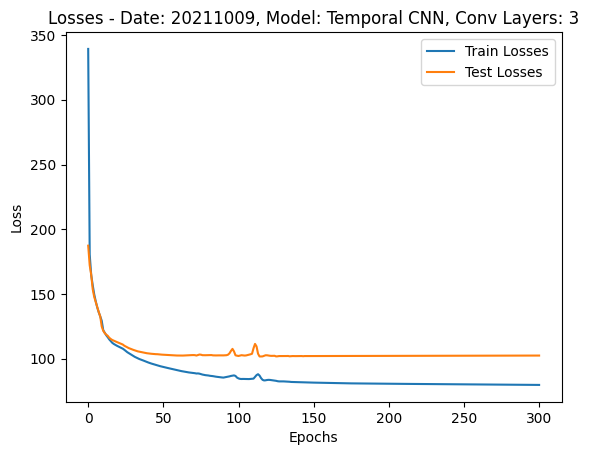

In [ ]:
for date in joint_angles_dict.keys():
    plot_losses_TempCNN(tcnn_dataset_dict[date]['Joint Angles']['Full'], \
                        tcnn_loader_dict[date]['Joint Angles']['Train'], \
                        tcnn_loader_dict[date]['Joint Angles']['Test'], \
                        0.001, 3, kernel_size = 5, add_relu = True, adapt_lr = True, \
                        save = False, causal = True, numepochs = 301)

Temporal CNN, full dataset
Num Conv Layers: 4, Kernel Size: 5, Total Parameters: 526125
Epoch: 000, LR: 0.001000, Train Loss: 440.526776, Test Loss: 282.355835. Train R2: -0.7379793, Test R2: -0.9001213, Train pR2: -1.2774769, Test pR2: -1.3525087
Epoch: 050, LR: 0.000800, Train Loss: 103.399818, Test Loss: 155.113594. Train R2: 0.3533111, Test R2: 0.1305471, Train pR2: -2.2917995, Test pR2: -2.4659562
Epoch: 100, LR: 0.000262, Train Loss: 85.247038, Test Loss: 148.157562. Train R2: 0.4710043, Test R2: 0.1273845, Train pR2: -2.1342888, Test pR2: -2.4182818
Epoch: 150, LR: 0.000069, Train Loss: 81.452592, Test Loss: 149.342712. Train R2: 0.4925760, Test R2: 0.1168662, Train pR2: -2.1327295, Test pR2: -2.4690194
Epoch: 200, LR: 0.000050, Train Loss: 79.900851, Test Loss: 149.973480. Train R2: 0.5016781, Test R2: 0.1118264, Train pR2: -2.1332939, Test pR2: -2.4953785
Epoch: 250, LR: 0.000050, Train Loss: 78.333028, Test Loss: 150.608360. Train R2: 0.5109864, Test R2: 0.1066468, Train pR2:

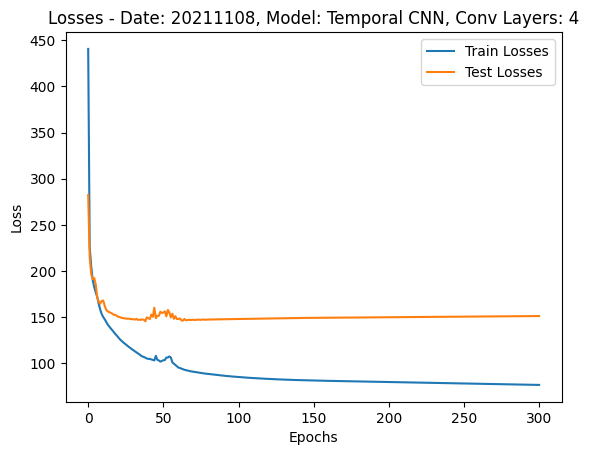

Temporal CNN, full dataset
Num Conv Layers: 4, Kernel Size: 5, Total Parameters: 534210
Epoch: 000, LR: 0.001000, Train Loss: 406.592628, Test Loss: 303.901805. Train R2: -0.3788891, Test R2: -0.4046672, Train pR2: -5.8456583, Test pR2: -5.9194336
Epoch: 050, LR: 0.000512, Train Loss: 179.848012, Test Loss: 243.157771. Train R2: 0.1116062, Test R2: -0.1319974, Train pR2: -3.9632084, Test pR2: -4.1881380
Epoch: 100, LR: 0.000168, Train Loss: 160.848245, Test Loss: 251.522268. Train R2: 0.2106395, Test R2: -0.1756704, Train pR2: -3.8044720, Test pR2: -4.1401420
Epoch: 150, LR: 0.000050, Train Loss: 154.422496, Test Loss: 258.273829. Train R2: 0.2389705, Test R2: -0.2010457, Train pR2: -3.8032191, Test pR2: -4.2331319
Epoch: 200, LR: 0.000050, Train Loss: 151.768880, Test Loss: 261.026021. Train R2: 0.2520205, Test R2: -0.2125438, Train pR2: -3.7649546, Test pR2: -4.2475648
Epoch: 250, LR: 0.000050, Train Loss: 149.006478, Test Loss: 263.496236. Train R2: 0.2655875, Test R2: -0.2234763, T

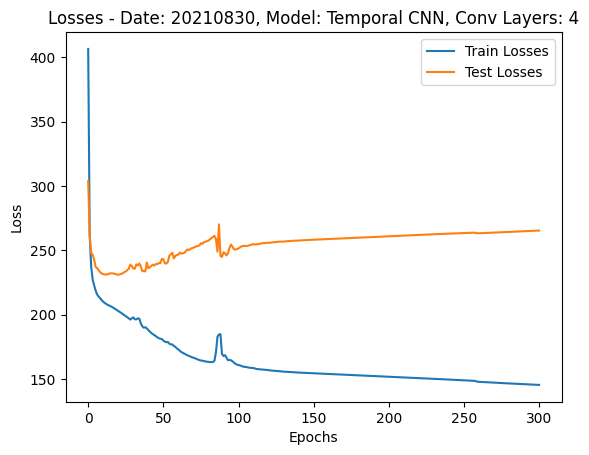

Temporal CNN, full dataset
Num Conv Layers: 4, Kernel Size: 5, Total Parameters: 537675
Epoch: 000, LR: 0.001000, Train Loss: 287.534241, Test Loss: 224.538254. Train R2: -0.3725083, Test R2: -0.4422545, Train pR2: -5.1525602, Test pR2: -5.2907238
Epoch: 050, LR: 0.001000, Train Loss: 94.475948, Test Loss: 122.864258. Train R2: 0.3917045, Test R2: 0.2133028, Train pR2: -2.1541879, Test pR2: -2.3647530
Epoch: 100, LR: 0.000262, Train Loss: 85.873990, Test Loss: 127.384204. Train R2: 0.4438377, Test R2: 0.1740915, Train pR2: -1.8679687, Test pR2: -2.2219188
Epoch: 150, LR: 0.000086, Train Loss: 76.014646, Test Loss: 123.926503. Train R2: 0.5052954, Test R2: 0.2019181, Train pR2: -1.5881702, Test pR2: -1.9760424
Epoch: 200, LR: 0.000050, Train Loss: 74.681057, Test Loss: 124.421491. Train R2: 0.5136653, Test R2: 0.1984484, Train pR2: -1.5301220, Test pR2: -1.9398763
Epoch: 250, LR: 0.000050, Train Loss: 73.478767, Test Loss: 124.941587. Train R2: 0.5215353, Test R2: 0.1948125, Train pR2: 

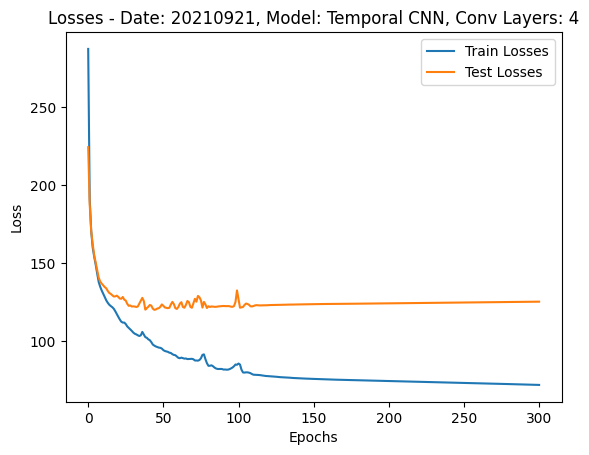

Temporal CNN, full dataset
Num Conv Layers: 4, Kernel Size: 5, Total Parameters: 536135
Epoch: 000, LR: 0.001000, Train Loss: 308.532883, Test Loss: 185.504918. Train R2: -0.4709114, Test R2: -0.4526836, Train pR2: -7.6823597, Test pR2: -7.6483545
Epoch: 050, LR: 0.001000, Train Loss: 91.679431, Test Loss: 104.913531. Train R2: 0.2882086, Test R2: 0.1764862, Train pR2: -3.4635267, Test pR2: -3.5191407
Epoch: 100, LR: 0.000410, Train Loss: 77.263752, Test Loss: 106.718335. Train R2: 0.3912175, Test R2: 0.1645533, Train pR2: -2.5911262, Test pR2: -2.8107502
Epoch: 150, LR: 0.000107, Train Loss: 74.249645, Test Loss: 106.096921. Train R2: 0.4229532, Test R2: 0.1674738, Train pR2: -2.3143961, Test pR2: -2.5647969
Epoch: 200, LR: 0.000050, Train Loss: 73.007859, Test Loss: 106.735619. Train R2: 0.4313424, Test R2: 0.1629848, Train pR2: -2.2995925, Test pR2: -2.5627890
Epoch: 250, LR: 0.000050, Train Loss: 72.233765, Test Loss: 107.121890. Train R2: 0.4374714, Test R2: 0.1598192, Train pR2: 

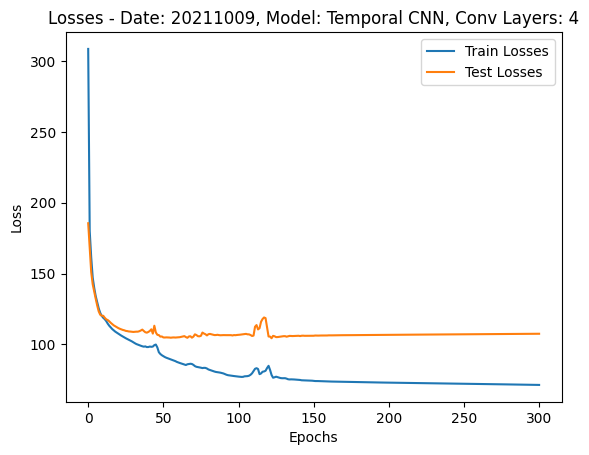

In [ ]:
for date in joint_angles_dict.keys():
    plot_losses_TempCNN(tcnn_dataset_dict[date]['Joint Angles']['Full'], \
                        tcnn_loader_dict[date]['Joint Angles']['Train'], \
                        tcnn_loader_dict[date]['Joint Angles']['Test'], \
                        0.001, 4, kernel_size = 5, add_relu = True, adapt_lr = True, \
                        save = False, causal = True, numepochs = 301)